<a href="https://colab.research.google.com/github/quanndm/kltn/blob/dev/notebooks/phase2/liver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Init - import library - download data

In [ ]:
!rm -rf kltn
!rm -rf sample_data
!git clone -b dev https://github.com/quanndm/kltn.git

Cloning into 'kltn'...
remote: Enumerating objects: 2634, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 2634 (delta 20), reused 21 (delta 8), pack-reused 2588 (from 2)
Receiving objects: 100% (2634/2634), 40.84 MiB | 25.27 MiB/s, done.
Resolving deltas: 100% (1828/1828), done.


In [ ]:
from kltn.init.install_dependencies import install_packages, load_config
install_packages("./kltn")
config = load_config("./kltn/parameters.yaml")

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
import json

from kltn import *
from kltn.datasets.get_datasets import get_datasets_stage_1
from kltn.utils.logger import init_logger
from kltn.utils.train_val_epochs import  trainer_stage1
from kltn.utils.metrics import  DiceMetric, TverskyLossWSigmoid, DiceLossWSigmoid
from kltn.models.model_factory import ModelFactory
from kltn.utils.visualize_results import visualize_results, visualize_results_stage_1
from kltn.processing.preprocessing import resize_crop_to_bbox_size, uncrop_to_full_image
from kltn.datasets.prepare_data import prepare_dataset_LiTS, merge_lits_and_msd

In [ ]:
drive.flush_and_unmount()
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
LOGGER = init_logger(config["log_path"])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
prepare_dataset_LiTS(dir_name=config["source_folder_lits"])

0.00% complete (down: 0.0 kB/s up: 0.0 kB/s peers: 4) downloading LITS17 (https://academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
LITS17 (https://ipv6.academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
LITS17 (https://academictorrents.com/announce.php)[172.28.0.12:6881] v1 unspecified system error "" (1)
LITS17 (https://ipv6.academictorrents.com/announce.php)[172.28.0.12:6881] v1 unspecified system error "" (1)
LITS17 (udp://tracker.opentrackr.org:1337/announce)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
5.39% complete (down: 73744.0 kB/s up: 2091.4 kB/s peers: 10) downloading LITS17 (https://academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (2)
LITS17 (https://ipv6.academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (2)
LITS17 (https://academictorrents.com/announce.php)[

In [ ]:
!wget https://msd-for-monai.s3-us-west-2.amazonaws.com/Task03_Liver.tar

--2025-05-12 07:15:16--  https://msd-for-monai.s3-us-west-2.amazonaws.com/Task03_Liver.tar
Resolving msd-for-monai.s3-us-west-2.amazonaws.com (msd-for-monai.s3-us-west-2.amazonaws.com)... 52.92.154.34, 3.5.77.139, 52.218.178.113, ...
Connecting to msd-for-monai.s3-us-west-2.amazonaws.com (msd-for-monai.s3-us-west-2.amazonaws.com)|52.92.154.34|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28925891584 (27G) [application/x-tar]
Saving to: ‘Task03_Liver.tar’

Task03_Liver.tar    100%[===================>]  26.94G  39.0MB/s    in 11m 31s 

2025-05-12 07:26:48 (39.9 MB/s) - ‘Task03_Liver.tar’ saved [28925891584/28925891584]



In [ ]:
!tar -xf ./Task03_Liver.tar && rm -rf ./Task03_Liver.tar && rm -rf ./Task03_Liver/imagesTs

Task03_Liver/._dataset.json
Task03_Liver/dataset.json
Task03_Liver/._imagesTr
Task03_Liver/imagesTr/
Task03_Liver/imagesTr/._liver_14.nii.gz
Task03_Liver/imagesTr/liver_14.nii.gz
Task03_Liver/imagesTr/._liver_69.nii.gz
Task03_Liver/imagesTr/liver_69.nii.gz
Task03_Liver/imagesTr/._liver_77.nii.gz
Task03_Liver/imagesTr/liver_77.nii.gz
Task03_Liver/imagesTr/._liver_120.nii.gz
Task03_Liver/imagesTr/liver_120.nii.gz
Task03_Liver/imagesTr/._liver_18.nii.gz
Task03_Liver/imagesTr/liver_18.nii.gz
Task03_Liver/imagesTr/._liver_65.nii.gz
Task03_Liver/imagesTr/liver_65.nii.gz
Task03_Liver/imagesTr/._liver_30.nii.gz
Task03_Liver/imagesTr/liver_30.nii.gz
Task03_Liver/imagesTr/._liver_116.nii.gz
Task03_Liver/imagesTr/liver_116.nii.gz
Task03_Liver/imagesTr/._liver_108.nii.gz
Task03_Liver/imagesTr/liver_108.nii.gz
Task03_Liver/imagesTr/._liver_53.nii.gz
Task03_Liver/imagesTr/liver_53.nii.gz
Task03_Liver/imagesTr/._liver_22.nii.gz
Task03_Liver/imagesTr/liver_22.nii.gz
Task03_Liver/imagesTr/._liver_104.n

In [ ]:
merge_lits_and_msd(
    config["source_folder_lits"],
    config["source_folder_msd"],
    config["source_folder_custom_dataset"],
)

## Load data

In [ ]:
full_train_dataset, val_dataset = get_datasets_stage_1(source_folder=config["source_folder_custom_dataset"], seed=123, fold_number=2, normalizations="minmax")
print(len(full_train_dataset), len(val_dataset))

105 26


In [ ]:
train_loader = torch.utils.data.DataLoader(full_train_dataset, batch_size=1, shuffle=True,
                                           num_workers=1, pin_memory=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False,
                                         pin_memory=True, num_workers=1)

## visualize

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def plot_sample(image_tensor, label_tensor):
    image_np = image_tensor.squeeze().cpu().numpy()
    label_np = label_tensor.squeeze().cpu().numpy()

    slide_index = image_np.shape[0] // 2

    # Lấy slice tại slice_index
    image_slice = image_np[slide_index, :, :]
    label_slice = label_np[slide_index, :, :]

    # Vẽ ảnh
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].imshow(image_slice, cmap='gray')
    axes[0].set_title("Image Slice")
    axes[0].axis('off')

    axes[1].imshow(label_slice, cmap='gray')
    axes[1].set_title("Label Slice")
    axes[1].axis('off')

    plt.show()


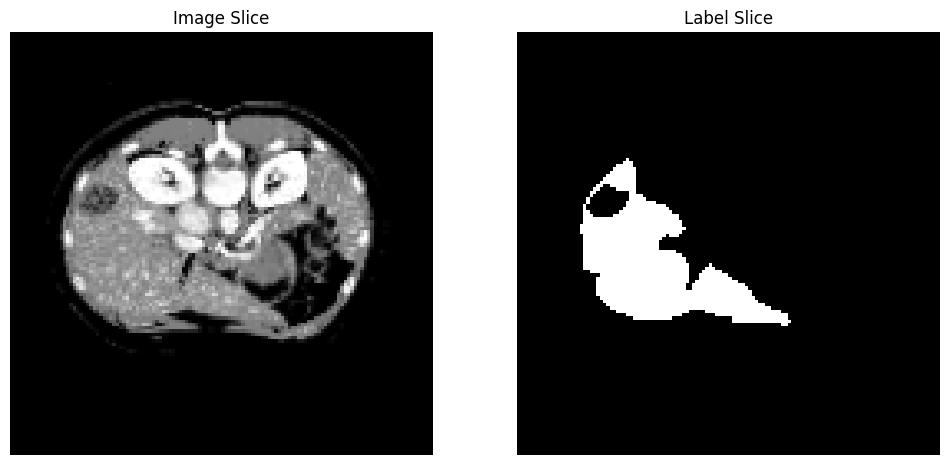

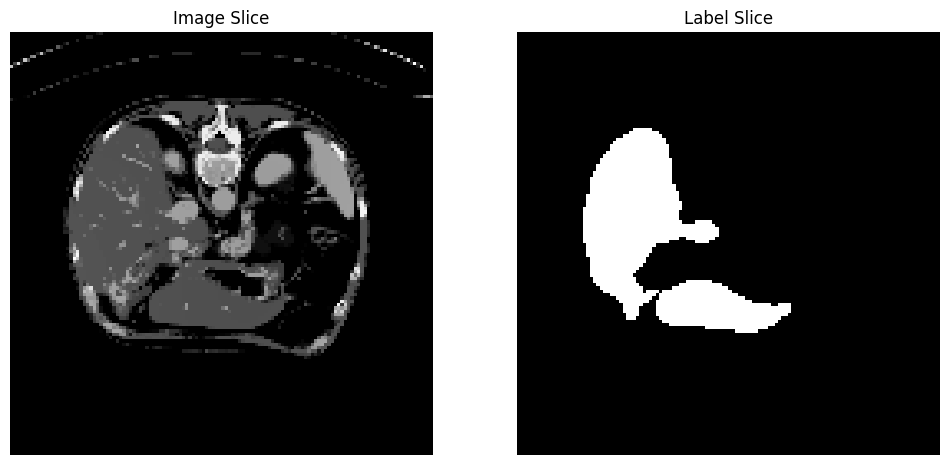

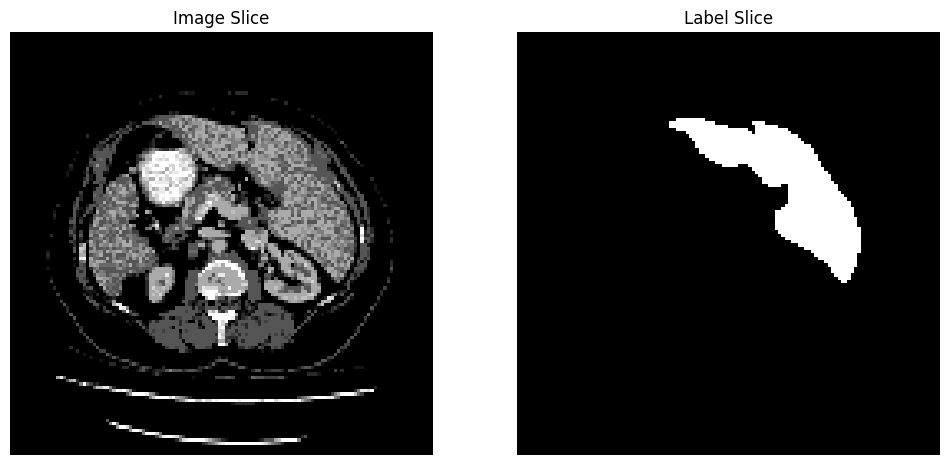

In [ ]:
i = 0
for batch in train_loader:
    i+=1
    image, label = batch["image"], batch["label"]
    plot_sample(image, label)

    if i == 3:
      break

## Training

In [ ]:
model = ModelFactory.get_model("unet3d_resnextcot",in_channels=1, n_classes=1, n_channels=16).to(device)

In [ ]:
criterion = DiceLossWSigmoid().to(device)

dice_acc = DiceMetric(include_background=False, reduction='mean_batch', get_not_nans=True)

optimizer = torch.optim.AdamW(model.parameters(), lr=float(config["learning_rate"]), weight_decay=float(config["weight_decay"]))
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=int(config["max_epochs"]), eta_min = float(config["eta_min"]))

In [14]:
LOGGER.info("[TRAINER] Start TRAIN process...")

(
    val_acc_max,
    best_epoch,
    dices_liver,
    loss_epochs,
    trains_epoch,
    ious_liver,
    precisions_liver,
    recalls_liver,
    time_tmp
) = trainer_stage1(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    loss_func=criterion,
    acc_func=dice_acc,
    scheduler=scheduler,
    batch_size=config["batch_size"],
    max_epochs = config["max_epochs"],
    start_epoch = config["start_epoch"],
    val_every=config["val_every"],
    path_save_model=config["path_save_model_state"],
    logger=LOGGER,
    save_model=True,
    post_fix="liver_1"
)

[TRAINER] Start TRAIN process...
INFO:kltn.utils.logger:[TRAINER] Start TRAIN process...

==============================Training epoch 1==============================
INFO:kltn.utils.logger:
==============================Training epoch 1==============================


Epoch 1/70 1/96 loss: 0.9139 time 20.18s
Epoch 1/70 2/96 loss: 0.8720 time 3.79s
Epoch 1/70 3/96 loss: 0.8521 time 32.03s
Epoch 1/70 4/96 loss: 0.8449 time 3.04s
Epoch 1/70 5/96 loss: 0.8323 time 12.98s
Epoch 1/70 6/96 loss: 0.8087 time 13.17s
Epoch 1/70 7/96 loss: 0.7937 time 19.04s
Epoch 1/70 8/96 loss: 0.7849 time 21.07s
Epoch 1/70 9/96 loss: 0.7847 time 1.24s
Epoch 1/70 10/96 loss: 0.7852 time 20.11s
Epoch 1/70 11/96 loss: 0.7810 time 1.28s
Epoch 1/70 12/96 loss: 0.7837 time 8.09s
Epoch 1/70 13/96 loss: 0.7781 time 1.24s
Epoch 1/70 14/96 loss: 0.7755 time 16.95s
Epoch 1/70 15/96 loss: 0.7777 time 1.28s
Epoch 1/70 16/96 loss: 0.7789 time 25.59s
Epoch 1/70 17/96 loss: 0.7810 time 1.25s
Epoch 1/70 18/96 loss: 0.7821 time 11.61s
Epoch 1/70 19/96 loss: 0.7826 time 1.25s
Epoch 1/70 20/96 loss: 0.7838 time 18.37s
Epoch 1/70 21/96 loss: 0.7835 time 1.34s
Epoch 1/70 22/96 loss: 0.7834 time 19.02s
Epoch 1/70 23/96 loss: 0.7840 time 1.81s
Epoch 1/70 24/96 loss: 0.7846 time 18.45s
Epoch 1/70 2

Final training epochs: 1/70 ---[loss: 0.4724] ---[time 937.68s]
INFO:kltn.utils.logger:Final training epochs: 1/70 ---[loss: 0.4724] ---[time 937.68s]

********************Epoch 1 Validation********************
INFO:kltn.utils.logger:
********************Epoch 1 Validation********************


Epoch 1/70 96/96 loss: 0.4724 time 1.32s


Val 1/70 1/24, Dice_Liver: 0.711169, time 24.99s
INFO:kltn.utils.logger:Val 1/70 1/24, Dice_Liver: 0.711169, time 24.99s
Val 1/70 2/24, Dice_Liver: 0.796129, time 0.31s
INFO:kltn.utils.logger:Val 1/70 2/24, Dice_Liver: 0.796129, time 0.31s
Val 1/70 3/24, Dice_Liver: 0.680840, time 14.63s
INFO:kltn.utils.logger:Val 1/70 3/24, Dice_Liver: 0.680840, time 14.63s
Val 1/70 4/24, Dice_Liver: 0.744420, time 0.28s
INFO:kltn.utils.logger:Val 1/70 4/24, Dice_Liver: 0.744420, time 0.28s
Val 1/70 5/24, Dice_Liver: 0.765234, time 19.20s
INFO:kltn.utils.logger:Val 1/70 5/24, Dice_Liver: 0.765234, time 19.20s
Val 1/70 6/24, Dice_Liver: 0.799101, time 0.28s
INFO:kltn.utils.logger:Val 1/70 6/24, Dice_Liver: 0.799101, time 0.28s
Val 1/70 7/24, Dice_Liver: 0.790913, time 5.93s
INFO:kltn.utils.logger:Val 1/70 7/24, Dice_Liver: 0.790913, time 5.93s
Val 1/70 8/24, Dice_Liver: 0.723532, time 6.20s
INFO:kltn.utils.logger:Val 1/70 8/24, Dice_Liver: 0.723532, time 6.20s
Val 1/70 9/24, Dice_Liver: 0.787411, time 

New best (0.000000 --> 0.729348). At epoch 1


Epoch 1/70 ---[loss: 0.4724] ---[val_dice: 0.729348] ---[time 215.39s]
INFO:kltn.utils.logger:Epoch 1/70 ---[loss: 0.4724] ---[val_dice: 0.729348] ---[time 215.39s]

==============================Training epoch 2==============================
INFO:kltn.utils.logger:
==============================Training epoch 2==============================


Epoch 2/70 1/96 loss: 0.1886 time 34.82s
Epoch 2/70 2/96 loss: 0.1734 time 1.32s
Epoch 2/70 3/96 loss: 0.1722 time 22.38s
Epoch 2/70 4/96 loss: 0.1655 time 1.37s
Epoch 2/70 5/96 loss: 0.1708 time 5.09s
Epoch 2/70 6/96 loss: 0.1687 time 1.34s
Epoch 2/70 7/96 loss: 0.1767 time 27.89s
Epoch 2/70 8/96 loss: 0.1744 time 1.42s
Epoch 2/70 9/96 loss: 0.1708 time 12.88s
Epoch 2/70 10/96 loss: 0.1674 time 1.37s
Epoch 2/70 11/96 loss: 0.1678 time 27.13s
Epoch 2/70 12/96 loss: 0.1720 time 1.35s
Epoch 2/70 13/96 loss: 0.1751 time 18.49s
Epoch 2/70 14/96 loss: 0.1721 time 1.32s
Epoch 2/70 15/96 loss: 0.1726 time 15.77s
Epoch 2/70 16/96 loss: 0.1756 time 1.34s
Epoch 2/70 17/96 loss: 0.1839 time 15.95s
Epoch 2/70 18/96 loss: 0.1823 time 1.41s
Epoch 2/70 19/96 loss: 0.1852 time 8.82s
Epoch 2/70 20/96 loss: 0.1892 time 10.40s
Epoch 2/70 21/96 loss: 0.1941 time 1.34s
Epoch 2/70 22/96 loss: 0.1959 time 19.44s
Epoch 2/70 23/96 loss: 0.1944 time 1.34s
Epoch 2/70 24/96 loss: 0.1964 time 25.37s
Epoch 2/70 25/

Final training epochs: 2/70 ---[loss: 0.1677] ---[time 945.55s]
INFO:kltn.utils.logger:Final training epochs: 2/70 ---[loss: 0.1677] ---[time 945.55s]

********************Epoch 2 Validation********************
INFO:kltn.utils.logger:
********************Epoch 2 Validation********************


Epoch 2/70 96/96 loss: 0.1677 time 18.15s


Val 2/70 1/24, Dice_Liver: 0.450545, time 21.43s
INFO:kltn.utils.logger:Val 2/70 1/24, Dice_Liver: 0.450545, time 21.43s
Val 2/70 2/24, Dice_Liver: 0.781988, time 0.29s
INFO:kltn.utils.logger:Val 2/70 2/24, Dice_Liver: 0.781988, time 0.29s
Val 2/70 3/24, Dice_Liver: 0.749792, time 16.73s
INFO:kltn.utils.logger:Val 2/70 3/24, Dice_Liver: 0.749792, time 16.73s
Val 2/70 4/24, Dice_Liver: 0.797743, time 0.29s
INFO:kltn.utils.logger:Val 2/70 4/24, Dice_Liver: 0.797743, time 0.29s
Val 2/70 5/24, Dice_Liver: 0.802268, time 19.70s
INFO:kltn.utils.logger:Val 2/70 5/24, Dice_Liver: 0.802268, time 19.70s
Val 2/70 6/24, Dice_Liver: 0.847443, time 0.30s
INFO:kltn.utils.logger:Val 2/70 6/24, Dice_Liver: 0.847443, time 0.30s
Val 2/70 7/24, Dice_Liver: 0.864112, time 4.16s
INFO:kltn.utils.logger:Val 2/70 7/24, Dice_Liver: 0.864112, time 4.16s
Val 2/70 8/24, Dice_Liver: 0.783661, time 6.67s
INFO:kltn.utils.logger:Val 2/70 8/24, Dice_Liver: 0.783661, time 6.67s
Val 2/70 9/24, Dice_Liver: 0.813407, time 

New best (0.729348 --> 0.781487). At epoch 2


INFO:kltn.utils.logger:
==============================Training epoch 3==============================


Epoch 3/70 1/96 loss: 0.1424 time 18.09s
Epoch 3/70 2/96 loss: 0.1497 time 10.97s
Epoch 3/70 3/96 loss: 0.1522 time 6.28s
Epoch 3/70 4/96 loss: 0.1387 time 12.21s
Epoch 3/70 5/96 loss: 0.1351 time 1.58s
Epoch 3/70 6/96 loss: 0.1443 time 16.49s
Epoch 3/70 7/96 loss: 0.1418 time 12.00s
Epoch 3/70 8/96 loss: 0.1395 time 3.28s
Epoch 3/70 9/96 loss: 0.1425 time 19.81s
Epoch 3/70 10/96 loss: 0.1473 time 5.37s
Epoch 3/70 11/96 loss: 0.1451 time 1.32s
Epoch 3/70 12/96 loss: 0.1428 time 12.12s
Epoch 3/70 13/96 loss: 0.1437 time 14.64s
Epoch 3/70 14/96 loss: 0.1464 time 1.55s
Epoch 3/70 15/96 loss: 0.1451 time 15.61s
Epoch 3/70 16/96 loss: 0.1469 time 1.35s
Epoch 3/70 17/96 loss: 0.1473 time 19.39s
Epoch 3/70 18/96 loss: 0.1451 time 1.34s
Epoch 3/70 19/96 loss: 0.1460 time 24.49s
Epoch 3/70 20/96 loss: 0.1467 time 1.36s
Epoch 3/70 21/96 loss: 0.1449 time 12.36s
Epoch 3/70 22/96 loss: 0.1430 time 1.34s
Epoch 3/70 23/96 loss: 0.1406 time 18.48s
Epoch 3/70 24/96 loss: 0.1393 time 1.36s
Epoch 3/70 2

Final training epochs: 3/70 ---[loss: 0.1180] ---[time 924.06s]
INFO:kltn.utils.logger:Final training epochs: 3/70 ---[loss: 0.1180] ---[time 924.06s]

********************Epoch 3 Validation********************
INFO:kltn.utils.logger:
********************Epoch 3 Validation********************


Epoch 3/70 96/96 loss: 0.1180 time 14.70s


Val 3/70 1/24, Dice_Liver: 0.448021, time 20.73s
INFO:kltn.utils.logger:Val 3/70 1/24, Dice_Liver: 0.448021, time 20.73s
Val 3/70 2/24, Dice_Liver: 0.881847, time 0.29s
INFO:kltn.utils.logger:Val 3/70 2/24, Dice_Liver: 0.881847, time 0.29s
Val 3/70 3/24, Dice_Liver: 0.833324, time 17.30s
INFO:kltn.utils.logger:Val 3/70 3/24, Dice_Liver: 0.833324, time 17.30s
Val 3/70 4/24, Dice_Liver: 0.846102, time 0.28s
INFO:kltn.utils.logger:Val 3/70 4/24, Dice_Liver: 0.846102, time 0.28s
Val 3/70 5/24, Dice_Liver: 0.895498, time 22.78s
INFO:kltn.utils.logger:Val 3/70 5/24, Dice_Liver: 0.895498, time 22.78s
Val 3/70 6/24, Dice_Liver: 0.889153, time 0.30s
INFO:kltn.utils.logger:Val 3/70 6/24, Dice_Liver: 0.889153, time 0.30s
Val 3/70 7/24, Dice_Liver: 0.875870, time 3.17s
INFO:kltn.utils.logger:Val 3/70 7/24, Dice_Liver: 0.875870, time 3.17s
Val 3/70 8/24, Dice_Liver: 0.893764, time 1.77s
INFO:kltn.utils.logger:Val 3/70 8/24, Dice_Liver: 0.893764, time 1.77s
Val 3/70 9/24, Dice_Liver: 0.897089, time 

New best (0.781487 --> 0.847782). At epoch 3
Epoch 4/70 1/96 loss: 0.0734 time 13.71s
Epoch 4/70 2/96 loss: 0.0766 time 10.67s
Epoch 4/70 3/96 loss: 0.0778 time 5.59s
Epoch 4/70 4/96 loss: 0.0753 time 12.31s
Epoch 4/70 5/96 loss: 0.0760 time 11.73s
Epoch 4/70 6/96 loss: 0.0894 time 1.34s
Epoch 4/70 7/96 loss: 0.0919 time 9.56s
Epoch 4/70 8/96 loss: 0.0941 time 1.32s
Epoch 4/70 9/96 loss: 0.1012 time 26.44s
Epoch 4/70 10/96 loss: 0.1031 time 1.30s
Epoch 4/70 11/96 loss: 0.1052 time 15.94s
Epoch 4/70 12/96 loss: 0.1022 time 1.36s
Epoch 4/70 13/96 loss: 0.1038 time 3.74s
Epoch 4/70 14/96 loss: 0.1060 time 1.37s
Epoch 4/70 15/96 loss: 0.1073 time 18.31s
Epoch 4/70 16/96 loss: 0.1068 time 1.39s
Epoch 4/70 17/96 loss: 0.1075 time 14.13s
Epoch 4/70 18/96 loss: 0.1063 time 1.33s
Epoch 4/70 19/96 loss: 0.1080 time 19.81s
Epoch 4/70 20/96 loss: 0.1068 time 1.32s
Epoch 4/70 21/96 loss: 0.1073 time 14.64s
Epoch 4/70 22/96 loss: 0.1066 time 1.38s
Epoch 4/70 23/96 loss: 0.1062 time 18.30s
Epoch 4/70

Final training epochs: 4/70 ---[loss: 0.0945] ---[time 934.60s]
INFO:kltn.utils.logger:Final training epochs: 4/70 ---[loss: 0.0945] ---[time 934.60s]

********************Epoch 4 Validation********************
INFO:kltn.utils.logger:
********************Epoch 4 Validation********************


Epoch 4/70 96/96 loss: 0.0945 time 1.31s


Val 4/70 1/24, Dice_Liver: 0.374128, time 22.09s
INFO:kltn.utils.logger:Val 4/70 1/24, Dice_Liver: 0.374128, time 22.09s
Val 4/70 2/24, Dice_Liver: 0.911262, time 0.29s
INFO:kltn.utils.logger:Val 4/70 2/24, Dice_Liver: 0.911262, time 0.29s
Val 4/70 3/24, Dice_Liver: 0.855066, time 15.90s
INFO:kltn.utils.logger:Val 4/70 3/24, Dice_Liver: 0.855066, time 15.90s
Val 4/70 4/24, Dice_Liver: 0.277953, time 0.53s
INFO:kltn.utils.logger:Val 4/70 4/24, Dice_Liver: 0.277953, time 0.53s
Val 4/70 5/24, Dice_Liver: 0.466721, time 19.05s
INFO:kltn.utils.logger:Val 4/70 5/24, Dice_Liver: 0.466721, time 19.05s
Val 4/70 6/24, Dice_Liver: 0.855735, time 0.29s
INFO:kltn.utils.logger:Val 4/70 6/24, Dice_Liver: 0.855735, time 0.29s
Val 4/70 7/24, Dice_Liver: 0.888672, time 2.90s
INFO:kltn.utils.logger:Val 4/70 7/24, Dice_Liver: 0.888672, time 2.90s
Val 4/70 8/24, Dice_Liver: 0.813998, time 11.41s
INFO:kltn.utils.logger:Val 4/70 8/24, Dice_Liver: 0.813998, time 11.41s
Val 4/70 9/24, Dice_Liver: 0.714582, tim

Epoch 5/70 1/96 loss: 0.0581 time 30.81s
Epoch 5/70 2/96 loss: 0.0723 time 1.38s
Epoch 5/70 3/96 loss: 0.0717 time 15.04s
Epoch 5/70 4/96 loss: 0.0711 time 1.34s
Epoch 5/70 5/96 loss: 0.0859 time 19.48s
Epoch 5/70 6/96 loss: 0.0860 time 1.34s
Epoch 5/70 7/96 loss: 0.0853 time 19.22s
Epoch 5/70 8/96 loss: 0.0859 time 1.33s
Epoch 5/70 9/96 loss: 0.0852 time 19.04s
Epoch 5/70 10/96 loss: 0.0930 time 1.32s
Epoch 5/70 11/96 loss: 0.0927 time 4.37s
Epoch 5/70 12/96 loss: 0.0910 time 1.34s
Epoch 5/70 13/96 loss: 0.0896 time 13.66s
Epoch 5/70 14/96 loss: 0.0888 time 5.38s
Epoch 5/70 15/96 loss: 0.0868 time 1.40s
Epoch 5/70 16/96 loss: 0.0861 time 14.79s
Epoch 5/70 17/96 loss: 0.0910 time 4.43s
Epoch 5/70 18/96 loss: 0.0915 time 21.47s
Epoch 5/70 19/96 loss: 0.0899 time 1.36s
Epoch 5/70 20/96 loss: 0.0907 time 5.71s
Epoch 5/70 21/96 loss: 0.0918 time 1.32s
Epoch 5/70 22/96 loss: 0.0929 time 28.07s
Epoch 5/70 23/96 loss: 0.0927 time 1.32s
Epoch 5/70 24/96 loss: 0.0934 time 16.33s
Epoch 5/70 25/9

Final training epochs: 5/70 ---[loss: 0.0916] ---[time 941.12s]
INFO:kltn.utils.logger:Final training epochs: 5/70 ---[loss: 0.0916] ---[time 941.12s]

********************Epoch 5 Validation********************
INFO:kltn.utils.logger:
********************Epoch 5 Validation********************


Epoch 5/70 96/96 loss: 0.0916 time 1.31s


Val 5/70 1/24, Dice_Liver: 0.553138, time 22.89s
INFO:kltn.utils.logger:Val 5/70 1/24, Dice_Liver: 0.553138, time 22.89s
Val 5/70 2/24, Dice_Liver: 0.894139, time 0.28s
INFO:kltn.utils.logger:Val 5/70 2/24, Dice_Liver: 0.894139, time 0.28s
Val 5/70 3/24, Dice_Liver: 0.875764, time 17.83s
INFO:kltn.utils.logger:Val 5/70 3/24, Dice_Liver: 0.875764, time 17.83s
Val 5/70 4/24, Dice_Liver: 0.906927, time 1.45s
INFO:kltn.utils.logger:Val 5/70 4/24, Dice_Liver: 0.906927, time 1.45s
Val 5/70 5/24, Dice_Liver: 0.851194, time 17.43s
INFO:kltn.utils.logger:Val 5/70 5/24, Dice_Liver: 0.851194, time 17.43s
Val 5/70 6/24, Dice_Liver: 0.908211, time 0.30s
INFO:kltn.utils.logger:Val 5/70 6/24, Dice_Liver: 0.908211, time 0.30s
Val 5/70 7/24, Dice_Liver: 0.920298, time 2.59s
INFO:kltn.utils.logger:Val 5/70 7/24, Dice_Liver: 0.920298, time 2.59s
Val 5/70 8/24, Dice_Liver: 0.894198, time 12.35s
INFO:kltn.utils.logger:Val 5/70 8/24, Dice_Liver: 0.894198, time 12.35s
Val 5/70 9/24, Dice_Liver: 0.937300, tim

New best (0.847782 --> 0.886913). At epoch 5
Epoch 6/70 1/96 loss: 0.0770 time 30.03s
Epoch 6/70 2/96 loss: 0.0809 time 1.36s
Epoch 6/70 3/96 loss: 0.0763 time 33.86s
Epoch 6/70 4/96 loss: 0.0716 time 1.29s
Epoch 6/70 5/96 loss: 0.0714 time 11.15s
Epoch 6/70 6/96 loss: 0.0732 time 1.30s
Epoch 6/70 7/96 loss: 0.0737 time 23.95s
Epoch 6/70 8/96 loss: 0.0729 time 1.32s
Epoch 6/70 9/96 loss: 0.0712 time 12.08s
Epoch 6/70 10/96 loss: 0.0713 time 1.38s
Epoch 6/70 11/96 loss: 0.0711 time 10.35s
Epoch 6/70 12/96 loss: 0.0705 time 1.31s
Epoch 6/70 13/96 loss: 0.0697 time 15.14s
Epoch 6/70 14/96 loss: 0.0704 time 1.33s
Epoch 6/70 15/96 loss: 0.0696 time 11.08s
Epoch 6/70 16/96 loss: 0.0693 time 1.37s
Epoch 6/70 17/96 loss: 0.0692 time 16.54s
Epoch 6/70 18/96 loss: 0.0702 time 1.35s
Epoch 6/70 19/96 loss: 0.0713 time 19.56s
Epoch 6/70 20/96 loss: 0.0715 time 1.75s
Epoch 6/70 21/96 loss: 0.0709 time 3.67s
Epoch 6/70 22/96 loss: 0.0715 time 12.09s
Epoch 6/70 23/96 loss: 0.0711 time 1.33s
Epoch 6/70

Final training epochs: 6/70 ---[loss: 0.0703] ---[time 941.19s]
INFO:kltn.utils.logger:Final training epochs: 6/70 ---[loss: 0.0703] ---[time 941.19s]

********************Epoch 6 Validation********************
INFO:kltn.utils.logger:
********************Epoch 6 Validation********************


Epoch 6/70 96/96 loss: 0.0703 time 13.81s


Val 6/70 1/24, Dice_Liver: 0.901919, time 23.09s
INFO:kltn.utils.logger:Val 6/70 1/24, Dice_Liver: 0.901919, time 23.09s
Val 6/70 2/24, Dice_Liver: 0.913291, time 0.29s
INFO:kltn.utils.logger:Val 6/70 2/24, Dice_Liver: 0.913291, time 0.29s
Val 6/70 3/24, Dice_Liver: 0.873817, time 16.35s
INFO:kltn.utils.logger:Val 6/70 3/24, Dice_Liver: 0.873817, time 16.35s
Val 6/70 4/24, Dice_Liver: 0.907324, time 0.30s
INFO:kltn.utils.logger:Val 6/70 4/24, Dice_Liver: 0.907324, time 0.30s
Val 6/70 5/24, Dice_Liver: 0.883487, time 17.30s
INFO:kltn.utils.logger:Val 6/70 5/24, Dice_Liver: 0.883487, time 17.30s
Val 6/70 6/24, Dice_Liver: 0.921096, time 0.29s
INFO:kltn.utils.logger:Val 6/70 6/24, Dice_Liver: 0.921096, time 0.29s
Val 6/70 7/24, Dice_Liver: 0.916159, time 4.56s
INFO:kltn.utils.logger:Val 6/70 7/24, Dice_Liver: 0.916159, time 4.56s
Val 6/70 8/24, Dice_Liver: 0.863161, time 0.77s
INFO:kltn.utils.logger:Val 6/70 8/24, Dice_Liver: 0.863161, time 0.77s
Val 6/70 9/24, Dice_Liver: 0.943623, time 

New best (0.886913 --> 0.902551). At epoch 6
Epoch 7/70 1/96 loss: 0.0529 time 4.26s
Epoch 7/70 2/96 loss: 0.0530 time 11.11s
Epoch 7/70 3/96 loss: 0.0588 time 17.89s
Epoch 7/70 4/96 loss: 0.0579 time 10.05s
Epoch 7/70 5/96 loss: 0.0587 time 13.38s
Epoch 7/70 6/96 loss: 0.0614 time 7.44s
Epoch 7/70 7/96 loss: 0.0607 time 4.31s
Epoch 7/70 8/96 loss: 0.0605 time 16.88s
Epoch 7/70 9/96 loss: 0.0613 time 8.36s
Epoch 7/70 10/96 loss: 0.0605 time 2.32s
Epoch 7/70 11/96 loss: 0.0675 time 32.50s
Epoch 7/70 12/96 loss: 0.0671 time 1.33s
Epoch 7/70 13/96 loss: 0.0660 time 5.71s
Epoch 7/70 14/96 loss: 0.0655 time 6.43s
Epoch 7/70 15/96 loss: 0.0653 time 1.32s
Epoch 7/70 16/96 loss: 0.0649 time 32.96s
Epoch 7/70 17/96 loss: 0.0650 time 1.31s
Epoch 7/70 18/96 loss: 0.0656 time 21.51s
Epoch 7/70 19/96 loss: 0.0649 time 1.31s
Epoch 7/70 20/96 loss: 0.0646 time 33.10s
Epoch 7/70 21/96 loss: 0.0645 time 1.36s
Epoch 7/70 22/96 loss: 0.0639 time 18.73s
Epoch 7/70 23/96 loss: 0.0640 time 1.34s
Epoch 7/70 

Final training epochs: 7/70 ---[loss: 0.0760] ---[time 962.84s]
INFO:kltn.utils.logger:Final training epochs: 7/70 ---[loss: 0.0760] ---[time 962.84s]

********************Epoch 7 Validation********************
INFO:kltn.utils.logger:
********************Epoch 7 Validation********************


Epoch 7/70 96/96 loss: 0.0760 time 12.23s


Val 7/70 1/24, Dice_Liver: 0.652184, time 21.02s
INFO:kltn.utils.logger:Val 7/70 1/24, Dice_Liver: 0.652184, time 21.02s
Val 7/70 2/24, Dice_Liver: 0.896578, time 0.30s
INFO:kltn.utils.logger:Val 7/70 2/24, Dice_Liver: 0.896578, time 0.30s
Val 7/70 3/24, Dice_Liver: 0.765621, time 16.64s
INFO:kltn.utils.logger:Val 7/70 3/24, Dice_Liver: 0.765621, time 16.64s
Val 7/70 4/24, Dice_Liver: 0.854098, time 2.84s
INFO:kltn.utils.logger:Val 7/70 4/24, Dice_Liver: 0.854098, time 2.84s
Val 7/70 5/24, Dice_Liver: 0.760222, time 16.99s
INFO:kltn.utils.logger:Val 7/70 5/24, Dice_Liver: 0.760222, time 16.99s
Val 7/70 6/24, Dice_Liver: 0.917599, time 0.28s
INFO:kltn.utils.logger:Val 7/70 6/24, Dice_Liver: 0.917599, time 0.28s
Val 7/70 7/24, Dice_Liver: 0.827219, time 2.54s
INFO:kltn.utils.logger:Val 7/70 7/24, Dice_Liver: 0.827219, time 2.54s
Val 7/70 8/24, Dice_Liver: 0.873415, time 12.75s
INFO:kltn.utils.logger:Val 7/70 8/24, Dice_Liver: 0.873415, time 12.75s
Val 7/70 9/24, Dice_Liver: 0.900862, tim

Epoch 8/70 1/96 loss: 0.1066 time 5.22s
Epoch 8/70 2/96 loss: 0.0976 time 14.04s
Epoch 8/70 3/96 loss: 0.0939 time 10.04s
Epoch 8/70 4/96 loss: 0.0917 time 19.92s
Epoch 8/70 5/96 loss: 0.0975 time 7.49s
Epoch 8/70 6/96 loss: 0.1023 time 4.31s
Epoch 8/70 7/96 loss: 0.1014 time 12.49s
Epoch 8/70 8/96 loss: 0.0977 time 1.36s
Epoch 8/70 9/96 loss: 0.0949 time 8.34s
Epoch 8/70 10/96 loss: 0.0928 time 7.88s
Epoch 8/70 11/96 loss: 0.0904 time 10.77s
Epoch 8/70 12/96 loss: 0.0877 time 8.88s
Epoch 8/70 13/96 loss: 0.0867 time 18.82s
Epoch 8/70 14/96 loss: 0.0881 time 10.82s
Epoch 8/70 15/96 loss: 0.0869 time 1.40s
Epoch 8/70 16/96 loss: 0.0845 time 2.14s
Epoch 8/70 17/96 loss: 0.0832 time 9.61s
Epoch 8/70 18/96 loss: 0.0842 time 5.42s
Epoch 8/70 19/96 loss: 0.0839 time 18.86s
Epoch 8/70 20/96 loss: 0.0840 time 11.03s
Epoch 8/70 21/96 loss: 0.0839 time 12.27s
Epoch 8/70 22/96 loss: 0.0863 time 8.22s
Epoch 8/70 23/96 loss: 0.0863 time 16.29s
Epoch 8/70 24/96 loss: 0.0854 time 15.01s
Epoch 8/70 25

Final training epochs: 8/70 ---[loss: 0.0765] ---[time 921.64s]
INFO:kltn.utils.logger:Final training epochs: 8/70 ---[loss: 0.0765] ---[time 921.64s]

********************Epoch 8 Validation********************
INFO:kltn.utils.logger:
********************Epoch 8 Validation********************


Epoch 8/70 96/96 loss: 0.0765 time 11.57s


Val 8/70 1/24, Dice_Liver: 0.670052, time 21.35s
INFO:kltn.utils.logger:Val 8/70 1/24, Dice_Liver: 0.670052, time 21.35s
Val 8/70 2/24, Dice_Liver: 0.931187, time 0.30s
INFO:kltn.utils.logger:Val 8/70 2/24, Dice_Liver: 0.931187, time 0.30s
Val 8/70 3/24, Dice_Liver: 0.884659, time 18.77s
INFO:kltn.utils.logger:Val 8/70 3/24, Dice_Liver: 0.884659, time 18.77s
Val 8/70 4/24, Dice_Liver: 0.908958, time 2.63s
INFO:kltn.utils.logger:Val 8/70 4/24, Dice_Liver: 0.908958, time 2.63s
Val 8/70 5/24, Dice_Liver: 0.907344, time 15.33s
INFO:kltn.utils.logger:Val 8/70 5/24, Dice_Liver: 0.907344, time 15.33s
Val 8/70 6/24, Dice_Liver: 0.935457, time 0.30s
INFO:kltn.utils.logger:Val 8/70 6/24, Dice_Liver: 0.935457, time 0.30s
Val 8/70 7/24, Dice_Liver: 0.922515, time 2.45s
INFO:kltn.utils.logger:Val 8/70 7/24, Dice_Liver: 0.922515, time 2.45s
Val 8/70 8/24, Dice_Liver: 0.914078, time 10.31s
INFO:kltn.utils.logger:Val 8/70 8/24, Dice_Liver: 0.914078, time 10.31s
Val 8/70 9/24, Dice_Liver: 0.941536, tim

Epoch 9/70 1/96 loss: 0.0576 time 13.25s
Epoch 9/70 2/96 loss: 0.0579 time 22.18s
Epoch 9/70 3/96 loss: 0.0544 time 1.32s
Epoch 9/70 4/96 loss: 0.0577 time 8.00s
Epoch 9/70 5/96 loss: 0.0571 time 1.36s
Epoch 9/70 6/96 loss: 0.0573 time 12.13s
Epoch 9/70 7/96 loss: 0.0556 time 1.39s
Epoch 9/70 8/96 loss: 0.0557 time 11.27s
Epoch 9/70 9/96 loss: 0.0556 time 19.09s
Epoch 9/70 10/96 loss: 0.0567 time 1.32s
Epoch 9/70 11/96 loss: 0.0569 time 16.51s
Epoch 9/70 12/96 loss: 0.0598 time 1.36s
Epoch 9/70 13/96 loss: 0.0604 time 27.29s
Epoch 9/70 14/96 loss: 0.0602 time 1.35s
Epoch 9/70 15/96 loss: 0.0591 time 32.38s
Epoch 9/70 16/96 loss: 0.0593 time 1.36s
Epoch 9/70 17/96 loss: 0.0590 time 18.21s
Epoch 9/70 18/96 loss: 0.0589 time 1.36s
Epoch 9/70 19/96 loss: 0.0583 time 24.33s
Epoch 9/70 20/96 loss: 0.0580 time 1.42s
Epoch 9/70 21/96 loss: 0.0578 time 11.44s
Epoch 9/70 22/96 loss: 0.0574 time 12.54s
Epoch 9/70 23/96 loss: 0.0571 time 3.04s
Epoch 9/70 24/96 loss: 0.0573 time 3.61s
Epoch 9/70 25

Final training epochs: 9/70 ---[loss: 0.0608] ---[time 942.63s]
INFO:kltn.utils.logger:Final training epochs: 9/70 ---[loss: 0.0608] ---[time 942.63s]

********************Epoch 9 Validation********************
INFO:kltn.utils.logger:
********************Epoch 9 Validation********************


Epoch 9/70 96/96 loss: 0.0608 time 11.13s


Val 9/70 1/24, Dice_Liver: 0.733394, time 21.04s
INFO:kltn.utils.logger:Val 9/70 1/24, Dice_Liver: 0.733394, time 21.04s
Val 9/70 2/24, Dice_Liver: 0.932286, time 0.29s
INFO:kltn.utils.logger:Val 9/70 2/24, Dice_Liver: 0.932286, time 0.29s
Val 9/70 3/24, Dice_Liver: 0.841980, time 15.62s
INFO:kltn.utils.logger:Val 9/70 3/24, Dice_Liver: 0.841980, time 15.62s
Val 9/70 4/24, Dice_Liver: 0.919172, time 3.17s
INFO:kltn.utils.logger:Val 9/70 4/24, Dice_Liver: 0.919172, time 3.17s
Val 9/70 5/24, Dice_Liver: 0.891047, time 14.52s
INFO:kltn.utils.logger:Val 9/70 5/24, Dice_Liver: 0.891047, time 14.52s
Val 9/70 6/24, Dice_Liver: 0.934094, time 0.30s
INFO:kltn.utils.logger:Val 9/70 6/24, Dice_Liver: 0.934094, time 0.30s
Val 9/70 7/24, Dice_Liver: 0.936770, time 3.73s
INFO:kltn.utils.logger:Val 9/70 7/24, Dice_Liver: 0.936770, time 3.73s
Val 9/70 8/24, Dice_Liver: 0.924088, time 14.61s
INFO:kltn.utils.logger:Val 9/70 8/24, Dice_Liver: 0.924088, time 14.61s
Val 9/70 9/24, Dice_Liver: 0.946683, tim

New best (0.902551 --> 0.912262). At epoch 9
Epoch 10/70 1/96 loss: 0.0384 time 13.89s
Epoch 10/70 2/96 loss: 0.0449 time 3.22s
Epoch 10/70 3/96 loss: 0.0491 time 21.68s
Epoch 10/70 4/96 loss: 0.0505 time 1.26s
Epoch 10/70 5/96 loss: 0.0502 time 9.61s
Epoch 10/70 6/96 loss: 0.0502 time 1.30s
Epoch 10/70 7/96 loss: 0.0554 time 16.32s
Epoch 10/70 8/96 loss: 0.0600 time 1.27s
Epoch 10/70 9/96 loss: 0.0599 time 32.70s
Epoch 10/70 10/96 loss: 0.0617 time 1.29s
Epoch 10/70 11/96 loss: 0.0602 time 27.54s
Epoch 10/70 12/96 loss: 0.0605 time 1.29s
Epoch 10/70 13/96 loss: 0.0609 time 16.24s
Epoch 10/70 14/96 loss: 0.0610 time 1.36s
Epoch 10/70 15/96 loss: 0.0601 time 3.24s
Epoch 10/70 16/96 loss: 0.0606 time 13.22s
Epoch 10/70 17/96 loss: 0.0610 time 4.45s
Epoch 10/70 18/96 loss: 0.0608 time 21.54s
Epoch 10/70 19/96 loss: 0.0614 time 1.34s
Epoch 10/70 20/96 loss: 0.0611 time 7.10s
Epoch 10/70 21/96 loss: 0.0606 time 15.38s
Epoch 10/70 22/96 loss: 0.0609 time 5.07s
Epoch 10/70 23/96 loss: 0.0605 

Final training epochs: 10/70 ---[loss: 0.0611] ---[time 917.57s]
INFO:kltn.utils.logger:Final training epochs: 10/70 ---[loss: 0.0611] ---[time 917.57s]

********************Epoch 10 Validation********************
INFO:kltn.utils.logger:
********************Epoch 10 Validation********************


Epoch 10/70 96/96 loss: 0.0611 time 1.32s


Val 10/70 1/24, Dice_Liver: 0.835822, time 21.50s
INFO:kltn.utils.logger:Val 10/70 1/24, Dice_Liver: 0.835822, time 21.50s
Val 10/70 2/24, Dice_Liver: 0.934332, time 0.30s
INFO:kltn.utils.logger:Val 10/70 2/24, Dice_Liver: 0.934332, time 0.30s
Val 10/70 3/24, Dice_Liver: 0.891868, time 17.23s
INFO:kltn.utils.logger:Val 10/70 3/24, Dice_Liver: 0.891868, time 17.23s
Val 10/70 4/24, Dice_Liver: 0.927464, time 1.94s
INFO:kltn.utils.logger:Val 10/70 4/24, Dice_Liver: 0.927464, time 1.94s
Val 10/70 5/24, Dice_Liver: 0.930045, time 19.77s
INFO:kltn.utils.logger:Val 10/70 5/24, Dice_Liver: 0.930045, time 19.77s
Val 10/70 6/24, Dice_Liver: 0.944141, time 0.30s
INFO:kltn.utils.logger:Val 10/70 6/24, Dice_Liver: 0.944141, time 0.30s
Val 10/70 7/24, Dice_Liver: 0.930028, time 2.48s
INFO:kltn.utils.logger:Val 10/70 7/24, Dice_Liver: 0.930028, time 2.48s
Val 10/70 8/24, Dice_Liver: 0.912289, time 13.52s
INFO:kltn.utils.logger:Val 10/70 8/24, Dice_Liver: 0.912289, time 13.52s
Val 10/70 9/24, Dice_Liv

New best (0.912262 --> 0.921162). At epoch 10



==============================Training epoch 11==============================
INFO:kltn.utils.logger:
==============================Training epoch 11==============================


Epoch 11/70 1/96 loss: 0.0561 time 22.89s
Epoch 11/70 2/96 loss: 0.0600 time 7.08s
Epoch 11/70 3/96 loss: 0.0557 time 8.98s
Epoch 11/70 4/96 loss: 0.0581 time 3.50s
Epoch 11/70 5/96 loss: 0.0550 time 15.83s
Epoch 11/70 6/96 loss: 0.0542 time 4.94s
Epoch 11/70 7/96 loss: 0.0543 time 24.77s
Epoch 11/70 8/96 loss: 0.0581 time 1.33s
Epoch 11/70 9/96 loss: 0.0575 time 28.83s
Epoch 11/70 10/96 loss: 0.0560 time 1.35s
Epoch 11/70 11/96 loss: 0.0550 time 14.10s
Epoch 11/70 12/96 loss: 0.0548 time 1.31s
Epoch 11/70 13/96 loss: 0.0556 time 27.76s
Epoch 11/70 14/96 loss: 0.0550 time 1.32s
Epoch 11/70 15/96 loss: 0.0541 time 15.31s
Epoch 11/70 16/96 loss: 0.0542 time 1.32s
Epoch 11/70 17/96 loss: 0.0537 time 16.81s
Epoch 11/70 18/96 loss: 0.0534 time 1.32s
Epoch 11/70 19/96 loss: 0.0535 time 22.43s
Epoch 11/70 20/96 loss: 0.0534 time 1.40s
Epoch 11/70 21/96 loss: 0.0535 time 18.89s
Epoch 11/70 22/96 loss: 0.0538 time 1.32s
Epoch 11/70 23/96 loss: 0.0542 time 20.58s
Epoch 11/70 24/96 loss: 0.0541 t

Final training epochs: 11/70 ---[loss: 0.0600] ---[time 926.36s]
INFO:kltn.utils.logger:Final training epochs: 11/70 ---[loss: 0.0600] ---[time 926.36s]

********************Epoch 11 Validation********************
INFO:kltn.utils.logger:
********************Epoch 11 Validation********************


Epoch 11/70 96/96 loss: 0.0600 time 6.84s


Val 11/70 1/24, Dice_Liver: 0.682232, time 23.08s
INFO:kltn.utils.logger:Val 11/70 1/24, Dice_Liver: 0.682232, time 23.08s
Val 11/70 2/24, Dice_Liver: 0.934215, time 0.31s
INFO:kltn.utils.logger:Val 11/70 2/24, Dice_Liver: 0.934215, time 0.31s
Val 11/70 3/24, Dice_Liver: 0.895366, time 18.85s
INFO:kltn.utils.logger:Val 11/70 3/24, Dice_Liver: 0.895366, time 18.85s
Val 11/70 4/24, Dice_Liver: 0.919442, time 0.67s
INFO:kltn.utils.logger:Val 11/70 4/24, Dice_Liver: 0.919442, time 0.67s
Val 11/70 5/24, Dice_Liver: 0.925346, time 18.59s
INFO:kltn.utils.logger:Val 11/70 5/24, Dice_Liver: 0.925346, time 18.59s
Val 11/70 6/24, Dice_Liver: 0.931805, time 0.30s
INFO:kltn.utils.logger:Val 11/70 6/24, Dice_Liver: 0.931805, time 0.30s
Val 11/70 7/24, Dice_Liver: 0.928388, time 5.95s
INFO:kltn.utils.logger:Val 11/70 7/24, Dice_Liver: 0.928388, time 5.95s
Val 11/70 8/24, Dice_Liver: 0.927940, time 6.75s
INFO:kltn.utils.logger:Val 11/70 8/24, Dice_Liver: 0.927940, time 6.75s
Val 11/70 9/24, Dice_Liver

Epoch 12/70 1/96 loss: 0.0560 time 27.88s
Epoch 12/70 2/96 loss: 0.0732 time 1.40s
Epoch 12/70 3/96 loss: 0.0744 time 6.33s
Epoch 12/70 4/96 loss: 0.0693 time 1.40s
Epoch 12/70 5/96 loss: 0.0639 time 23.48s
Epoch 12/70 6/96 loss: 0.0638 time 1.31s
Epoch 12/70 7/96 loss: 0.0611 time 13.34s
Epoch 12/70 8/96 loss: 0.0607 time 1.36s
Epoch 12/70 9/96 loss: 0.0607 time 9.01s
Epoch 12/70 10/96 loss: 0.0594 time 1.35s
Epoch 12/70 11/96 loss: 0.0584 time 14.00s
Epoch 12/70 12/96 loss: 0.0590 time 6.58s
Epoch 12/70 13/96 loss: 0.0591 time 10.07s
Epoch 12/70 14/96 loss: 0.0587 time 8.94s
Epoch 12/70 15/96 loss: 0.0584 time 13.85s
Epoch 12/70 16/96 loss: 0.0584 time 5.26s
Epoch 12/70 17/96 loss: 0.0582 time 3.71s
Epoch 12/70 18/96 loss: 0.0572 time 18.11s
Epoch 12/70 19/96 loss: 0.0571 time 1.32s
Epoch 12/70 20/96 loss: 0.0567 time 11.11s
Epoch 12/70 21/96 loss: 0.0568 time 17.25s
Epoch 12/70 22/96 loss: 0.0561 time 12.06s
Epoch 12/70 23/96 loss: 0.0560 time 14.60s
Epoch 12/70 24/96 loss: 0.0559 t

Final training epochs: 12/70 ---[loss: 0.0597] ---[time 904.07s]
INFO:kltn.utils.logger:Final training epochs: 12/70 ---[loss: 0.0597] ---[time 904.07s]

********************Epoch 12 Validation********************
INFO:kltn.utils.logger:
********************Epoch 12 Validation********************


Epoch 12/70 96/96 loss: 0.0597 time 1.21s


Val 12/70 1/24, Dice_Liver: 0.560793, time 22.04s
INFO:kltn.utils.logger:Val 12/70 1/24, Dice_Liver: 0.560793, time 22.04s
Val 12/70 2/24, Dice_Liver: 0.920791, time 0.30s
INFO:kltn.utils.logger:Val 12/70 2/24, Dice_Liver: 0.920791, time 0.30s
Val 12/70 3/24, Dice_Liver: 0.888243, time 17.41s
INFO:kltn.utils.logger:Val 12/70 3/24, Dice_Liver: 0.888243, time 17.41s
Val 12/70 4/24, Dice_Liver: 0.908532, time 2.08s
INFO:kltn.utils.logger:Val 12/70 4/24, Dice_Liver: 0.908532, time 2.08s
Val 12/70 5/24, Dice_Liver: 0.928257, time 16.31s
INFO:kltn.utils.logger:Val 12/70 5/24, Dice_Liver: 0.928257, time 16.31s
Val 12/70 6/24, Dice_Liver: 0.915407, time 0.28s
INFO:kltn.utils.logger:Val 12/70 6/24, Dice_Liver: 0.915407, time 0.28s
Val 12/70 7/24, Dice_Liver: 0.917217, time 2.48s
INFO:kltn.utils.logger:Val 12/70 7/24, Dice_Liver: 0.917217, time 2.48s
Val 12/70 8/24, Dice_Liver: 0.930557, time 10.18s
INFO:kltn.utils.logger:Val 12/70 8/24, Dice_Liver: 0.930557, time 10.18s
Val 12/70 9/24, Dice_Liv

Epoch 13/70 1/96 loss: 0.0506 time 21.32s
Epoch 13/70 2/96 loss: 0.0512 time 1.23s
Epoch 13/70 3/96 loss: 0.0558 time 7.83s
Epoch 13/70 4/96 loss: 0.0552 time 1.21s
Epoch 13/70 5/96 loss: 0.0542 time 15.63s
Epoch 13/70 6/96 loss: 0.0556 time 4.61s
Epoch 13/70 7/96 loss: 0.0540 time 1.23s
Epoch 13/70 8/96 loss: 0.0538 time 17.73s
Epoch 13/70 9/96 loss: 0.0540 time 7.46s
Epoch 13/70 10/96 loss: 0.0553 time 13.24s
Epoch 13/70 11/96 loss: 0.0542 time 20.53s
Epoch 13/70 12/96 loss: 0.0533 time 1.24s
Epoch 13/70 13/96 loss: 0.0534 time 21.01s
Epoch 13/70 14/96 loss: 0.0536 time 1.28s
Epoch 13/70 15/96 loss: 0.0537 time 5.05s
Epoch 13/70 16/96 loss: 0.0549 time 1.30s
Epoch 13/70 17/96 loss: 0.0548 time 20.24s
Epoch 13/70 18/96 loss: 0.0550 time 1.34s
Epoch 13/70 19/96 loss: 0.0554 time 4.33s
Epoch 13/70 20/96 loss: 0.0569 time 1.31s
Epoch 13/70 21/96 loss: 0.0560 time 12.38s
Epoch 13/70 22/96 loss: 0.0560 time 13.60s
Epoch 13/70 23/96 loss: 0.0562 time 16.79s
Epoch 13/70 24/96 loss: 0.0558 ti

Final training epochs: 13/70 ---[loss: 0.0620] ---[time 939.72s]
INFO:kltn.utils.logger:Final training epochs: 13/70 ---[loss: 0.0620] ---[time 939.72s]

********************Epoch 13 Validation********************
INFO:kltn.utils.logger:
********************Epoch 13 Validation********************


Epoch 13/70 96/96 loss: 0.0620 time 1.32s


Val 13/70 1/24, Dice_Liver: 0.910761, time 21.71s
INFO:kltn.utils.logger:Val 13/70 1/24, Dice_Liver: 0.910761, time 21.71s
Val 13/70 2/24, Dice_Liver: 0.923556, time 0.28s
INFO:kltn.utils.logger:Val 13/70 2/24, Dice_Liver: 0.923556, time 0.28s
Val 13/70 3/24, Dice_Liver: 0.875456, time 16.99s
INFO:kltn.utils.logger:Val 13/70 3/24, Dice_Liver: 0.875456, time 16.99s
Val 13/70 4/24, Dice_Liver: 0.926671, time 0.28s
INFO:kltn.utils.logger:Val 13/70 4/24, Dice_Liver: 0.926671, time 0.28s
Val 13/70 5/24, Dice_Liver: 0.822982, time 19.38s
INFO:kltn.utils.logger:Val 13/70 5/24, Dice_Liver: 0.822982, time 19.38s
Val 13/70 6/24, Dice_Liver: 0.933960, time 0.28s
INFO:kltn.utils.logger:Val 13/70 6/24, Dice_Liver: 0.933960, time 0.28s
Val 13/70 7/24, Dice_Liver: 0.924445, time 4.10s
INFO:kltn.utils.logger:Val 13/70 7/24, Dice_Liver: 0.924445, time 4.10s
Val 13/70 8/24, Dice_Liver: 0.909550, time 8.51s
INFO:kltn.utils.logger:Val 13/70 8/24, Dice_Liver: 0.909550, time 8.51s
Val 13/70 9/24, Dice_Liver

Epoch 14/70 1/96 loss: 0.0587 time 18.91s
Epoch 14/70 2/96 loss: 0.0623 time 2.33s
Epoch 14/70 3/96 loss: 0.0612 time 24.72s
Epoch 14/70 4/96 loss: 0.0597 time 1.25s
Epoch 14/70 5/96 loss: 0.0573 time 18.16s
Epoch 14/70 6/96 loss: 0.0568 time 1.23s
Epoch 14/70 7/96 loss: 0.0563 time 14.27s
Epoch 14/70 8/96 loss: 0.0585 time 1.23s
Epoch 14/70 9/96 loss: 0.0587 time 15.85s
Epoch 14/70 10/96 loss: 0.0584 time 1.30s
Epoch 14/70 11/96 loss: 0.0581 time 9.17s
Epoch 14/70 12/96 loss: 0.0579 time 1.22s
Epoch 14/70 13/96 loss: 0.0587 time 16.35s
Epoch 14/70 14/96 loss: 0.0596 time 7.35s
Epoch 14/70 15/96 loss: 0.0598 time 15.48s
Epoch 14/70 16/96 loss: 0.0596 time 2.87s
Epoch 14/70 17/96 loss: 0.0712 time 11.41s
Epoch 14/70 18/96 loss: 0.0708 time 26.86s
Epoch 14/70 19/96 loss: 0.0710 time 1.24s
Epoch 14/70 20/96 loss: 0.0704 time 13.41s
Epoch 14/70 21/96 loss: 0.0703 time 1.30s
Epoch 14/70 22/96 loss: 0.0709 time 7.57s
Epoch 14/70 23/96 loss: 0.0704 time 2.77s
Epoch 14/70 24/96 loss: 0.0725 ti

Final training epochs: 14/70 ---[loss: 0.0726] ---[time 932.90s]
INFO:kltn.utils.logger:Final training epochs: 14/70 ---[loss: 0.0726] ---[time 932.90s]

********************Epoch 14 Validation********************
INFO:kltn.utils.logger:
********************Epoch 14 Validation********************


Epoch 14/70 96/96 loss: 0.0726 time 2.71s


Val 14/70 1/24, Dice_Liver: 0.827304, time 23.57s
INFO:kltn.utils.logger:Val 14/70 1/24, Dice_Liver: 0.827304, time 23.57s
Val 14/70 2/24, Dice_Liver: 0.935308, time 0.28s
INFO:kltn.utils.logger:Val 14/70 2/24, Dice_Liver: 0.935308, time 0.28s
Val 14/70 3/24, Dice_Liver: 0.894218, time 15.45s
INFO:kltn.utils.logger:Val 14/70 3/24, Dice_Liver: 0.894218, time 15.45s
Val 14/70 4/24, Dice_Liver: 0.919013, time 0.28s
INFO:kltn.utils.logger:Val 14/70 4/24, Dice_Liver: 0.919013, time 0.28s
Val 14/70 5/24, Dice_Liver: 0.929244, time 16.00s
INFO:kltn.utils.logger:Val 14/70 5/24, Dice_Liver: 0.929244, time 16.00s
Val 14/70 6/24, Dice_Liver: 0.932886, time 0.27s
INFO:kltn.utils.logger:Val 14/70 6/24, Dice_Liver: 0.932886, time 0.27s
Val 14/70 7/24, Dice_Liver: 0.935855, time 3.92s
INFO:kltn.utils.logger:Val 14/70 7/24, Dice_Liver: 0.935855, time 3.92s
Val 14/70 8/24, Dice_Liver: 0.927851, time 7.08s
INFO:kltn.utils.logger:Val 14/70 8/24, Dice_Liver: 0.927851, time 7.08s
Val 14/70 9/24, Dice_Liver

New best (0.921162 --> 0.922204). At epoch 14
Epoch 15/70 1/96 loss: 0.0562 time 30.92s
Epoch 15/70 2/96 loss: 0.0493 time 1.25s
Epoch 15/70 3/96 loss: 0.0521 time 13.47s
Epoch 15/70 4/96 loss: 0.0533 time 1.21s
Epoch 15/70 5/96 loss: 0.0537 time 4.68s
Epoch 15/70 6/96 loss: 0.0528 time 1.27s
Epoch 15/70 7/96 loss: 0.0523 time 12.88s
Epoch 15/70 8/96 loss: 0.0531 time 1.22s
Epoch 15/70 9/96 loss: 0.0553 time 17.73s
Epoch 15/70 10/96 loss: 0.0539 time 1.28s
Epoch 15/70 11/96 loss: 0.0555 time 13.55s
Epoch 15/70 12/96 loss: 0.0639 time 1.23s
Epoch 15/70 13/96 loss: 0.0632 time 32.69s
Epoch 15/70 14/96 loss: 0.0641 time 1.28s
Epoch 15/70 15/96 loss: 0.0637 time 16.24s
Epoch 15/70 16/96 loss: 0.0661 time 1.30s
Epoch 15/70 17/96 loss: 0.0656 time 22.01s
Epoch 15/70 18/96 loss: 0.0678 time 1.23s
Epoch 15/70 19/96 loss: 0.0691 time 8.19s
Epoch 15/70 20/96 loss: 0.0719 time 1.24s
Epoch 15/70 21/96 loss: 0.0719 time 16.02s
Epoch 15/70 22/96 loss: 0.0713 time 1.28s
Epoch 15/70 23/96 loss: 0.0708

Final training epochs: 15/70 ---[loss: 0.0728] ---[time 928.21s]
INFO:kltn.utils.logger:Final training epochs: 15/70 ---[loss: 0.0728] ---[time 928.21s]

********************Epoch 15 Validation********************
INFO:kltn.utils.logger:
********************Epoch 15 Validation********************


Epoch 15/70 96/96 loss: 0.0728 time 3.33s


Val 15/70 1/24, Dice_Liver: 0.926992, time 22.09s
INFO:kltn.utils.logger:Val 15/70 1/24, Dice_Liver: 0.926992, time 22.09s
Val 15/70 2/24, Dice_Liver: 0.936371, time 0.30s
INFO:kltn.utils.logger:Val 15/70 2/24, Dice_Liver: 0.936371, time 0.30s
Val 15/70 3/24, Dice_Liver: 0.878867, time 16.44s
INFO:kltn.utils.logger:Val 15/70 3/24, Dice_Liver: 0.878867, time 16.44s
Val 15/70 4/24, Dice_Liver: 0.931211, time 1.83s
INFO:kltn.utils.logger:Val 15/70 4/24, Dice_Liver: 0.931211, time 1.83s
Val 15/70 5/24, Dice_Liver: 0.932711, time 18.82s
INFO:kltn.utils.logger:Val 15/70 5/24, Dice_Liver: 0.932711, time 18.82s
Val 15/70 6/24, Dice_Liver: 0.942857, time 0.30s
INFO:kltn.utils.logger:Val 15/70 6/24, Dice_Liver: 0.942857, time 0.30s
Val 15/70 7/24, Dice_Liver: 0.938828, time 2.55s
INFO:kltn.utils.logger:Val 15/70 7/24, Dice_Liver: 0.938828, time 2.55s
Val 15/70 8/24, Dice_Liver: 0.899707, time 12.55s
INFO:kltn.utils.logger:Val 15/70 8/24, Dice_Liver: 0.899707, time 12.55s
Val 15/70 9/24, Dice_Liv

New best (0.922204 --> 0.928103). At epoch 15
Epoch 16/70 1/96 loss: 0.0584 time 18.47s
Epoch 16/70 2/96 loss: 0.0500 time 1.32s
Epoch 16/70 3/96 loss: 0.0523 time 26.00s
Epoch 16/70 4/96 loss: 0.0571 time 1.31s
Epoch 16/70 5/96 loss: 0.0556 time 19.42s
Epoch 16/70 6/96 loss: 0.0535 time 1.38s
Epoch 16/70 7/96 loss: 0.0539 time 17.61s
Epoch 16/70 8/96 loss: 0.0526 time 1.32s
Epoch 16/70 9/96 loss: 0.0523 time 3.34s
Epoch 16/70 10/96 loss: 0.0527 time 1.39s
Epoch 16/70 11/96 loss: 0.0528 time 17.90s
Epoch 16/70 12/96 loss: 0.0530 time 6.11s
Epoch 16/70 13/96 loss: 0.0527 time 15.27s
Epoch 16/70 14/96 loss: 0.0523 time 4.44s
Epoch 16/70 15/96 loss: 0.0528 time 15.08s
Epoch 16/70 16/96 loss: 0.0530 time 1.88s
Epoch 16/70 17/96 loss: 0.0532 time 24.92s
Epoch 16/70 18/96 loss: 0.0535 time 2.76s
Epoch 16/70 19/96 loss: 0.0527 time 4.99s
Epoch 16/70 20/96 loss: 0.0527 time 16.39s
Epoch 16/70 21/96 loss: 0.0530 time 1.35s
Epoch 16/70 22/96 loss: 0.0530 time 19.20s
Epoch 16/70 23/96 loss: 0.053

Final training epochs: 16/70 ---[loss: 0.0532] ---[time 934.57s]
INFO:kltn.utils.logger:Final training epochs: 16/70 ---[loss: 0.0532] ---[time 934.57s]

********************Epoch 16 Validation********************
INFO:kltn.utils.logger:
********************Epoch 16 Validation********************


Epoch 16/70 96/96 loss: 0.0532 time 1.28s


Val 16/70 1/24, Dice_Liver: 0.927826, time 21.37s
INFO:kltn.utils.logger:Val 16/70 1/24, Dice_Liver: 0.927826, time 21.37s
Val 16/70 2/24, Dice_Liver: 0.946270, time 0.30s
INFO:kltn.utils.logger:Val 16/70 2/24, Dice_Liver: 0.946270, time 0.30s
Val 16/70 3/24, Dice_Liver: 0.882487, time 17.00s
INFO:kltn.utils.logger:Val 16/70 3/24, Dice_Liver: 0.882487, time 17.00s
Val 16/70 4/24, Dice_Liver: 0.931211, time 1.61s
INFO:kltn.utils.logger:Val 16/70 4/24, Dice_Liver: 0.931211, time 1.61s
Val 16/70 5/24, Dice_Liver: 0.927722, time 17.61s
INFO:kltn.utils.logger:Val 16/70 5/24, Dice_Liver: 0.927722, time 17.61s
Val 16/70 6/24, Dice_Liver: 0.949559, time 0.30s
INFO:kltn.utils.logger:Val 16/70 6/24, Dice_Liver: 0.949559, time 0.30s
Val 16/70 7/24, Dice_Liver: 0.942381, time 3.80s
INFO:kltn.utils.logger:Val 16/70 7/24, Dice_Liver: 0.942381, time 3.80s
Val 16/70 8/24, Dice_Liver: 0.899580, time 11.75s
INFO:kltn.utils.logger:Val 16/70 8/24, Dice_Liver: 0.899580, time 11.75s
Val 16/70 9/24, Dice_Liv

New best (0.928103 --> 0.931420). At epoch 16
Epoch 17/70 1/96 loss: 0.0578 time 22.04s
Epoch 17/70 2/96 loss: 0.0536 time 1.30s
Epoch 17/70 3/96 loss: 0.0602 time 14.42s
Epoch 17/70 4/96 loss: 0.0564 time 1.27s
Epoch 17/70 5/96 loss: 0.0586 time 12.38s
Epoch 17/70 6/96 loss: 0.0555 time 1.24s
Epoch 17/70 7/96 loss: 0.0552 time 15.86s
Epoch 17/70 8/96 loss: 0.0532 time 1.27s
Epoch 17/70 9/96 loss: 0.0522 time 12.80s
Epoch 17/70 10/96 loss: 0.0520 time 1.24s
Epoch 17/70 11/96 loss: 0.0516 time 23.19s
Epoch 17/70 12/96 loss: 0.0521 time 1.22s
Epoch 17/70 13/96 loss: 0.0517 time 16.08s
Epoch 17/70 14/96 loss: 0.0516 time 1.30s
Epoch 17/70 15/96 loss: 0.0506 time 9.48s
Epoch 17/70 16/96 loss: 0.0503 time 11.31s
Epoch 17/70 17/96 loss: 0.0506 time 15.36s
Epoch 17/70 18/96 loss: 0.0504 time 6.25s
Epoch 17/70 19/96 loss: 0.0509 time 9.47s
Epoch 17/70 20/96 loss: 0.0505 time 1.22s
Epoch 17/70 21/96 loss: 0.0503 time 33.21s
Epoch 17/70 22/96 loss: 0.0514 time 1.29s
Epoch 17/70 23/96 loss: 0.051

Final training epochs: 17/70 ---[loss: 0.0518] ---[time 926.43s]
INFO:kltn.utils.logger:Final training epochs: 17/70 ---[loss: 0.0518] ---[time 926.43s]

********************Epoch 17 Validation********************
INFO:kltn.utils.logger:
********************Epoch 17 Validation********************


Epoch 17/70 96/96 loss: 0.0518 time 10.74s


Val 17/70 1/24, Dice_Liver: 0.922872, time 21.14s
INFO:kltn.utils.logger:Val 17/70 1/24, Dice_Liver: 0.922872, time 21.14s
Val 17/70 2/24, Dice_Liver: 0.943497, time 0.29s
INFO:kltn.utils.logger:Val 17/70 2/24, Dice_Liver: 0.943497, time 0.29s
Val 17/70 3/24, Dice_Liver: 0.890252, time 17.58s
INFO:kltn.utils.logger:Val 17/70 3/24, Dice_Liver: 0.890252, time 17.58s
Val 17/70 4/24, Dice_Liver: 0.943718, time 0.28s
INFO:kltn.utils.logger:Val 17/70 4/24, Dice_Liver: 0.943718, time 0.28s
Val 17/70 5/24, Dice_Liver: 0.934152, time 17.97s
INFO:kltn.utils.logger:Val 17/70 5/24, Dice_Liver: 0.934152, time 17.97s
Val 17/70 6/24, Dice_Liver: 0.952544, time 0.30s
INFO:kltn.utils.logger:Val 17/70 6/24, Dice_Liver: 0.952544, time 0.30s
Val 17/70 7/24, Dice_Liver: 0.943417, time 4.78s
INFO:kltn.utils.logger:Val 17/70 7/24, Dice_Liver: 0.943417, time 4.78s
Val 17/70 8/24, Dice_Liver: 0.921307, time 8.00s
INFO:kltn.utils.logger:Val 17/70 8/24, Dice_Liver: 0.921307, time 8.00s
Val 17/70 9/24, Dice_Liver

New best (0.931420 --> 0.935099). At epoch 17
Epoch 18/70 1/96 loss: 0.0408 time 25.03s
Epoch 18/70 2/96 loss: 0.0449 time 1.38s
Epoch 18/70 3/96 loss: 0.0435 time 14.98s
Epoch 18/70 4/96 loss: 0.0420 time 1.32s
Epoch 18/70 5/96 loss: 0.0436 time 18.55s
Epoch 18/70 6/96 loss: 0.0431 time 4.66s
Epoch 18/70 7/96 loss: 0.0451 time 15.36s
Epoch 18/70 8/96 loss: 0.0472 time 14.03s
Epoch 18/70 9/96 loss: 0.0466 time 3.59s
Epoch 18/70 10/96 loss: 0.0475 time 24.86s
Epoch 18/70 11/96 loss: 0.0472 time 1.31s
Epoch 18/70 12/96 loss: 0.0475 time 21.56s
Epoch 18/70 13/96 loss: 0.0485 time 1.36s
Epoch 18/70 14/96 loss: 0.0484 time 12.90s
Epoch 18/70 15/96 loss: 0.0479 time 1.36s
Epoch 18/70 16/96 loss: 0.0477 time 16.17s
Epoch 18/70 17/96 loss: 0.0473 time 1.41s
Epoch 18/70 18/96 loss: 0.0473 time 25.07s
Epoch 18/70 19/96 loss: 0.0471 time 1.41s
Epoch 18/70 20/96 loss: 0.0467 time 8.72s
Epoch 18/70 21/96 loss: 0.0478 time 1.32s
Epoch 18/70 22/96 loss: 0.0477 time 23.19s
Epoch 18/70 23/96 loss: 0.04

Final training epochs: 18/70 ---[loss: 0.0500] ---[time 905.18s]
INFO:kltn.utils.logger:Final training epochs: 18/70 ---[loss: 0.0500] ---[time 905.18s]

********************Epoch 18 Validation********************
INFO:kltn.utils.logger:
********************Epoch 18 Validation********************


Epoch 18/70 96/96 loss: 0.0500 time 1.36s


Val 18/70 1/24, Dice_Liver: 0.887989, time 21.34s
INFO:kltn.utils.logger:Val 18/70 1/24, Dice_Liver: 0.887989, time 21.34s
Val 18/70 2/24, Dice_Liver: 0.942447, time 0.29s
INFO:kltn.utils.logger:Val 18/70 2/24, Dice_Liver: 0.942447, time 0.29s
Val 18/70 3/24, Dice_Liver: 0.878048, time 15.82s
INFO:kltn.utils.logger:Val 18/70 3/24, Dice_Liver: 0.878048, time 15.82s
Val 18/70 4/24, Dice_Liver: 0.942826, time 1.53s
INFO:kltn.utils.logger:Val 18/70 4/24, Dice_Liver: 0.942826, time 1.53s
Val 18/70 5/24, Dice_Liver: 0.939032, time 17.68s
INFO:kltn.utils.logger:Val 18/70 5/24, Dice_Liver: 0.939032, time 17.68s
Val 18/70 6/24, Dice_Liver: 0.951408, time 0.29s
INFO:kltn.utils.logger:Val 18/70 6/24, Dice_Liver: 0.951408, time 0.29s
Val 18/70 7/24, Dice_Liver: 0.930127, time 2.63s
INFO:kltn.utils.logger:Val 18/70 7/24, Dice_Liver: 0.930127, time 2.63s
Val 18/70 8/24, Dice_Liver: 0.929015, time 11.70s
INFO:kltn.utils.logger:Val 18/70 8/24, Dice_Liver: 0.929015, time 11.70s
Val 18/70 9/24, Dice_Liv

Epoch 19/70 1/96 loss: 0.0494 time 19.32s
Epoch 19/70 2/96 loss: 0.0446 time 1.22s
Epoch 19/70 3/96 loss: 0.0477 time 28.40s
Epoch 19/70 4/96 loss: 0.0449 time 1.21s
Epoch 19/70 5/96 loss: 0.0449 time 16.58s
Epoch 19/70 6/96 loss: 0.0444 time 1.22s
Epoch 19/70 7/96 loss: 0.0462 time 14.35s
Epoch 19/70 8/96 loss: 0.0450 time 1.23s
Epoch 19/70 9/96 loss: 0.0440 time 19.26s
Epoch 19/70 10/96 loss: 0.0447 time 1.21s
Epoch 19/70 11/96 loss: 0.0446 time 18.80s
Epoch 19/70 12/96 loss: 0.0441 time 1.23s
Epoch 19/70 13/96 loss: 0.0438 time 6.71s
Epoch 19/70 14/96 loss: 0.0447 time 1.21s
Epoch 19/70 15/96 loss: 0.0448 time 24.85s
Epoch 19/70 16/96 loss: 0.0452 time 1.29s
Epoch 19/70 17/96 loss: 0.0454 time 8.90s
Epoch 19/70 18/96 loss: 0.0461 time 1.30s
Epoch 19/70 19/96 loss: 0.0465 time 27.10s
Epoch 19/70 20/96 loss: 0.0476 time 8.71s
Epoch 19/70 21/96 loss: 0.0485 time 6.63s
Epoch 19/70 22/96 loss: 0.0493 time 5.42s
Epoch 19/70 23/96 loss: 0.0494 time 1.23s
Epoch 19/70 24/96 loss: 0.0494 time

Final training epochs: 19/70 ---[loss: 0.0504] ---[time 937.76s]
INFO:kltn.utils.logger:Final training epochs: 19/70 ---[loss: 0.0504] ---[time 937.76s]

********************Epoch 19 Validation********************
INFO:kltn.utils.logger:
********************Epoch 19 Validation********************


Epoch 19/70 96/96 loss: 0.0504 time 1.32s


Val 19/70 1/24, Dice_Liver: 0.929723, time 22.00s
INFO:kltn.utils.logger:Val 19/70 1/24, Dice_Liver: 0.929723, time 22.00s
Val 19/70 2/24, Dice_Liver: 0.945817, time 0.31s
INFO:kltn.utils.logger:Val 19/70 2/24, Dice_Liver: 0.945817, time 0.31s
Val 19/70 3/24, Dice_Liver: 0.891336, time 18.10s
INFO:kltn.utils.logger:Val 19/70 3/24, Dice_Liver: 0.891336, time 18.10s
Val 19/70 4/24, Dice_Liver: 0.941037, time 2.01s
INFO:kltn.utils.logger:Val 19/70 4/24, Dice_Liver: 0.941037, time 2.01s
Val 19/70 5/24, Dice_Liver: 0.932493, time 16.76s
INFO:kltn.utils.logger:Val 19/70 5/24, Dice_Liver: 0.932493, time 16.76s
Val 19/70 6/24, Dice_Liver: 0.958013, time 0.29s
INFO:kltn.utils.logger:Val 19/70 6/24, Dice_Liver: 0.958013, time 0.29s
Val 19/70 7/24, Dice_Liver: 0.932807, time 2.52s
INFO:kltn.utils.logger:Val 19/70 7/24, Dice_Liver: 0.932807, time 2.52s
Val 19/70 8/24, Dice_Liver: 0.911487, time 12.33s
INFO:kltn.utils.logger:Val 19/70 8/24, Dice_Liver: 0.911487, time 12.33s
Val 19/70 9/24, Dice_Liv

Epoch 20/70 1/96 loss: 0.0540 time 14.61s
Epoch 20/70 2/96 loss: 0.0465 time 1.30s
Epoch 20/70 3/96 loss: 0.0461 time 18.70s
Epoch 20/70 4/96 loss: 0.0514 time 1.34s
Epoch 20/70 5/96 loss: 0.0499 time 24.53s
Epoch 20/70 6/96 loss: 0.0539 time 1.32s
Epoch 20/70 7/96 loss: 0.0527 time 6.31s
Epoch 20/70 8/96 loss: 0.0525 time 1.32s
Epoch 20/70 9/96 loss: 0.0531 time 18.57s
Epoch 20/70 10/96 loss: 0.0516 time 1.31s
Epoch 20/70 11/96 loss: 0.0507 time 11.24s
Epoch 20/70 12/96 loss: 0.0508 time 1.38s
Epoch 20/70 13/96 loss: 0.0509 time 21.01s
Epoch 20/70 14/96 loss: 0.0515 time 1.54s
Epoch 20/70 15/96 loss: 0.0514 time 12.72s
Epoch 20/70 16/96 loss: 0.0508 time 3.14s
Epoch 20/70 17/96 loss: 0.0508 time 16.58s
Epoch 20/70 18/96 loss: 0.0509 time 1.36s
Epoch 20/70 19/96 loss: 0.0523 time 22.26s
Epoch 20/70 20/96 loss: 0.0518 time 1.34s
Epoch 20/70 21/96 loss: 0.0516 time 20.04s
Epoch 20/70 22/96 loss: 0.0515 time 1.36s
Epoch 20/70 23/96 loss: 0.0514 time 17.16s
Epoch 20/70 24/96 loss: 0.0507 t

Final training epochs: 20/70 ---[loss: 0.0491] ---[time 927.62s]
INFO:kltn.utils.logger:Final training epochs: 20/70 ---[loss: 0.0491] ---[time 927.62s]

********************Epoch 20 Validation********************
INFO:kltn.utils.logger:
********************Epoch 20 Validation********************


Epoch 20/70 96/96 loss: 0.0491 time 1.32s


Val 20/70 1/24, Dice_Liver: 0.923282, time 22.64s
INFO:kltn.utils.logger:Val 20/70 1/24, Dice_Liver: 0.923282, time 22.64s
Val 20/70 2/24, Dice_Liver: 0.948650, time 0.28s
INFO:kltn.utils.logger:Val 20/70 2/24, Dice_Liver: 0.948650, time 0.28s
Val 20/70 3/24, Dice_Liver: 0.892932, time 15.44s
INFO:kltn.utils.logger:Val 20/70 3/24, Dice_Liver: 0.892932, time 15.44s
Val 20/70 4/24, Dice_Liver: 0.945693, time 0.30s
INFO:kltn.utils.logger:Val 20/70 4/24, Dice_Liver: 0.945693, time 0.30s
Val 20/70 5/24, Dice_Liver: 0.940747, time 20.91s
INFO:kltn.utils.logger:Val 20/70 5/24, Dice_Liver: 0.940747, time 20.91s
Val 20/70 6/24, Dice_Liver: 0.953886, time 0.31s
INFO:kltn.utils.logger:Val 20/70 6/24, Dice_Liver: 0.953886, time 0.31s
Val 20/70 7/24, Dice_Liver: 0.944790, time 3.91s
INFO:kltn.utils.logger:Val 20/70 7/24, Dice_Liver: 0.944790, time 3.91s
Val 20/70 8/24, Dice_Liver: 0.923515, time 4.98s
INFO:kltn.utils.logger:Val 20/70 8/24, Dice_Liver: 0.923515, time 4.98s
Val 20/70 9/24, Dice_Liver

New best (0.935099 --> 0.938099). At epoch 20
Epoch 21/70 1/96 loss: 0.0536 time 16.65s
Epoch 21/70 2/96 loss: 0.0441 time 1.34s
Epoch 21/70 3/96 loss: 0.0453 time 18.25s
Epoch 21/70 4/96 loss: 0.0454 time 4.85s
Epoch 21/70 5/96 loss: 0.0465 time 8.10s
Epoch 21/70 6/96 loss: 0.0468 time 1.47s
Epoch 21/70 7/96 loss: 0.0457 time 25.99s
Epoch 21/70 8/96 loss: 0.0465 time 1.34s
Epoch 21/70 9/96 loss: 0.0461 time 8.92s
Epoch 21/70 10/96 loss: 0.0462 time 1.32s
Epoch 21/70 11/96 loss: 0.0454 time 20.32s
Epoch 21/70 12/96 loss: 0.0458 time 1.39s
Epoch 21/70 13/96 loss: 0.0460 time 31.64s
Epoch 21/70 14/96 loss: 0.0479 time 1.43s
Epoch 21/70 15/96 loss: 0.0477 time 18.96s
Epoch 21/70 16/96 loss: 0.0477 time 1.35s
Epoch 21/70 17/96 loss: 0.0473 time 2.87s
Epoch 21/70 18/96 loss: 0.0477 time 1.35s
Epoch 21/70 19/96 loss: 0.0476 time 17.36s
Epoch 21/70 20/96 loss: 0.0482 time 3.35s
Epoch 21/70 21/96 loss: 0.0479 time 6.43s
Epoch 21/70 22/96 loss: 0.0474 time 7.09s
Epoch 21/70 23/96 loss: 0.0472 t

Final training epochs: 21/70 ---[loss: 0.0471] ---[time 928.07s]
INFO:kltn.utils.logger:Final training epochs: 21/70 ---[loss: 0.0471] ---[time 928.07s]

********************Epoch 21 Validation********************
INFO:kltn.utils.logger:
********************Epoch 21 Validation********************


Epoch 21/70 96/96 loss: 0.0471 time 1.22s


Val 21/70 1/24, Dice_Liver: 0.928077, time 21.40s
INFO:kltn.utils.logger:Val 21/70 1/24, Dice_Liver: 0.928077, time 21.40s
Val 21/70 2/24, Dice_Liver: 0.950160, time 0.29s
INFO:kltn.utils.logger:Val 21/70 2/24, Dice_Liver: 0.950160, time 0.29s
Val 21/70 3/24, Dice_Liver: 0.898483, time 16.90s
INFO:kltn.utils.logger:Val 21/70 3/24, Dice_Liver: 0.898483, time 16.90s
Val 21/70 4/24, Dice_Liver: 0.944932, time 2.63s
INFO:kltn.utils.logger:Val 21/70 4/24, Dice_Liver: 0.944932, time 2.63s
Val 21/70 5/24, Dice_Liver: 0.935426, time 17.03s
INFO:kltn.utils.logger:Val 21/70 5/24, Dice_Liver: 0.935426, time 17.03s
Val 21/70 6/24, Dice_Liver: 0.955720, time 0.28s
INFO:kltn.utils.logger:Val 21/70 6/24, Dice_Liver: 0.955720, time 0.28s
Val 21/70 7/24, Dice_Liver: 0.941248, time 2.51s
INFO:kltn.utils.logger:Val 21/70 7/24, Dice_Liver: 0.941248, time 2.51s
Val 21/70 8/24, Dice_Liver: 0.926254, time 11.28s
INFO:kltn.utils.logger:Val 21/70 8/24, Dice_Liver: 0.926254, time 11.28s
Val 21/70 9/24, Dice_Liv

New best (0.938099 --> 0.938647). At epoch 21
Epoch 22/70 1/96 loss: 0.0525 time 17.42s
Epoch 22/70 2/96 loss: 0.0484 time 9.68s
Epoch 22/70 3/96 loss: 0.0454 time 10.06s
Epoch 22/70 4/96 loss: 0.0461 time 15.51s
Epoch 22/70 5/96 loss: 0.0459 time 2.28s
Epoch 22/70 6/96 loss: 0.0444 time 4.77s
Epoch 22/70 7/96 loss: 0.0445 time 14.79s
Epoch 22/70 8/96 loss: 0.0453 time 1.22s
Epoch 22/70 9/96 loss: 0.0473 time 14.87s
Epoch 22/70 10/96 loss: 0.0463 time 9.84s
Epoch 22/70 11/96 loss: 0.0467 time 20.17s
Epoch 22/70 12/96 loss: 0.0476 time 1.21s
Epoch 22/70 13/96 loss: 0.0485 time 20.09s
Epoch 22/70 14/96 loss: 0.0487 time 1.24s
Epoch 22/70 15/96 loss: 0.0478 time 37.64s
Epoch 22/70 16/96 loss: 0.0483 time 1.22s
Epoch 22/70 17/96 loss: 0.0495 time 16.21s
Epoch 22/70 18/96 loss: 0.0492 time 1.21s
Epoch 22/70 19/96 loss: 0.0490 time 9.45s
Epoch 22/70 20/96 loss: 0.0481 time 1.27s
Epoch 22/70 21/96 loss: 0.0475 time 7.50s
Epoch 22/70 22/96 loss: 0.0475 time 1.23s
Epoch 22/70 23/96 loss: 0.0475

Final training epochs: 22/70 ---[loss: 0.0481] ---[time 915.09s]
INFO:kltn.utils.logger:Final training epochs: 22/70 ---[loss: 0.0481] ---[time 915.09s]

********************Epoch 22 Validation********************
INFO:kltn.utils.logger:
********************Epoch 22 Validation********************


Epoch 22/70 96/96 loss: 0.0481 time 1.28s


Val 22/70 1/24, Dice_Liver: 0.934514, time 21.11s
INFO:kltn.utils.logger:Val 22/70 1/24, Dice_Liver: 0.934514, time 21.11s
Val 22/70 2/24, Dice_Liver: 0.948586, time 0.30s
INFO:kltn.utils.logger:Val 22/70 2/24, Dice_Liver: 0.948586, time 0.30s
Val 22/70 3/24, Dice_Liver: 0.888626, time 18.23s
INFO:kltn.utils.logger:Val 22/70 3/24, Dice_Liver: 0.888626, time 18.23s
Val 22/70 4/24, Dice_Liver: 0.939582, time 1.61s
INFO:kltn.utils.logger:Val 22/70 4/24, Dice_Liver: 0.939582, time 1.61s
Val 22/70 5/24, Dice_Liver: 0.929352, time 17.35s
INFO:kltn.utils.logger:Val 22/70 5/24, Dice_Liver: 0.929352, time 17.35s
Val 22/70 6/24, Dice_Liver: 0.956572, time 0.28s
INFO:kltn.utils.logger:Val 22/70 6/24, Dice_Liver: 0.956572, time 0.28s
Val 22/70 7/24, Dice_Liver: 0.943823, time 2.45s
INFO:kltn.utils.logger:Val 22/70 7/24, Dice_Liver: 0.943823, time 2.45s
Val 22/70 8/24, Dice_Liver: 0.904982, time 12.08s
INFO:kltn.utils.logger:Val 22/70 8/24, Dice_Liver: 0.904982, time 12.08s
Val 22/70 9/24, Dice_Liv

Epoch 23/70 1/96 loss: 0.0500 time 19.27s
Epoch 23/70 2/96 loss: 0.0413 time 1.32s
Epoch 23/70 3/96 loss: 0.0438 time 24.20s
Epoch 23/70 4/96 loss: 0.0431 time 1.34s
Epoch 23/70 5/96 loss: 0.0438 time 17.45s
Epoch 23/70 6/96 loss: 0.0437 time 1.32s
Epoch 23/70 7/96 loss: 0.0430 time 22.93s
Epoch 23/70 8/96 loss: 0.0430 time 1.32s
Epoch 23/70 9/96 loss: 0.0420 time 20.10s
Epoch 23/70 10/96 loss: 0.0422 time 1.31s
Epoch 23/70 11/96 loss: 0.0424 time 16.01s
Epoch 23/70 12/96 loss: 0.0419 time 1.32s
Epoch 23/70 13/96 loss: 0.0423 time 17.83s
Epoch 23/70 14/96 loss: 0.0422 time 11.95s
Epoch 23/70 15/96 loss: 0.0422 time 10.01s
Epoch 23/70 16/96 loss: 0.0453 time 1.34s
Epoch 23/70 17/96 loss: 0.0446 time 11.17s
Epoch 23/70 18/96 loss: 0.0444 time 1.34s
Epoch 23/70 19/96 loss: 0.0445 time 20.68s
Epoch 23/70 20/96 loss: 0.0453 time 1.33s
Epoch 23/70 21/96 loss: 0.0453 time 13.78s
Epoch 23/70 22/96 loss: 0.0456 time 1.31s
Epoch 23/70 23/96 loss: 0.0457 time 18.38s
Epoch 23/70 24/96 loss: 0.0459

Final training epochs: 23/70 ---[loss: 0.0485] ---[time 916.02s]
INFO:kltn.utils.logger:Final training epochs: 23/70 ---[loss: 0.0485] ---[time 916.02s]

********************Epoch 23 Validation********************
INFO:kltn.utils.logger:
********************Epoch 23 Validation********************


Epoch 23/70 96/96 loss: 0.0485 time 4.57s


Val 23/70 1/24, Dice_Liver: 0.914777, time 21.89s
INFO:kltn.utils.logger:Val 23/70 1/24, Dice_Liver: 0.914777, time 21.89s
Val 23/70 2/24, Dice_Liver: 0.948467, time 0.30s
INFO:kltn.utils.logger:Val 23/70 2/24, Dice_Liver: 0.948467, time 0.30s
Val 23/70 3/24, Dice_Liver: 0.893469, time 16.53s
INFO:kltn.utils.logger:Val 23/70 3/24, Dice_Liver: 0.893469, time 16.53s
Val 23/70 4/24, Dice_Liver: 0.930312, time 1.99s
INFO:kltn.utils.logger:Val 23/70 4/24, Dice_Liver: 0.930312, time 1.99s
Val 23/70 5/24, Dice_Liver: 0.939225, time 17.29s
INFO:kltn.utils.logger:Val 23/70 5/24, Dice_Liver: 0.939225, time 17.29s
Val 23/70 6/24, Dice_Liver: 0.946253, time 0.28s
INFO:kltn.utils.logger:Val 23/70 6/24, Dice_Liver: 0.946253, time 0.28s
Val 23/70 7/24, Dice_Liver: 0.942811, time 2.54s
INFO:kltn.utils.logger:Val 23/70 7/24, Dice_Liver: 0.942811, time 2.54s
Val 23/70 8/24, Dice_Liver: 0.933990, time 11.67s
INFO:kltn.utils.logger:Val 23/70 8/24, Dice_Liver: 0.933990, time 11.67s
Val 23/70 9/24, Dice_Liv

Epoch 24/70 1/96 loss: 0.0376 time 16.63s
Epoch 24/70 2/96 loss: 0.0411 time 1.32s
Epoch 24/70 3/96 loss: 0.0419 time 12.85s
Epoch 24/70 4/96 loss: 0.0442 time 1.38s
Epoch 24/70 5/96 loss: 0.0428 time 4.84s
Epoch 24/70 6/96 loss: 0.0433 time 4.51s
Epoch 24/70 7/96 loss: 0.0438 time 22.95s
Epoch 24/70 8/96 loss: 0.0432 time 1.38s
Epoch 24/70 9/96 loss: 0.0453 time 17.54s
Epoch 24/70 10/96 loss: 0.0449 time 1.36s
Epoch 24/70 11/96 loss: 0.0441 time 3.99s
Epoch 24/70 12/96 loss: 0.0431 time 1.36s
Epoch 24/70 13/96 loss: 0.0432 time 22.65s
Epoch 24/70 14/96 loss: 0.0439 time 3.32s
Epoch 24/70 15/96 loss: 0.0433 time 25.50s
Epoch 24/70 16/96 loss: 0.0436 time 1.32s
Epoch 24/70 17/96 loss: 0.0436 time 5.98s
Epoch 24/70 18/96 loss: 0.0447 time 5.95s
Epoch 24/70 19/96 loss: 0.0449 time 2.67s
Epoch 24/70 20/96 loss: 0.0451 time 15.70s
Epoch 24/70 21/96 loss: 0.0447 time 1.32s
Epoch 24/70 22/96 loss: 0.0455 time 30.14s
Epoch 24/70 23/96 loss: 0.0457 time 1.32s
Epoch 24/70 24/96 loss: 0.0454 time

Final training epochs: 24/70 ---[loss: 0.0464] ---[time 917.77s]
INFO:kltn.utils.logger:Final training epochs: 24/70 ---[loss: 0.0464] ---[time 917.77s]

********************Epoch 24 Validation********************
INFO:kltn.utils.logger:
********************Epoch 24 Validation********************


Epoch 24/70 96/96 loss: 0.0464 time 5.95s


Val 24/70 1/24, Dice_Liver: 0.932251, time 21.12s
INFO:kltn.utils.logger:Val 24/70 1/24, Dice_Liver: 0.932251, time 21.12s
Val 24/70 2/24, Dice_Liver: 0.950730, time 0.28s
INFO:kltn.utils.logger:Val 24/70 2/24, Dice_Liver: 0.950730, time 0.28s
Val 24/70 3/24, Dice_Liver: 0.895534, time 17.02s
INFO:kltn.utils.logger:Val 24/70 3/24, Dice_Liver: 0.895534, time 17.02s
Val 24/70 4/24, Dice_Liver: 0.948809, time 1.35s
INFO:kltn.utils.logger:Val 24/70 4/24, Dice_Liver: 0.948809, time 1.35s
Val 24/70 5/24, Dice_Liver: 0.943496, time 16.32s
INFO:kltn.utils.logger:Val 24/70 5/24, Dice_Liver: 0.943496, time 16.32s
Val 24/70 6/24, Dice_Liver: 0.959833, time 0.28s
INFO:kltn.utils.logger:Val 24/70 6/24, Dice_Liver: 0.959833, time 0.28s
Val 24/70 7/24, Dice_Liver: 0.949595, time 2.84s
INFO:kltn.utils.logger:Val 24/70 7/24, Dice_Liver: 0.949595, time 2.84s
Val 24/70 8/24, Dice_Liver: 0.919220, time 11.12s
INFO:kltn.utils.logger:Val 24/70 8/24, Dice_Liver: 0.919220, time 11.12s
Val 24/70 9/24, Dice_Liv

New best (0.938647 --> 0.941628). At epoch 24
Epoch 25/70 1/96 loss: 0.0467 time 7.37s
Epoch 25/70 2/96 loss: 0.0532 time 7.65s
Epoch 25/70 3/96 loss: 0.0579 time 6.17s
Epoch 25/70 4/96 loss: 0.0535 time 8.18s
Epoch 25/70 5/96 loss: 0.0511 time 3.64s
Epoch 25/70 6/96 loss: 0.0499 time 3.93s
Epoch 25/70 7/96 loss: 0.0499 time 22.31s
Epoch 25/70 8/96 loss: 0.0486 time 1.30s
Epoch 25/70 9/96 loss: 0.0477 time 8.19s
Epoch 25/70 10/96 loss: 0.0480 time 10.44s
Epoch 25/70 11/96 loss: 0.0471 time 1.41s
Epoch 25/70 12/96 loss: 0.0471 time 28.91s
Epoch 25/70 13/96 loss: 0.0468 time 1.33s
Epoch 25/70 14/96 loss: 0.0468 time 12.05s
Epoch 25/70 15/96 loss: 0.0460 time 1.34s
Epoch 25/70 16/96 loss: 0.0461 time 25.91s
Epoch 25/70 17/96 loss: 0.0462 time 1.30s
Epoch 25/70 18/96 loss: 0.0461 time 20.02s
Epoch 25/70 19/96 loss: 0.0467 time 1.38s
Epoch 25/70 20/96 loss: 0.0462 time 17.71s
Epoch 25/70 21/96 loss: 0.0461 time 1.40s
Epoch 25/70 22/96 loss: 0.0454 time 22.95s
Epoch 25/70 23/96 loss: 0.0456 

Final training epochs: 25/70 ---[loss: 0.0441] ---[time 925.17s]
INFO:kltn.utils.logger:Final training epochs: 25/70 ---[loss: 0.0441] ---[time 925.17s]

********************Epoch 25 Validation********************
INFO:kltn.utils.logger:
********************Epoch 25 Validation********************


Epoch 25/70 96/96 loss: 0.0441 time 2.23s


Val 25/70 1/24, Dice_Liver: 0.937397, time 20.80s
INFO:kltn.utils.logger:Val 25/70 1/24, Dice_Liver: 0.937397, time 20.80s
Val 25/70 2/24, Dice_Liver: 0.954410, time 0.29s
INFO:kltn.utils.logger:Val 25/70 2/24, Dice_Liver: 0.954410, time 0.29s
Val 25/70 3/24, Dice_Liver: 0.902087, time 18.05s
INFO:kltn.utils.logger:Val 25/70 3/24, Dice_Liver: 0.902087, time 18.05s
Val 25/70 4/24, Dice_Liver: 0.950989, time 0.31s
INFO:kltn.utils.logger:Val 25/70 4/24, Dice_Liver: 0.950989, time 0.31s
Val 25/70 5/24, Dice_Liver: 0.941176, time 20.18s
INFO:kltn.utils.logger:Val 25/70 5/24, Dice_Liver: 0.941176, time 20.18s
Val 25/70 6/24, Dice_Liver: 0.962655, time 0.30s
INFO:kltn.utils.logger:Val 25/70 6/24, Dice_Liver: 0.962655, time 0.30s
Val 25/70 7/24, Dice_Liver: 0.946641, time 3.37s
INFO:kltn.utils.logger:Val 25/70 7/24, Dice_Liver: 0.946641, time 3.37s
Val 25/70 8/24, Dice_Liver: 0.913463, time 10.01s
INFO:kltn.utils.logger:Val 25/70 8/24, Dice_Liver: 0.913463, time 10.01s
Val 25/70 9/24, Dice_Liv

New best (0.941628 --> 0.942999). At epoch 25
Epoch 26/70 1/96 loss: 0.0448 time 18.24s
Epoch 26/70 2/96 loss: 0.0483 time 1.84s
Epoch 26/70 3/96 loss: 0.0456 time 16.24s
Epoch 26/70 4/96 loss: 0.0454 time 1.38s
Epoch 26/70 5/96 loss: 0.0450 time 28.78s
Epoch 26/70 6/96 loss: 0.0433 time 1.37s
Epoch 26/70 7/96 loss: 0.0443 time 30.59s
Epoch 26/70 8/96 loss: 0.0453 time 1.34s
Epoch 26/70 9/96 loss: 0.0454 time 16.43s
Epoch 26/70 10/96 loss: 0.0446 time 1.32s
Epoch 26/70 11/96 loss: 0.0454 time 35.27s
Epoch 26/70 12/96 loss: 0.0450 time 1.33s
Epoch 26/70 13/96 loss: 0.0452 time 18.17s
Epoch 26/70 14/96 loss: 0.0450 time 1.38s
Epoch 26/70 15/96 loss: 0.0450 time 1.40s
Epoch 26/70 16/96 loss: 0.0459 time 1.34s
Epoch 26/70 17/96 loss: 0.0463 time 20.56s
Epoch 26/70 18/96 loss: 0.0457 time 1.36s
Epoch 26/70 19/96 loss: 0.0470 time 30.79s
Epoch 26/70 20/96 loss: 0.0468 time 1.36s
Epoch 26/70 21/96 loss: 0.0465 time 18.17s
Epoch 26/70 22/96 loss: 0.0472 time 1.37s
Epoch 26/70 23/96 loss: 0.046

Final training epochs: 26/70 ---[loss: 0.0440] ---[time 928.22s]
INFO:kltn.utils.logger:Final training epochs: 26/70 ---[loss: 0.0440] ---[time 928.22s]

********************Epoch 26 Validation********************
INFO:kltn.utils.logger:
********************Epoch 26 Validation********************


Epoch 26/70 96/96 loss: 0.0440 time 13.05s


Val 26/70 1/24, Dice_Liver: 0.937261, time 20.98s
INFO:kltn.utils.logger:Val 26/70 1/24, Dice_Liver: 0.937261, time 20.98s
Val 26/70 2/24, Dice_Liver: 0.953607, time 0.29s
INFO:kltn.utils.logger:Val 26/70 2/24, Dice_Liver: 0.953607, time 0.29s
Val 26/70 3/24, Dice_Liver: 0.901622, time 16.09s
INFO:kltn.utils.logger:Val 26/70 3/24, Dice_Liver: 0.901622, time 16.09s
Val 26/70 4/24, Dice_Liver: 0.951272, time 1.93s
INFO:kltn.utils.logger:Val 26/70 4/24, Dice_Liver: 0.951272, time 1.93s
Val 26/70 5/24, Dice_Liver: 0.941900, time 16.37s
INFO:kltn.utils.logger:Val 26/70 5/24, Dice_Liver: 0.941900, time 16.37s
Val 26/70 6/24, Dice_Liver: 0.962826, time 0.29s
INFO:kltn.utils.logger:Val 26/70 6/24, Dice_Liver: 0.962826, time 0.29s
Val 26/70 7/24, Dice_Liver: 0.946094, time 3.09s
INFO:kltn.utils.logger:Val 26/70 7/24, Dice_Liver: 0.946094, time 3.09s
Val 26/70 8/24, Dice_Liver: 0.907169, time 9.24s
INFO:kltn.utils.logger:Val 26/70 8/24, Dice_Liver: 0.907169, time 9.24s
Val 26/70 9/24, Dice_Liver

Epoch 27/70 1/96 loss: 0.0407 time 30.09s
Epoch 27/70 2/96 loss: 0.0483 time 1.37s
Epoch 27/70 3/96 loss: 0.0498 time 22.51s
Epoch 27/70 4/96 loss: 0.0602 time 1.62s
Epoch 27/70 5/96 loss: 0.0569 time 14.26s
Epoch 27/70 6/96 loss: 0.0534 time 1.36s
Epoch 27/70 7/96 loss: 0.0503 time 16.46s
Epoch 27/70 8/96 loss: 0.0503 time 1.38s
Epoch 27/70 9/96 loss: 0.0505 time 7.89s
Epoch 27/70 10/96 loss: 0.0493 time 1.38s
Epoch 27/70 11/96 loss: 0.0482 time 18.09s
Epoch 27/70 12/96 loss: 0.0465 time 1.32s
Epoch 27/70 13/96 loss: 0.0471 time 16.16s
Epoch 27/70 14/96 loss: 0.0469 time 1.36s
Epoch 27/70 15/96 loss: 0.0459 time 23.93s
Epoch 27/70 16/96 loss: 0.0457 time 1.37s
Epoch 27/70 17/96 loss: 0.0456 time 7.55s
Epoch 27/70 18/96 loss: 0.0451 time 14.10s
Epoch 27/70 19/96 loss: 0.0447 time 4.28s
Epoch 27/70 20/96 loss: 0.0444 time 1.32s
Epoch 27/70 21/96 loss: 0.0442 time 32.84s
Epoch 27/70 22/96 loss: 0.0442 time 1.32s
Epoch 27/70 23/96 loss: 0.0441 time 8.32s
Epoch 27/70 24/96 loss: 0.0441 tim

Final training epochs: 27/70 ---[loss: 0.0430] ---[time 920.36s]
INFO:kltn.utils.logger:Final training epochs: 27/70 ---[loss: 0.0430] ---[time 920.36s]

********************Epoch 27 Validation********************
INFO:kltn.utils.logger:
********************Epoch 27 Validation********************


Epoch 27/70 96/96 loss: 0.0430 time 11.38s


Val 27/70 1/24, Dice_Liver: 0.941635, time 20.62s
INFO:kltn.utils.logger:Val 27/70 1/24, Dice_Liver: 0.941635, time 20.62s
Val 27/70 2/24, Dice_Liver: 0.953498, time 0.29s
INFO:kltn.utils.logger:Val 27/70 2/24, Dice_Liver: 0.953498, time 0.29s
Val 27/70 3/24, Dice_Liver: 0.902388, time 16.58s
INFO:kltn.utils.logger:Val 27/70 3/24, Dice_Liver: 0.902388, time 16.58s
Val 27/70 4/24, Dice_Liver: 0.943384, time 3.28s
INFO:kltn.utils.logger:Val 27/70 4/24, Dice_Liver: 0.943384, time 3.28s
Val 27/70 5/24, Dice_Liver: 0.944313, time 13.99s
INFO:kltn.utils.logger:Val 27/70 5/24, Dice_Liver: 0.944313, time 13.99s
Val 27/70 6/24, Dice_Liver: 0.960137, time 0.30s
INFO:kltn.utils.logger:Val 27/70 6/24, Dice_Liver: 0.960137, time 0.30s
Val 27/70 7/24, Dice_Liver: 0.949227, time 3.34s
INFO:kltn.utils.logger:Val 27/70 7/24, Dice_Liver: 0.949227, time 3.34s
Val 27/70 8/24, Dice_Liver: 0.915265, time 15.15s
INFO:kltn.utils.logger:Val 27/70 8/24, Dice_Liver: 0.915265, time 15.15s
Val 27/70 9/24, Dice_Liv

Epoch 28/70 1/96 loss: 0.0408 time 25.72s
Epoch 28/70 2/96 loss: 0.0463 time 3.64s
Epoch 28/70 3/96 loss: 0.0438 time 19.58s
Epoch 28/70 4/96 loss: 0.0425 time 1.37s
Epoch 28/70 5/96 loss: 0.0418 time 16.62s
Epoch 28/70 6/96 loss: 0.0403 time 1.32s
Epoch 28/70 7/96 loss: 0.0417 time 31.27s
Epoch 28/70 8/96 loss: 0.0416 time 1.34s
Epoch 28/70 9/96 loss: 0.0411 time 14.77s
Epoch 28/70 10/96 loss: 0.0402 time 1.31s
Epoch 28/70 11/96 loss: 0.0407 time 19.60s
Epoch 28/70 12/96 loss: 0.0414 time 1.37s
Epoch 28/70 13/96 loss: 0.0411 time 7.70s
Epoch 28/70 14/96 loss: 0.0414 time 1.32s
Epoch 28/70 15/96 loss: 0.0426 time 13.82s
Epoch 28/70 16/96 loss: 0.0425 time 1.36s
Epoch 28/70 17/96 loss: 0.0425 time 10.38s
Epoch 28/70 18/96 loss: 0.0429 time 1.34s
Epoch 28/70 19/96 loss: 0.0422 time 12.96s
Epoch 28/70 20/96 loss: 0.0423 time 1.34s
Epoch 28/70 21/96 loss: 0.0461 time 22.96s
Epoch 28/70 22/96 loss: 0.0458 time 1.32s
Epoch 28/70 23/96 loss: 0.0453 time 10.81s
Epoch 28/70 24/96 loss: 0.0460 t

Final training epochs: 28/70 ---[loss: 0.0427] ---[time 922.37s]
INFO:kltn.utils.logger:Final training epochs: 28/70 ---[loss: 0.0427] ---[time 922.37s]

********************Epoch 28 Validation********************
INFO:kltn.utils.logger:
********************Epoch 28 Validation********************


Epoch 28/70 96/96 loss: 0.0427 time 14.45s


Val 28/70 1/24, Dice_Liver: 0.930762, time 22.48s
INFO:kltn.utils.logger:Val 28/70 1/24, Dice_Liver: 0.930762, time 22.48s
Val 28/70 2/24, Dice_Liver: 0.956962, time 0.30s
INFO:kltn.utils.logger:Val 28/70 2/24, Dice_Liver: 0.956962, time 0.30s
Val 28/70 3/24, Dice_Liver: 0.902185, time 15.16s
INFO:kltn.utils.logger:Val 28/70 3/24, Dice_Liver: 0.902185, time 15.16s
Val 28/70 4/24, Dice_Liver: 0.951750, time 0.28s
INFO:kltn.utils.logger:Val 28/70 4/24, Dice_Liver: 0.951750, time 0.28s
Val 28/70 5/24, Dice_Liver: 0.947695, time 17.82s
INFO:kltn.utils.logger:Val 28/70 5/24, Dice_Liver: 0.947695, time 17.82s
Val 28/70 6/24, Dice_Liver: 0.961066, time 0.30s
INFO:kltn.utils.logger:Val 28/70 6/24, Dice_Liver: 0.961066, time 0.30s
Val 28/70 7/24, Dice_Liver: 0.945153, time 4.96s
INFO:kltn.utils.logger:Val 28/70 7/24, Dice_Liver: 0.945153, time 4.96s
Val 28/70 8/24, Dice_Liver: 0.927489, time 6.30s
INFO:kltn.utils.logger:Val 28/70 8/24, Dice_Liver: 0.927489, time 6.30s
Val 28/70 9/24, Dice_Liver

New best (0.942999 --> 0.944771). At epoch 28
Epoch 29/70 1/96 loss: 0.0358 time 13.24s
Epoch 29/70 2/96 loss: 0.0369 time 6.76s
Epoch 29/70 3/96 loss: 0.0369 time 8.07s
Epoch 29/70 4/96 loss: 0.0358 time 16.05s
Epoch 29/70 5/96 loss: 0.0359 time 1.33s
Epoch 29/70 6/96 loss: 0.0382 time 24.32s
Epoch 29/70 7/96 loss: 0.0397 time 1.39s
Epoch 29/70 8/96 loss: 0.0399 time 7.23s
Epoch 29/70 9/96 loss: 0.0387 time 2.79s
Epoch 29/70 10/96 loss: 0.0390 time 24.37s
Epoch 29/70 11/96 loss: 0.0387 time 10.81s
Epoch 29/70 12/96 loss: 0.0395 time 23.58s
Epoch 29/70 13/96 loss: 0.0395 time 1.39s
Epoch 29/70 14/96 loss: 0.0394 time 13.44s
Epoch 29/70 15/96 loss: 0.0398 time 1.36s
Epoch 29/70 16/96 loss: 0.0406 time 28.51s
Epoch 29/70 17/96 loss: 0.0401 time 1.37s
Epoch 29/70 18/96 loss: 0.0402 time 13.69s
Epoch 29/70 19/96 loss: 0.0401 time 1.32s
Epoch 29/70 20/96 loss: 0.0400 time 12.09s
Epoch 29/70 21/96 loss: 0.0402 time 1.32s
Epoch 29/70 22/96 loss: 0.0398 time 23.76s
Epoch 29/70 23/96 loss: 0.03

Final training epochs: 29/70 ---[loss: 0.0420] ---[time 924.18s]
INFO:kltn.utils.logger:Final training epochs: 29/70 ---[loss: 0.0420] ---[time 924.18s]

********************Epoch 29 Validation********************
INFO:kltn.utils.logger:
********************Epoch 29 Validation********************


Epoch 29/70 96/96 loss: 0.0420 time 10.93s


Val 29/70 1/24, Dice_Liver: 0.939289, time 21.68s
INFO:kltn.utils.logger:Val 29/70 1/24, Dice_Liver: 0.939289, time 21.68s
Val 29/70 2/24, Dice_Liver: 0.957362, time 0.30s
INFO:kltn.utils.logger:Val 29/70 2/24, Dice_Liver: 0.957362, time 0.30s
Val 29/70 3/24, Dice_Liver: 0.905845, time 18.08s
INFO:kltn.utils.logger:Val 29/70 3/24, Dice_Liver: 0.905845, time 18.08s
Val 29/70 4/24, Dice_Liver: 0.942172, time 0.38s
INFO:kltn.utils.logger:Val 29/70 4/24, Dice_Liver: 0.942172, time 0.38s
Val 29/70 5/24, Dice_Liver: 0.948392, time 18.56s
INFO:kltn.utils.logger:Val 29/70 5/24, Dice_Liver: 0.948392, time 18.56s
Val 29/70 6/24, Dice_Liver: 0.961075, time 0.28s
INFO:kltn.utils.logger:Val 29/70 6/24, Dice_Liver: 0.961075, time 0.28s
Val 29/70 7/24, Dice_Liver: 0.949386, time 3.11s
INFO:kltn.utils.logger:Val 29/70 7/24, Dice_Liver: 0.949386, time 3.11s
Val 29/70 8/24, Dice_Liver: 0.918437, time 11.11s
INFO:kltn.utils.logger:Val 29/70 8/24, Dice_Liver: 0.918437, time 11.11s
Val 29/70 9/24, Dice_Liv

Epoch 30/70 1/96 loss: 0.0318 time 18.95s
Epoch 30/70 2/96 loss: 0.0375 time 1.29s
Epoch 30/70 3/96 loss: 0.0396 time 25.56s
Epoch 30/70 4/96 loss: 0.0478 time 1.30s
Epoch 30/70 5/96 loss: 0.0460 time 30.63s
Epoch 30/70 6/96 loss: 0.0444 time 1.32s
Epoch 30/70 7/96 loss: 0.0441 time 15.19s
Epoch 30/70 8/96 loss: 0.0439 time 1.34s
Epoch 30/70 9/96 loss: 0.0428 time 9.77s
Epoch 30/70 10/96 loss: 0.0430 time 1.34s
Epoch 30/70 11/96 loss: 0.0419 time 26.78s
Epoch 30/70 12/96 loss: 0.0421 time 1.38s
Epoch 30/70 13/96 loss: 0.0424 time 20.20s
Epoch 30/70 14/96 loss: 0.0426 time 1.33s
Epoch 30/70 15/96 loss: 0.0443 time 2.42s
Epoch 30/70 16/96 loss: 0.0439 time 1.38s
Epoch 30/70 17/96 loss: 0.0432 time 13.58s
Epoch 30/70 18/96 loss: 0.0432 time 10.36s
Epoch 30/70 19/96 loss: 0.0435 time 1.32s
Epoch 30/70 20/96 loss: 0.0437 time 36.82s
Epoch 30/70 21/96 loss: 0.0447 time 1.33s
Epoch 30/70 22/96 loss: 0.0443 time 18.75s
Epoch 30/70 23/96 loss: 0.0445 time 1.34s
Epoch 30/70 24/96 loss: 0.0442 ti

Final training epochs: 30/70 ---[loss: 0.0446] ---[time 936.95s]
INFO:kltn.utils.logger:Final training epochs: 30/70 ---[loss: 0.0446] ---[time 936.95s]

********************Epoch 30 Validation********************
INFO:kltn.utils.logger:
********************Epoch 30 Validation********************


Epoch 30/70 96/96 loss: 0.0446 time 11.55s


Val 30/70 1/24, Dice_Liver: 0.912449, time 21.69s
INFO:kltn.utils.logger:Val 30/70 1/24, Dice_Liver: 0.912449, time 21.69s
Val 30/70 2/24, Dice_Liver: 0.956494, time 0.29s
INFO:kltn.utils.logger:Val 30/70 2/24, Dice_Liver: 0.956494, time 0.29s
Val 30/70 3/24, Dice_Liver: 0.899355, time 17.91s
INFO:kltn.utils.logger:Val 30/70 3/24, Dice_Liver: 0.899355, time 17.91s
Val 30/70 4/24, Dice_Liver: 0.946625, time 0.29s
INFO:kltn.utils.logger:Val 30/70 4/24, Dice_Liver: 0.946625, time 0.29s
Val 30/70 5/24, Dice_Liver: 0.947951, time 18.14s
INFO:kltn.utils.logger:Val 30/70 5/24, Dice_Liver: 0.947951, time 18.14s
Val 30/70 6/24, Dice_Liver: 0.961866, time 0.30s
INFO:kltn.utils.logger:Val 30/70 6/24, Dice_Liver: 0.961866, time 0.30s
Val 30/70 7/24, Dice_Liver: 0.944743, time 4.86s
INFO:kltn.utils.logger:Val 30/70 7/24, Dice_Liver: 0.944743, time 4.86s
Val 30/70 8/24, Dice_Liver: 0.930491, time 6.42s
INFO:kltn.utils.logger:Val 30/70 8/24, Dice_Liver: 0.930491, time 6.42s
Val 30/70 9/24, Dice_Liver

Epoch 31/70 1/96 loss: 0.0375 time 8.10s
Epoch 31/70 2/96 loss: 0.0443 time 19.51s
Epoch 31/70 3/96 loss: 0.0393 time 1.32s
Epoch 31/70 4/96 loss: 0.0417 time 17.29s
Epoch 31/70 5/96 loss: 0.0420 time 1.36s
Epoch 31/70 6/96 loss: 0.0420 time 6.39s
Epoch 31/70 7/96 loss: 0.0420 time 9.18s
Epoch 31/70 8/96 loss: 0.0418 time 15.51s
Epoch 31/70 9/96 loss: 0.0406 time 6.57s
Epoch 31/70 10/96 loss: 0.0402 time 5.74s
Epoch 31/70 11/96 loss: 0.0397 time 20.46s
Epoch 31/70 12/96 loss: 0.0398 time 1.37s
Epoch 31/70 13/96 loss: 0.0398 time 19.66s
Epoch 31/70 14/96 loss: 0.0395 time 1.33s
Epoch 31/70 15/96 loss: 0.0398 time 23.13s
Epoch 31/70 16/96 loss: 0.0403 time 1.36s
Epoch 31/70 17/96 loss: 0.0403 time 22.73s
Epoch 31/70 18/96 loss: 0.0408 time 1.36s
Epoch 31/70 19/96 loss: 0.0409 time 17.62s
Epoch 31/70 20/96 loss: 0.0408 time 1.35s
Epoch 31/70 21/96 loss: 0.0407 time 16.47s
Epoch 31/70 22/96 loss: 0.0413 time 1.34s
Epoch 31/70 23/96 loss: 0.0417 time 6.79s
Epoch 31/70 24/96 loss: 0.0414 tim

Final training epochs: 31/70 ---[loss: 0.0455] ---[time 921.30s]
INFO:kltn.utils.logger:Final training epochs: 31/70 ---[loss: 0.0455] ---[time 921.30s]

********************Epoch 31 Validation********************
INFO:kltn.utils.logger:
********************Epoch 31 Validation********************


Epoch 31/70 96/96 loss: 0.0455 time 1.32s


Val 31/70 1/24, Dice_Liver: 0.930373, time 21.65s
INFO:kltn.utils.logger:Val 31/70 1/24, Dice_Liver: 0.930373, time 21.65s
Val 31/70 2/24, Dice_Liver: 0.945072, time 0.28s
INFO:kltn.utils.logger:Val 31/70 2/24, Dice_Liver: 0.945072, time 0.28s
Val 31/70 3/24, Dice_Liver: 0.903477, time 17.22s
INFO:kltn.utils.logger:Val 31/70 3/24, Dice_Liver: 0.903477, time 17.22s
Val 31/70 4/24, Dice_Liver: 0.942057, time 0.29s
INFO:kltn.utils.logger:Val 31/70 4/24, Dice_Liver: 0.942057, time 0.29s
Val 31/70 5/24, Dice_Liver: 0.916106, time 18.60s
INFO:kltn.utils.logger:Val 31/70 5/24, Dice_Liver: 0.916106, time 18.60s
Val 31/70 6/24, Dice_Liver: 0.959531, time 0.30s
INFO:kltn.utils.logger:Val 31/70 6/24, Dice_Liver: 0.959531, time 0.30s
Val 31/70 7/24, Dice_Liver: 0.946734, time 4.44s
INFO:kltn.utils.logger:Val 31/70 7/24, Dice_Liver: 0.946734, time 4.44s
Val 31/70 8/24, Dice_Liver: 0.901060, time 4.77s
INFO:kltn.utils.logger:Val 31/70 8/24, Dice_Liver: 0.901060, time 4.77s
Val 31/70 9/24, Dice_Liver

Epoch 32/70 1/96 loss: 0.0435 time 27.00s
Epoch 32/70 2/96 loss: 0.0458 time 1.40s
Epoch 32/70 3/96 loss: 0.0429 time 4.39s
Epoch 32/70 4/96 loss: 0.0413 time 14.46s
Epoch 32/70 5/96 loss: 0.0422 time 1.34s
Epoch 32/70 6/96 loss: 0.0441 time 18.88s
Epoch 32/70 7/96 loss: 0.0438 time 1.36s
Epoch 32/70 8/96 loss: 0.0448 time 13.67s
Epoch 32/70 9/96 loss: 0.0460 time 1.36s
Epoch 32/70 10/96 loss: 0.0476 time 18.55s
Epoch 32/70 11/96 loss: 0.0478 time 1.36s
Epoch 32/70 12/96 loss: 0.0463 time 7.62s
Epoch 32/70 13/96 loss: 0.0454 time 1.50s
Epoch 32/70 14/96 loss: 0.0460 time 10.55s
Epoch 32/70 15/96 loss: 0.0461 time 1.33s
Epoch 32/70 16/96 loss: 0.0474 time 17.24s
Epoch 32/70 17/96 loss: 0.0481 time 1.30s
Epoch 32/70 18/96 loss: 0.0475 time 23.52s
Epoch 32/70 19/96 loss: 0.0476 time 1.32s
Epoch 32/70 20/96 loss: 0.0482 time 19.58s
Epoch 32/70 21/96 loss: 0.0485 time 1.40s
Epoch 32/70 22/96 loss: 0.0487 time 16.29s
Epoch 32/70 23/96 loss: 0.0482 time 1.32s
Epoch 32/70 24/96 loss: 0.0483 ti

Final training epochs: 32/70 ---[loss: 0.0441] ---[time 915.71s]
INFO:kltn.utils.logger:Final training epochs: 32/70 ---[loss: 0.0441] ---[time 915.71s]

********************Epoch 32 Validation********************
INFO:kltn.utils.logger:
********************Epoch 32 Validation********************
Val 32/70 1/24, Dice_Liver: 0.931922, time 20.48s
INFO:kltn.utils.logger:Val 32/70 1/24, Dice_Liver: 0.931922, time 20.48s
Val 32/70 2/24, Dice_Liver: 0.952220, time 0.29s
INFO:kltn.utils.logger:Val 32/70 2/24, Dice_Liver: 0.952220, time 0.29s
Val 32/70 3/24, Dice_Liver: 0.890350, time 15.54s
INFO:kltn.utils.logger:Val 32/70 3/24, Dice_Liver: 0.890350, time 15.54s
Val 32/70 4/24, Dice_Liver: 0.947578, time 1.49s
INFO:kltn.utils.logger:Val 32/70 4/24, Dice_Liver: 0.947578, time 1.49s
Val 32/70 5/24, Dice_Liver: 0.945291, time 18.55s
INFO:kltn.utils.logger:Val 32/70 5/24, Dice_Liver: 0.945291, time 18.55s
Val 32/70 6/24, Dice_Liver: 0.960977, time 0.29s
INFO:kltn.utils.logger:Val 32/70 6/24, Dic

Epoch 33/70 1/96 loss: 0.0476 time 14.91s
Epoch 33/70 2/96 loss: 0.0452 time 1.58s
Epoch 33/70 3/96 loss: 0.0470 time 19.12s
Epoch 33/70 4/96 loss: 0.0467 time 1.99s
Epoch 33/70 5/96 loss: 0.0456 time 8.78s
Epoch 33/70 6/96 loss: 0.0433 time 6.79s
Epoch 33/70 7/96 loss: 0.0453 time 22.89s
Epoch 33/70 8/96 loss: 0.0448 time 1.41s
Epoch 33/70 9/96 loss: 0.0433 time 20.53s
Epoch 33/70 10/96 loss: 0.0436 time 1.33s
Epoch 33/70 11/96 loss: 0.0432 time 16.44s
Epoch 33/70 12/96 loss: 0.0425 time 1.32s
Epoch 33/70 13/96 loss: 0.0431 time 7.42s
Epoch 33/70 14/96 loss: 0.0430 time 1.38s
Epoch 33/70 15/96 loss: 0.0431 time 11.65s
Epoch 33/70 16/96 loss: 0.0424 time 1.32s
Epoch 33/70 17/96 loss: 0.0418 time 27.64s
Epoch 33/70 18/96 loss: 0.0417 time 1.34s
Epoch 33/70 19/96 loss: 0.0416 time 17.63s
Epoch 33/70 20/96 loss: 0.0410 time 1.33s
Epoch 33/70 21/96 loss: 0.0410 time 10.44s
Epoch 33/70 22/96 loss: 0.0409 time 1.32s
Epoch 33/70 23/96 loss: 0.0409 time 25.80s
Epoch 33/70 24/96 loss: 0.0410 ti

Final training epochs: 33/70 ---[loss: 0.0415] ---[time 923.18s]
INFO:kltn.utils.logger:Final training epochs: 33/70 ---[loss: 0.0415] ---[time 923.18s]

********************Epoch 33 Validation********************
INFO:kltn.utils.logger:
********************Epoch 33 Validation********************


Epoch 33/70 96/96 loss: 0.0415 time 10.15s


Val 33/70 1/24, Dice_Liver: 0.929095, time 23.49s
INFO:kltn.utils.logger:Val 33/70 1/24, Dice_Liver: 0.929095, time 23.49s
Val 33/70 2/24, Dice_Liver: 0.952988, time 0.28s
INFO:kltn.utils.logger:Val 33/70 2/24, Dice_Liver: 0.952988, time 0.28s
Val 33/70 3/24, Dice_Liver: 0.901389, time 15.02s
INFO:kltn.utils.logger:Val 33/70 3/24, Dice_Liver: 0.901389, time 15.02s
Val 33/70 4/24, Dice_Liver: 0.951959, time 0.28s
INFO:kltn.utils.logger:Val 33/70 4/24, Dice_Liver: 0.951959, time 0.28s
Val 33/70 5/24, Dice_Liver: 0.949364, time 20.73s
INFO:kltn.utils.logger:Val 33/70 5/24, Dice_Liver: 0.949364, time 20.73s
Val 33/70 6/24, Dice_Liver: 0.958929, time 0.29s
INFO:kltn.utils.logger:Val 33/70 6/24, Dice_Liver: 0.958929, time 0.29s
Val 33/70 7/24, Dice_Liver: 0.951402, time 3.55s
INFO:kltn.utils.logger:Val 33/70 7/24, Dice_Liver: 0.951402, time 3.55s
Val 33/70 8/24, Dice_Liver: 0.922810, time 1.22s
INFO:kltn.utils.logger:Val 33/70 8/24, Dice_Liver: 0.922810, time 1.22s
Val 33/70 9/24, Dice_Liver

Epoch 34/70 1/96 loss: 0.0368 time 19.44s
Epoch 34/70 2/96 loss: 0.0396 time 1.39s
Epoch 34/70 3/96 loss: 0.0445 time 16.37s
Epoch 34/70 4/96 loss: 0.0439 time 1.37s
Epoch 34/70 5/96 loss: 0.0451 time 17.27s
Epoch 34/70 6/96 loss: 0.0465 time 1.92s
Epoch 34/70 7/96 loss: 0.0446 time 13.68s
Epoch 34/70 8/96 loss: 0.0431 time 8.32s
Epoch 34/70 9/96 loss: 0.0434 time 5.29s
Epoch 34/70 10/96 loss: 0.0433 time 9.29s
Epoch 34/70 11/96 loss: 0.0418 time 7.64s
Epoch 34/70 12/96 loss: 0.0417 time 4.11s
Epoch 34/70 13/96 loss: 0.0409 time 14.50s
Epoch 34/70 14/96 loss: 0.0419 time 3.67s
Epoch 34/70 15/96 loss: 0.0417 time 15.56s
Epoch 34/70 16/96 loss: 0.0417 time 1.34s
Epoch 34/70 17/96 loss: 0.0423 time 17.58s
Epoch 34/70 18/96 loss: 0.0429 time 1.38s
Epoch 34/70 19/96 loss: 0.0424 time 30.62s
Epoch 34/70 20/96 loss: 0.0424 time 1.36s
Epoch 34/70 21/96 loss: 0.0421 time 2.76s
Epoch 34/70 22/96 loss: 0.0422 time 1.32s
Epoch 34/70 23/96 loss: 0.0422 time 20.70s
Epoch 34/70 24/96 loss: 0.0418 tim

Final training epochs: 34/70 ---[loss: 0.0436] ---[time 905.46s]
INFO:kltn.utils.logger:Final training epochs: 34/70 ---[loss: 0.0436] ---[time 905.46s]

********************Epoch 34 Validation********************
INFO:kltn.utils.logger:
********************Epoch 34 Validation********************


Epoch 34/70 96/96 loss: 0.0436 time 6.11s


Val 34/70 1/24, Dice_Liver: 0.579202, time 21.78s
INFO:kltn.utils.logger:Val 34/70 1/24, Dice_Liver: 0.579202, time 21.78s
Val 34/70 2/24, Dice_Liver: 0.941019, time 0.28s
INFO:kltn.utils.logger:Val 34/70 2/24, Dice_Liver: 0.941019, time 0.28s
Val 34/70 3/24, Dice_Liver: 0.887724, time 17.31s
INFO:kltn.utils.logger:Val 34/70 3/24, Dice_Liver: 0.887724, time 17.31s
Val 34/70 4/24, Dice_Liver: 0.936045, time 0.89s
INFO:kltn.utils.logger:Val 34/70 4/24, Dice_Liver: 0.936045, time 0.89s
Val 34/70 5/24, Dice_Liver: 0.938512, time 18.39s
INFO:kltn.utils.logger:Val 34/70 5/24, Dice_Liver: 0.938512, time 18.39s
Val 34/70 6/24, Dice_Liver: 0.943402, time 0.29s
INFO:kltn.utils.logger:Val 34/70 6/24, Dice_Liver: 0.943402, time 0.29s
Val 34/70 7/24, Dice_Liver: 0.936535, time 3.41s
INFO:kltn.utils.logger:Val 34/70 7/24, Dice_Liver: 0.936535, time 3.41s
Val 34/70 8/24, Dice_Liver: 0.939065, time 10.92s
INFO:kltn.utils.logger:Val 34/70 8/24, Dice_Liver: 0.939065, time 10.92s
Val 34/70 9/24, Dice_Liv

Epoch 35/70 1/96 loss: 0.0379 time 35.42s
Epoch 35/70 2/96 loss: 0.0409 time 1.37s
Epoch 35/70 3/96 loss: 0.0413 time 17.45s
Epoch 35/70 4/96 loss: 0.0392 time 1.40s
Epoch 35/70 5/96 loss: 0.0408 time 2.67s
Epoch 35/70 6/96 loss: 0.0421 time 1.38s
Epoch 35/70 7/96 loss: 0.0400 time 22.26s
Epoch 35/70 8/96 loss: 0.0398 time 1.32s
Epoch 35/70 9/96 loss: 0.0393 time 23.01s
Epoch 35/70 10/96 loss: 0.0412 time 1.37s
Epoch 35/70 11/96 loss: 0.0430 time 14.58s
Epoch 35/70 12/96 loss: 0.0430 time 1.34s
Epoch 35/70 13/96 loss: 0.0433 time 17.27s
Epoch 35/70 14/96 loss: 0.0428 time 1.32s
Epoch 35/70 15/96 loss: 0.0434 time 16.01s
Epoch 35/70 16/96 loss: 0.0432 time 1.32s
Epoch 35/70 17/96 loss: 0.0424 time 17.48s
Epoch 35/70 18/96 loss: 0.0418 time 1.33s
Epoch 35/70 19/96 loss: 0.0413 time 12.00s
Epoch 35/70 20/96 loss: 0.0412 time 1.32s
Epoch 35/70 21/96 loss: 0.0414 time 16.04s
Epoch 35/70 22/96 loss: 0.0409 time 1.34s
Epoch 35/70 23/96 loss: 0.0414 time 15.29s
Epoch 35/70 24/96 loss: 0.0411 t

Final training epochs: 35/70 ---[loss: 0.0430] ---[time 944.55s]
INFO:kltn.utils.logger:Final training epochs: 35/70 ---[loss: 0.0430] ---[time 944.55s]

********************Epoch 35 Validation********************
INFO:kltn.utils.logger:
********************Epoch 35 Validation********************


Epoch 35/70 96/96 loss: 0.0430 time 14.83s


Val 35/70 1/24, Dice_Liver: 0.874213, time 19.92s
INFO:kltn.utils.logger:Val 35/70 1/24, Dice_Liver: 0.874213, time 19.92s
Val 35/70 2/24, Dice_Liver: 0.949661, time 0.29s
INFO:kltn.utils.logger:Val 35/70 2/24, Dice_Liver: 0.949661, time 0.29s
Val 35/70 3/24, Dice_Liver: 0.900627, time 15.53s
INFO:kltn.utils.logger:Val 35/70 3/24, Dice_Liver: 0.900627, time 15.53s
Val 35/70 4/24, Dice_Liver: 0.950226, time 1.12s
INFO:kltn.utils.logger:Val 35/70 4/24, Dice_Liver: 0.950226, time 1.12s
Val 35/70 5/24, Dice_Liver: 0.938065, time 18.39s
INFO:kltn.utils.logger:Val 35/70 5/24, Dice_Liver: 0.938065, time 18.39s
Val 35/70 6/24, Dice_Liver: 0.960245, time 0.29s
INFO:kltn.utils.logger:Val 35/70 6/24, Dice_Liver: 0.960245, time 0.29s
Val 35/70 7/24, Dice_Liver: 0.946134, time 3.25s
INFO:kltn.utils.logger:Val 35/70 7/24, Dice_Liver: 0.946134, time 3.25s
Val 35/70 8/24, Dice_Liver: 0.917250, time 10.15s
INFO:kltn.utils.logger:Val 35/70 8/24, Dice_Liver: 0.917250, time 10.15s
Val 35/70 9/24, Dice_Liv

Epoch 36/70 1/96 loss: 0.0384 time 15.16s
Epoch 36/70 2/96 loss: 0.0461 time 9.36s
Epoch 36/70 3/96 loss: 0.0431 time 4.82s
Epoch 36/70 4/96 loss: 0.0411 time 5.81s
Epoch 36/70 5/96 loss: 0.0408 time 14.08s
Epoch 36/70 6/96 loss: 0.0435 time 1.38s
Epoch 36/70 7/96 loss: 0.0446 time 22.52s
Epoch 36/70 8/96 loss: 0.0443 time 1.37s
Epoch 36/70 9/96 loss: 0.0457 time 6.56s
Epoch 36/70 10/96 loss: 0.0460 time 1.32s
Epoch 36/70 11/96 loss: 0.0450 time 25.38s
Epoch 36/70 12/96 loss: 0.0453 time 1.32s
Epoch 36/70 13/96 loss: 0.0448 time 16.75s
Epoch 36/70 14/96 loss: 0.0442 time 1.34s
Epoch 36/70 15/96 loss: 0.0453 time 22.32s
Epoch 36/70 16/96 loss: 0.0448 time 1.37s
Epoch 36/70 17/96 loss: 0.0448 time 21.05s
Epoch 36/70 18/96 loss: 0.0448 time 1.35s
Epoch 36/70 19/96 loss: 0.0448 time 8.19s
Epoch 36/70 20/96 loss: 0.0442 time 1.32s
Epoch 36/70 21/96 loss: 0.0438 time 14.44s
Epoch 36/70 22/96 loss: 0.0436 time 1.36s
Epoch 36/70 23/96 loss: 0.0432 time 14.43s
Epoch 36/70 24/96 loss: 0.0433 tim

Final training epochs: 36/70 ---[loss: 0.0416] ---[time 933.88s]
INFO:kltn.utils.logger:Final training epochs: 36/70 ---[loss: 0.0416] ---[time 933.88s]

********************Epoch 36 Validation********************
INFO:kltn.utils.logger:
********************Epoch 36 Validation********************


Epoch 36/70 96/96 loss: 0.0416 time 2.89s


Val 36/70 1/24, Dice_Liver: 0.844015, time 20.79s
INFO:kltn.utils.logger:Val 36/70 1/24, Dice_Liver: 0.844015, time 20.79s
Val 36/70 2/24, Dice_Liver: 0.956830, time 0.30s
INFO:kltn.utils.logger:Val 36/70 2/24, Dice_Liver: 0.956830, time 0.30s
Val 36/70 3/24, Dice_Liver: 0.906020, time 15.90s
INFO:kltn.utils.logger:Val 36/70 3/24, Dice_Liver: 0.906020, time 15.90s
Val 36/70 4/24, Dice_Liver: 0.953983, time 0.29s
INFO:kltn.utils.logger:Val 36/70 4/24, Dice_Liver: 0.953983, time 0.29s
Val 36/70 5/24, Dice_Liver: 0.950009, time 20.35s
INFO:kltn.utils.logger:Val 36/70 5/24, Dice_Liver: 0.950009, time 20.35s
Val 36/70 6/24, Dice_Liver: 0.964597, time 0.29s
INFO:kltn.utils.logger:Val 36/70 6/24, Dice_Liver: 0.964597, time 0.29s
Val 36/70 7/24, Dice_Liver: 0.950194, time 3.72s
INFO:kltn.utils.logger:Val 36/70 7/24, Dice_Liver: 0.950194, time 3.72s
Val 36/70 8/24, Dice_Liver: 0.927247, time 5.82s
INFO:kltn.utils.logger:Val 36/70 8/24, Dice_Liver: 0.927247, time 5.82s
Val 36/70 9/24, Dice_Liver

Epoch 37/70 1/96 loss: 0.0398 time 20.53s
Epoch 37/70 2/96 loss: 0.0414 time 1.33s
Epoch 37/70 3/96 loss: 0.0402 time 11.33s
Epoch 37/70 4/96 loss: 0.0397 time 1.32s
Epoch 37/70 5/96 loss: 0.0399 time 25.13s
Epoch 37/70 6/96 loss: 0.0405 time 1.38s
Epoch 37/70 7/96 loss: 0.0422 time 22.67s
Epoch 37/70 8/96 loss: 0.0423 time 1.34s
Epoch 37/70 9/96 loss: 0.0415 time 6.44s
Epoch 37/70 10/96 loss: 0.0422 time 1.33s
Epoch 37/70 11/96 loss: 0.0417 time 21.49s
Epoch 37/70 12/96 loss: 0.0416 time 1.36s
Epoch 37/70 13/96 loss: 0.0412 time 17.06s
Epoch 37/70 14/96 loss: 0.0409 time 1.39s
Epoch 37/70 15/96 loss: 0.0408 time 2.82s
Epoch 37/70 16/96 loss: 0.0409 time 1.38s
Epoch 37/70 17/96 loss: 0.0406 time 3.66s
Epoch 37/70 18/96 loss: 0.0409 time 24.69s
Epoch 37/70 19/96 loss: 0.0404 time 1.31s
Epoch 37/70 20/96 loss: 0.0406 time 16.55s
Epoch 37/70 21/96 loss: 0.0409 time 1.38s
Epoch 37/70 22/96 loss: 0.0410 time 16.70s
Epoch 37/70 23/96 loss: 0.0414 time 1.36s
Epoch 37/70 24/96 loss: 0.0420 tim

Final training epochs: 37/70 ---[loss: 0.0408] ---[time 931.44s]
INFO:kltn.utils.logger:Final training epochs: 37/70 ---[loss: 0.0408] ---[time 931.44s]

********************Epoch 37 Validation********************
INFO:kltn.utils.logger:
********************Epoch 37 Validation********************


Epoch 37/70 96/96 loss: 0.0408 time 15.28s


Val 37/70 1/24, Dice_Liver: 0.907059, time 21.17s
INFO:kltn.utils.logger:Val 37/70 1/24, Dice_Liver: 0.907059, time 21.17s
Val 37/70 2/24, Dice_Liver: 0.957810, time 0.29s
INFO:kltn.utils.logger:Val 37/70 2/24, Dice_Liver: 0.957810, time 0.29s
Val 37/70 3/24, Dice_Liver: 0.901743, time 15.30s
INFO:kltn.utils.logger:Val 37/70 3/24, Dice_Liver: 0.901743, time 15.30s
Val 37/70 4/24, Dice_Liver: 0.954467, time 1.97s
INFO:kltn.utils.logger:Val 37/70 4/24, Dice_Liver: 0.954467, time 1.97s
Val 37/70 5/24, Dice_Liver: 0.948049, time 15.94s
INFO:kltn.utils.logger:Val 37/70 5/24, Dice_Liver: 0.948049, time 15.94s
Val 37/70 6/24, Dice_Liver: 0.965382, time 0.29s
INFO:kltn.utils.logger:Val 37/70 6/24, Dice_Liver: 0.965382, time 0.29s
Val 37/70 7/24, Dice_Liver: 0.948826, time 3.27s
INFO:kltn.utils.logger:Val 37/70 7/24, Dice_Liver: 0.948826, time 3.27s
Val 37/70 8/24, Dice_Liver: 0.920385, time 9.56s
INFO:kltn.utils.logger:Val 37/70 8/24, Dice_Liver: 0.920385, time 9.56s
Val 37/70 9/24, Dice_Liver

New best (0.944771 --> 0.945185). At epoch 37
Epoch 38/70 1/96 loss: 0.0500 time 17.77s
Epoch 38/70 2/96 loss: 0.0407 time 3.43s
Epoch 38/70 3/96 loss: 0.0413 time 2.68s
Epoch 38/70 4/96 loss: 0.0411 time 2.65s
Epoch 38/70 5/96 loss: 0.0426 time 31.23s
Epoch 38/70 6/96 loss: 0.0414 time 5.36s
Epoch 38/70 7/96 loss: 0.0423 time 12.55s
Epoch 38/70 8/96 loss: 0.0405 time 7.11s
Epoch 38/70 9/96 loss: 0.0396 time 10.45s
Epoch 38/70 10/96 loss: 0.0386 time 1.36s
Epoch 38/70 11/96 loss: 0.0395 time 28.19s
Epoch 38/70 12/96 loss: 0.0388 time 1.32s
Epoch 38/70 13/96 loss: 0.0396 time 16.16s
Epoch 38/70 14/96 loss: 0.0396 time 1.40s
Epoch 38/70 15/96 loss: 0.0397 time 28.55s
Epoch 38/70 16/96 loss: 0.0398 time 1.35s
Epoch 38/70 17/96 loss: 0.0397 time 28.84s
Epoch 38/70 18/96 loss: 0.0394 time 1.32s
Epoch 38/70 19/96 loss: 0.0392 time 23.31s
Epoch 38/70 20/96 loss: 0.0391 time 1.35s
Epoch 38/70 21/96 loss: 0.0387 time 16.72s
Epoch 38/70 22/96 loss: 0.0389 time 1.32s
Epoch 38/70 23/96 loss: 0.038

Final training epochs: 38/70 ---[loss: 0.0389] ---[time 930.21s]
INFO:kltn.utils.logger:Final training epochs: 38/70 ---[loss: 0.0389] ---[time 930.21s]

********************Epoch 38 Validation********************
INFO:kltn.utils.logger:
********************Epoch 38 Validation********************


Epoch 38/70 96/96 loss: 0.0389 time 1.54s


Val 38/70 1/24, Dice_Liver: 0.876101, time 23.47s
INFO:kltn.utils.logger:Val 38/70 1/24, Dice_Liver: 0.876101, time 23.47s
Val 38/70 2/24, Dice_Liver: 0.957001, time 0.29s
INFO:kltn.utils.logger:Val 38/70 2/24, Dice_Liver: 0.957001, time 0.29s
Val 38/70 3/24, Dice_Liver: 0.905203, time 15.48s
INFO:kltn.utils.logger:Val 38/70 3/24, Dice_Liver: 0.905203, time 15.48s
Val 38/70 4/24, Dice_Liver: 0.953632, time 0.28s
INFO:kltn.utils.logger:Val 38/70 4/24, Dice_Liver: 0.953632, time 0.28s
Val 38/70 5/24, Dice_Liver: 0.954492, time 18.71s
INFO:kltn.utils.logger:Val 38/70 5/24, Dice_Liver: 0.954492, time 18.71s
Val 38/70 6/24, Dice_Liver: 0.963480, time 0.30s
INFO:kltn.utils.logger:Val 38/70 6/24, Dice_Liver: 0.963480, time 0.30s
Val 38/70 7/24, Dice_Liver: 0.951800, time 4.07s
INFO:kltn.utils.logger:Val 38/70 7/24, Dice_Liver: 0.951800, time 4.07s
Val 38/70 8/24, Dice_Liver: 0.937345, time 0.73s
INFO:kltn.utils.logger:Val 38/70 8/24, Dice_Liver: 0.937345, time 0.73s
Val 38/70 9/24, Dice_Liver

New best (0.945185 --> 0.945953). At epoch 38
Epoch 39/70 1/96 loss: 0.0324 time 7.90s
Epoch 39/70 2/96 loss: 0.0295 time 11.94s
Epoch 39/70 3/96 loss: 0.0318 time 1.36s
Epoch 39/70 4/96 loss: 0.0339 time 16.95s
Epoch 39/70 5/96 loss: 0.0352 time 8.26s
Epoch 39/70 6/96 loss: 0.0375 time 10.47s
Epoch 39/70 7/96 loss: 0.0379 time 4.28s
Epoch 39/70 8/96 loss: 0.0374 time 18.14s
Epoch 39/70 9/96 loss: 0.0368 time 1.37s
Epoch 39/70 10/96 loss: 0.0366 time 34.41s
Epoch 39/70 11/96 loss: 0.0365 time 1.38s
Epoch 39/70 12/96 loss: 0.0365 time 14.02s
Epoch 39/70 13/96 loss: 0.0373 time 1.34s
Epoch 39/70 14/96 loss: 0.0372 time 20.32s
Epoch 39/70 15/96 loss: 0.0370 time 1.36s
Epoch 39/70 16/96 loss: 0.0370 time 23.08s
Epoch 39/70 17/96 loss: 0.0367 time 1.31s
Epoch 39/70 18/96 loss: 0.0376 time 12.41s
Epoch 39/70 19/96 loss: 0.0374 time 1.31s
Epoch 39/70 20/96 loss: 0.0373 time 27.18s
Epoch 39/70 21/96 loss: 0.0377 time 1.36s
Epoch 39/70 22/96 loss: 0.0381 time 4.07s
Epoch 39/70 23/96 loss: 0.038

Final training epochs: 39/70 ---[loss: 0.0395] ---[time 945.83s]
INFO:kltn.utils.logger:Final training epochs: 39/70 ---[loss: 0.0395] ---[time 945.83s]

********************Epoch 39 Validation********************
INFO:kltn.utils.logger:
********************Epoch 39 Validation********************


Epoch 39/70 96/96 loss: 0.0395 time 16.71s


Val 39/70 1/24, Dice_Liver: 0.867305, time 20.49s
INFO:kltn.utils.logger:Val 39/70 1/24, Dice_Liver: 0.867305, time 20.49s
Val 39/70 2/24, Dice_Liver: 0.960582, time 0.29s
INFO:kltn.utils.logger:Val 39/70 2/24, Dice_Liver: 0.960582, time 0.29s
Val 39/70 3/24, Dice_Liver: 0.895318, time 15.57s
INFO:kltn.utils.logger:Val 39/70 3/24, Dice_Liver: 0.895318, time 15.57s
Val 39/70 4/24, Dice_Liver: 0.951581, time 3.28s
INFO:kltn.utils.logger:Val 39/70 4/24, Dice_Liver: 0.951581, time 3.28s
Val 39/70 5/24, Dice_Liver: 0.952432, time 14.35s
INFO:kltn.utils.logger:Val 39/70 5/24, Dice_Liver: 0.952432, time 14.35s
Val 39/70 6/24, Dice_Liver: 0.964192, time 0.67s
INFO:kltn.utils.logger:Val 39/70 6/24, Dice_Liver: 0.964192, time 0.67s
Val 39/70 7/24, Dice_Liver: 0.952543, time 2.03s
INFO:kltn.utils.logger:Val 39/70 7/24, Dice_Liver: 0.952543, time 2.03s
Val 39/70 8/24, Dice_Liver: 0.924249, time 14.20s
INFO:kltn.utils.logger:Val 39/70 8/24, Dice_Liver: 0.924249, time 14.20s
Val 39/70 9/24, Dice_Liv

Epoch 40/70 1/96 loss: 0.0360 time 15.28s
Epoch 40/70 2/96 loss: 0.0380 time 1.23s
Epoch 40/70 3/96 loss: 0.0412 time 2.64s
Epoch 40/70 4/96 loss: 0.0405 time 1.24s
Epoch 40/70 5/96 loss: 0.0387 time 9.05s
Epoch 40/70 6/96 loss: 0.0375 time 2.59s
Epoch 40/70 7/96 loss: 0.0364 time 14.12s
Epoch 40/70 8/96 loss: 0.0370 time 2.91s
Epoch 40/70 9/96 loss: 0.0370 time 9.33s
Epoch 40/70 10/96 loss: 0.0380 time 17.58s
Epoch 40/70 11/96 loss: 0.0377 time 1.29s
Epoch 40/70 12/96 loss: 0.0376 time 16.39s
Epoch 40/70 13/96 loss: 0.0382 time 1.24s
Epoch 40/70 14/96 loss: 0.0382 time 17.38s
Epoch 40/70 15/96 loss: 0.0383 time 1.22s
Epoch 40/70 16/96 loss: 0.0386 time 10.85s
Epoch 40/70 17/96 loss: 0.0381 time 1.29s
Epoch 40/70 18/96 loss: 0.0378 time 14.15s
Epoch 40/70 19/96 loss: 0.0380 time 1.27s
Epoch 40/70 20/96 loss: 0.0381 time 19.75s
Epoch 40/70 21/96 loss: 0.0386 time 1.23s
Epoch 40/70 22/96 loss: 0.0383 time 9.56s
Epoch 40/70 23/96 loss: 0.0380 time 3.62s
Epoch 40/70 24/96 loss: 0.0380 time

Final training epochs: 40/70 ---[loss: 0.0383] ---[time 931.64s]
INFO:kltn.utils.logger:Final training epochs: 40/70 ---[loss: 0.0383] ---[time 931.64s]

********************Epoch 40 Validation********************
INFO:kltn.utils.logger:
********************Epoch 40 Validation********************


Epoch 40/70 96/96 loss: 0.0383 time 1.23s


Val 40/70 1/24, Dice_Liver: 0.893816, time 24.25s
INFO:kltn.utils.logger:Val 40/70 1/24, Dice_Liver: 0.893816, time 24.25s
Val 40/70 2/24, Dice_Liver: 0.959904, time 0.29s
INFO:kltn.utils.logger:Val 40/70 2/24, Dice_Liver: 0.959904, time 0.29s
Val 40/70 3/24, Dice_Liver: 0.907022, time 15.40s
INFO:kltn.utils.logger:Val 40/70 3/24, Dice_Liver: 0.907022, time 15.40s
Val 40/70 4/24, Dice_Liver: 0.956091, time 0.29s
INFO:kltn.utils.logger:Val 40/70 4/24, Dice_Liver: 0.956091, time 0.29s
Val 40/70 5/24, Dice_Liver: 0.952887, time 18.15s
INFO:kltn.utils.logger:Val 40/70 5/24, Dice_Liver: 0.952887, time 18.15s
Val 40/70 6/24, Dice_Liver: 0.965047, time 0.29s
INFO:kltn.utils.logger:Val 40/70 6/24, Dice_Liver: 0.965047, time 0.29s
Val 40/70 7/24, Dice_Liver: 0.952598, time 4.92s
INFO:kltn.utils.logger:Val 40/70 7/24, Dice_Liver: 0.952598, time 4.92s
Val 40/70 8/24, Dice_Liver: 0.926289, time 3.52s
INFO:kltn.utils.logger:Val 40/70 8/24, Dice_Liver: 0.926289, time 3.52s
Val 40/70 9/24, Dice_Liver

New best (0.945953 --> 0.947572). At epoch 40



==============================Training epoch 41==============================
INFO:kltn.utils.logger:
==============================Training epoch 41==============================


Epoch 41/70 1/96 loss: 0.0384 time 30.54s
Epoch 41/70 2/96 loss: 0.0405 time 1.23s
Epoch 41/70 3/96 loss: 0.0389 time 3.68s
Epoch 41/70 4/96 loss: 0.0416 time 1.30s
Epoch 41/70 5/96 loss: 0.0390 time 6.24s
Epoch 41/70 6/96 loss: 0.0393 time 6.25s
Epoch 41/70 7/96 loss: 0.0388 time 2.45s
Epoch 41/70 8/96 loss: 0.0381 time 17.00s
Epoch 41/70 9/96 loss: 0.0374 time 1.22s
Epoch 41/70 10/96 loss: 0.0369 time 18.10s
Epoch 41/70 11/96 loss: 0.0375 time 1.29s
Epoch 41/70 12/96 loss: 0.0372 time 14.83s
Epoch 41/70 13/96 loss: 0.0373 time 1.30s
Epoch 41/70 14/96 loss: 0.0377 time 15.04s
Epoch 41/70 15/96 loss: 0.0378 time 1.23s
Epoch 41/70 16/96 loss: 0.0374 time 13.67s
Epoch 41/70 17/96 loss: 0.0375 time 8.66s
Epoch 41/70 18/96 loss: 0.0379 time 12.86s
Epoch 41/70 19/96 loss: 0.0376 time 13.67s
Epoch 41/70 20/96 loss: 0.0375 time 2.18s
Epoch 41/70 21/96 loss: 0.0386 time 15.75s
Epoch 41/70 22/96 loss: 0.0383 time 1.22s
Epoch 41/70 23/96 loss: 0.0383 time 18.78s
Epoch 41/70 24/96 loss: 0.0383 ti

Final training epochs: 41/70 ---[loss: 0.0388] ---[time 905.08s]
INFO:kltn.utils.logger:Final training epochs: 41/70 ---[loss: 0.0388] ---[time 905.08s]

********************Epoch 41 Validation********************
INFO:kltn.utils.logger:
********************Epoch 41 Validation********************


Epoch 41/70 96/96 loss: 0.0388 time 8.82s


Val 41/70 1/24, Dice_Liver: 0.891310, time 20.89s
INFO:kltn.utils.logger:Val 41/70 1/24, Dice_Liver: 0.891310, time 20.89s
Val 41/70 2/24, Dice_Liver: 0.960009, time 0.28s
INFO:kltn.utils.logger:Val 41/70 2/24, Dice_Liver: 0.960009, time 0.28s
Val 41/70 3/24, Dice_Liver: 0.896188, time 16.83s
INFO:kltn.utils.logger:Val 41/70 3/24, Dice_Liver: 0.896188, time 16.83s
Val 41/70 4/24, Dice_Liver: 0.951370, time 0.29s
INFO:kltn.utils.logger:Val 41/70 4/24, Dice_Liver: 0.951370, time 0.29s
Val 41/70 5/24, Dice_Liver: 0.948497, time 17.77s
INFO:kltn.utils.logger:Val 41/70 5/24, Dice_Liver: 0.948497, time 17.77s
Val 41/70 6/24, Dice_Liver: 0.964257, time 0.28s
INFO:kltn.utils.logger:Val 41/70 6/24, Dice_Liver: 0.964257, time 0.28s
Val 41/70 7/24, Dice_Liver: 0.945957, time 4.98s
INFO:kltn.utils.logger:Val 41/70 7/24, Dice_Liver: 0.945957, time 4.98s
Val 41/70 8/24, Dice_Liver: 0.916127, time 6.17s
INFO:kltn.utils.logger:Val 41/70 8/24, Dice_Liver: 0.916127, time 6.17s
Val 41/70 9/24, Dice_Liver

Epoch 42/70 1/96 loss: 0.0484 time 28.21s
Epoch 42/70 2/96 loss: 0.0469 time 1.28s
Epoch 42/70 3/96 loss: 0.0448 time 8.91s
Epoch 42/70 4/96 loss: 0.0433 time 1.25s
Epoch 42/70 5/96 loss: 0.0407 time 17.31s
Epoch 42/70 6/96 loss: 0.0406 time 1.26s
Epoch 42/70 7/96 loss: 0.0415 time 13.65s
Epoch 42/70 8/96 loss: 0.0419 time 1.29s
Epoch 42/70 9/96 loss: 0.0410 time 14.24s
Epoch 42/70 10/96 loss: 0.0414 time 1.28s
Epoch 42/70 11/96 loss: 0.0420 time 16.08s
Epoch 42/70 12/96 loss: 0.0418 time 6.40s
Epoch 42/70 13/96 loss: 0.0413 time 1.22s
Epoch 42/70 14/96 loss: 0.0419 time 19.60s
Epoch 42/70 15/96 loss: 0.0422 time 5.27s
Epoch 42/70 16/96 loss: 0.0420 time 21.64s
Epoch 42/70 17/96 loss: 0.0420 time 1.28s
Epoch 42/70 18/96 loss: 0.0417 time 27.05s
Epoch 42/70 19/96 loss: 0.0416 time 1.25s
Epoch 42/70 20/96 loss: 0.0409 time 23.60s
Epoch 42/70 21/96 loss: 0.0411 time 1.22s
Epoch 42/70 22/96 loss: 0.0406 time 3.74s
Epoch 42/70 23/96 loss: 0.0406 time 9.98s
Epoch 42/70 24/96 loss: 0.0406 tim

Final training epochs: 42/70 ---[loss: 0.0387] ---[time 917.64s]
INFO:kltn.utils.logger:Final training epochs: 42/70 ---[loss: 0.0387] ---[time 917.64s]

********************Epoch 42 Validation********************
INFO:kltn.utils.logger:
********************Epoch 42 Validation********************


Epoch 42/70 96/96 loss: 0.0387 time 1.23s


Val 42/70 1/24, Dice_Liver: 0.852342, time 21.14s
INFO:kltn.utils.logger:Val 42/70 1/24, Dice_Liver: 0.852342, time 21.14s
Val 42/70 2/24, Dice_Liver: 0.955502, time 0.28s
INFO:kltn.utils.logger:Val 42/70 2/24, Dice_Liver: 0.955502, time 0.28s
Val 42/70 3/24, Dice_Liver: 0.897661, time 15.24s
INFO:kltn.utils.logger:Val 42/70 3/24, Dice_Liver: 0.897661, time 15.24s
Val 42/70 4/24, Dice_Liver: 0.948037, time 3.40s
INFO:kltn.utils.logger:Val 42/70 4/24, Dice_Liver: 0.948037, time 3.40s
Val 42/70 5/24, Dice_Liver: 0.956012, time 16.87s
INFO:kltn.utils.logger:Val 42/70 5/24, Dice_Liver: 0.956012, time 16.87s
Val 42/70 6/24, Dice_Liver: 0.964186, time 0.28s
INFO:kltn.utils.logger:Val 42/70 6/24, Dice_Liver: 0.964186, time 0.28s
Val 42/70 7/24, Dice_Liver: 0.948817, time 2.48s
INFO:kltn.utils.logger:Val 42/70 7/24, Dice_Liver: 0.948817, time 2.48s
Val 42/70 8/24, Dice_Liver: 0.935863, time 10.97s
INFO:kltn.utils.logger:Val 42/70 8/24, Dice_Liver: 0.935863, time 10.97s
Val 42/70 9/24, Dice_Liv

Epoch 43/70 1/96 loss: 0.0388 time 28.61s
Epoch 43/70 2/96 loss: 0.0401 time 1.27s
Epoch 43/70 3/96 loss: 0.0377 time 5.58s
Epoch 43/70 4/96 loss: 0.0378 time 1.21s
Epoch 43/70 5/96 loss: 0.0379 time 26.90s
Epoch 43/70 6/96 loss: 0.0399 time 1.22s
Epoch 43/70 7/96 loss: 0.0389 time 12.78s
Epoch 43/70 8/96 loss: 0.0384 time 1.28s
Epoch 43/70 9/96 loss: 0.0391 time 24.67s
Epoch 43/70 10/96 loss: 0.0394 time 1.24s
Epoch 43/70 11/96 loss: 0.0390 time 20.06s
Epoch 43/70 12/96 loss: 0.0394 time 1.22s
Epoch 43/70 13/96 loss: 0.0394 time 12.40s
Epoch 43/70 14/96 loss: 0.0392 time 1.26s
Epoch 43/70 15/96 loss: 0.0386 time 11.61s
Epoch 43/70 16/96 loss: 0.0386 time 7.50s
Epoch 43/70 17/96 loss: 0.0383 time 13.40s
Epoch 43/70 18/96 loss: 0.0382 time 8.26s
Epoch 43/70 19/96 loss: 0.0383 time 1.27s
Epoch 43/70 20/96 loss: 0.0387 time 29.26s
Epoch 43/70 21/96 loss: 0.0384 time 1.30s
Epoch 43/70 22/96 loss: 0.0383 time 17.29s
Epoch 43/70 23/96 loss: 0.0388 time 1.22s
Epoch 43/70 24/96 loss: 0.0385 ti

Final training epochs: 43/70 ---[loss: 0.0394] ---[time 925.26s]
INFO:kltn.utils.logger:Final training epochs: 43/70 ---[loss: 0.0394] ---[time 925.26s]

********************Epoch 43 Validation********************
INFO:kltn.utils.logger:
********************Epoch 43 Validation********************


Epoch 43/70 96/96 loss: 0.0394 time 14.60s


Val 43/70 1/24, Dice_Liver: 0.868121, time 21.82s
INFO:kltn.utils.logger:Val 43/70 1/24, Dice_Liver: 0.868121, time 21.82s
Val 43/70 2/24, Dice_Liver: 0.956201, time 0.28s
INFO:kltn.utils.logger:Val 43/70 2/24, Dice_Liver: 0.956201, time 0.28s
Val 43/70 3/24, Dice_Liver: 0.905592, time 15.93s
INFO:kltn.utils.logger:Val 43/70 3/24, Dice_Liver: 0.905592, time 15.93s
Val 43/70 4/24, Dice_Liver: 0.951148, time 2.07s
INFO:kltn.utils.logger:Val 43/70 4/24, Dice_Liver: 0.951148, time 2.07s
Val 43/70 5/24, Dice_Liver: 0.950943, time 15.95s
INFO:kltn.utils.logger:Val 43/70 5/24, Dice_Liver: 0.950943, time 15.95s
Val 43/70 6/24, Dice_Liver: 0.964504, time 0.28s
INFO:kltn.utils.logger:Val 43/70 6/24, Dice_Liver: 0.964504, time 0.28s
Val 43/70 7/24, Dice_Liver: 0.953002, time 2.48s
INFO:kltn.utils.logger:Val 43/70 7/24, Dice_Liver: 0.953002, time 2.48s
Val 43/70 8/24, Dice_Liver: 0.927766, time 11.35s
INFO:kltn.utils.logger:Val 43/70 8/24, Dice_Liver: 0.927766, time 11.35s
Val 43/70 9/24, Dice_Liv

Epoch 44/70 1/96 loss: 0.0296 time 23.25s
Epoch 44/70 2/96 loss: 0.0343 time 1.28s
Epoch 44/70 3/96 loss: 0.0369 time 16.25s
Epoch 44/70 4/96 loss: 0.0399 time 1.31s
Epoch 44/70 5/96 loss: 0.0417 time 21.71s
Epoch 44/70 6/96 loss: 0.0415 time 1.31s
Epoch 44/70 7/96 loss: 0.0405 time 27.65s
Epoch 44/70 8/96 loss: 0.0412 time 1.39s
Epoch 44/70 9/96 loss: 0.0398 time 22.33s
Epoch 44/70 10/96 loss: 0.0398 time 1.34s
Epoch 44/70 11/96 loss: 0.0402 time 21.53s
Epoch 44/70 12/96 loss: 0.0402 time 1.31s
Epoch 44/70 13/96 loss: 0.0404 time 15.47s
Epoch 44/70 14/96 loss: 0.0395 time 1.30s
Epoch 44/70 15/96 loss: 0.0403 time 16.49s
Epoch 44/70 16/96 loss: 0.0400 time 1.37s
Epoch 44/70 17/96 loss: 0.0394 time 7.52s
Epoch 44/70 18/96 loss: 0.0402 time 1.32s
Epoch 44/70 19/96 loss: 0.0399 time 25.01s
Epoch 44/70 20/96 loss: 0.0397 time 1.36s
Epoch 44/70 21/96 loss: 0.0405 time 16.17s
Epoch 44/70 22/96 loss: 0.0404 time 1.37s
Epoch 44/70 23/96 loss: 0.0401 time 18.65s
Epoch 44/70 24/96 loss: 0.0400 t

Final training epochs: 44/70 ---[loss: 0.0392] ---[time 903.23s]
INFO:kltn.utils.logger:Final training epochs: 44/70 ---[loss: 0.0392] ---[time 903.23s]

********************Epoch 44 Validation********************
INFO:kltn.utils.logger:
********************Epoch 44 Validation********************


Epoch 44/70 96/96 loss: 0.0392 time 1.32s


Val 44/70 1/24, Dice_Liver: 0.890244, time 20.38s
INFO:kltn.utils.logger:Val 44/70 1/24, Dice_Liver: 0.890244, time 20.38s
Val 44/70 2/24, Dice_Liver: 0.959017, time 0.31s
INFO:kltn.utils.logger:Val 44/70 2/24, Dice_Liver: 0.959017, time 0.31s
Val 44/70 3/24, Dice_Liver: 0.898529, time 16.21s
INFO:kltn.utils.logger:Val 44/70 3/24, Dice_Liver: 0.898529, time 16.21s
Val 44/70 4/24, Dice_Liver: 0.947752, time 0.47s
INFO:kltn.utils.logger:Val 44/70 4/24, Dice_Liver: 0.947752, time 0.47s
Val 44/70 5/24, Dice_Liver: 0.953082, time 19.37s
INFO:kltn.utils.logger:Val 44/70 5/24, Dice_Liver: 0.953082, time 19.37s
Val 44/70 6/24, Dice_Liver: 0.963744, time 0.29s
INFO:kltn.utils.logger:Val 44/70 6/24, Dice_Liver: 0.963744, time 0.29s
Val 44/70 7/24, Dice_Liver: 0.948662, time 4.45s
INFO:kltn.utils.logger:Val 44/70 7/24, Dice_Liver: 0.948662, time 4.45s
Val 44/70 8/24, Dice_Liver: 0.924171, time 6.94s
INFO:kltn.utils.logger:Val 44/70 8/24, Dice_Liver: 0.924171, time 6.94s
Val 44/70 9/24, Dice_Liver

Epoch 45/70 1/96 loss: 0.0351 time 30.75s
Epoch 45/70 2/96 loss: 0.0389 time 1.34s
Epoch 45/70 3/96 loss: 0.0406 time 5.39s
Epoch 45/70 4/96 loss: 0.0403 time 1.33s
Epoch 45/70 5/96 loss: 0.0401 time 30.50s
Epoch 45/70 6/96 loss: 0.0401 time 1.37s
Epoch 45/70 7/96 loss: 0.0400 time 2.10s
Epoch 45/70 8/96 loss: 0.0407 time 12.80s
Epoch 45/70 9/96 loss: 0.0401 time 21.20s
Epoch 45/70 10/96 loss: 0.0394 time 2.00s
Epoch 45/70 11/96 loss: 0.0387 time 21.78s
Epoch 45/70 12/96 loss: 0.0383 time 1.37s
Epoch 45/70 13/96 loss: 0.0386 time 21.67s
Epoch 45/70 14/96 loss: 0.0392 time 1.32s
Epoch 45/70 15/96 loss: 0.0397 time 24.16s
Epoch 45/70 16/96 loss: 0.0394 time 1.32s
Epoch 45/70 17/96 loss: 0.0397 time 6.02s
Epoch 45/70 18/96 loss: 0.0396 time 1.35s
Epoch 45/70 19/96 loss: 0.0392 time 14.15s
Epoch 45/70 20/96 loss: 0.0390 time 1.33s
Epoch 45/70 21/96 loss: 0.0388 time 10.41s
Epoch 45/70 22/96 loss: 0.0392 time 4.45s
Epoch 45/70 23/96 loss: 0.0393 time 3.62s
Epoch 45/70 24/96 loss: 0.0393 tim

Final training epochs: 45/70 ---[loss: 0.0372] ---[time 898.24s]
INFO:kltn.utils.logger:Final training epochs: 45/70 ---[loss: 0.0372] ---[time 898.24s]

********************Epoch 45 Validation********************
INFO:kltn.utils.logger:
********************Epoch 45 Validation********************


Epoch 45/70 96/96 loss: 0.0372 time 2.76s


Val 45/70 1/24, Dice_Liver: 0.911579, time 21.14s
INFO:kltn.utils.logger:Val 45/70 1/24, Dice_Liver: 0.911579, time 21.14s
Val 45/70 2/24, Dice_Liver: 0.958030, time 0.29s
INFO:kltn.utils.logger:Val 45/70 2/24, Dice_Liver: 0.958030, time 0.29s
Val 45/70 3/24, Dice_Liver: 0.899054, time 18.10s
INFO:kltn.utils.logger:Val 45/70 3/24, Dice_Liver: 0.899054, time 18.10s
Val 45/70 4/24, Dice_Liver: 0.956386, time 0.33s
INFO:kltn.utils.logger:Val 45/70 4/24, Dice_Liver: 0.956386, time 0.33s
Val 45/70 5/24, Dice_Liver: 0.947114, time 17.85s
INFO:kltn.utils.logger:Val 45/70 5/24, Dice_Liver: 0.947114, time 17.85s
Val 45/70 6/24, Dice_Liver: 0.966169, time 0.28s
INFO:kltn.utils.logger:Val 45/70 6/24, Dice_Liver: 0.966169, time 0.28s
Val 45/70 7/24, Dice_Liver: 0.947573, time 4.31s
INFO:kltn.utils.logger:Val 45/70 7/24, Dice_Liver: 0.947573, time 4.31s
Val 45/70 8/24, Dice_Liver: 0.916003, time 7.09s
INFO:kltn.utils.logger:Val 45/70 8/24, Dice_Liver: 0.916003, time 7.09s
Val 45/70 9/24, Dice_Liver

Epoch 46/70 1/96 loss: 0.0407 time 19.20s
Epoch 46/70 2/96 loss: 0.0413 time 9.51s
Epoch 46/70 3/96 loss: 0.0402 time 9.02s
Epoch 46/70 4/96 loss: 0.0408 time 8.02s
Epoch 46/70 5/96 loss: 0.0381 time 2.77s
Epoch 46/70 6/96 loss: 0.0374 time 25.67s
Epoch 46/70 7/96 loss: 0.0377 time 1.38s
Epoch 46/70 8/96 loss: 0.0385 time 11.47s
Epoch 46/70 9/96 loss: 0.0392 time 14.46s
Epoch 46/70 10/96 loss: 0.0389 time 1.40s
Epoch 46/70 11/96 loss: 0.0386 time 9.49s
Epoch 46/70 12/96 loss: 0.0392 time 1.35s
Epoch 46/70 13/96 loss: 0.0386 time 18.86s
Epoch 46/70 14/96 loss: 0.0390 time 1.40s
Epoch 46/70 15/96 loss: 0.0390 time 4.81s
Epoch 46/70 16/96 loss: 0.0382 time 9.10s
Epoch 46/70 17/96 loss: 0.0379 time 7.45s
Epoch 46/70 18/96 loss: 0.0381 time 5.95s
Epoch 46/70 19/96 loss: 0.0381 time 14.54s
Epoch 46/70 20/96 loss: 0.0374 time 1.32s
Epoch 46/70 21/96 loss: 0.0374 time 16.77s
Epoch 46/70 22/96 loss: 0.0374 time 1.34s
Epoch 46/70 23/96 loss: 0.0371 time 19.03s
Epoch 46/70 24/96 loss: 0.0369 time

Final training epochs: 46/70 ---[loss: 0.0375] ---[time 907.00s]
INFO:kltn.utils.logger:Final training epochs: 46/70 ---[loss: 0.0375] ---[time 907.00s]

********************Epoch 46 Validation********************
INFO:kltn.utils.logger:
********************Epoch 46 Validation********************


Epoch 46/70 96/96 loss: 0.0375 time 1.49s


Val 46/70 1/24, Dice_Liver: 0.890182, time 23.32s
INFO:kltn.utils.logger:Val 46/70 1/24, Dice_Liver: 0.890182, time 23.32s
Val 46/70 2/24, Dice_Liver: 0.958749, time 0.29s
INFO:kltn.utils.logger:Val 46/70 2/24, Dice_Liver: 0.958749, time 0.29s
Val 46/70 3/24, Dice_Liver: 0.906992, time 15.72s
INFO:kltn.utils.logger:Val 46/70 3/24, Dice_Liver: 0.906992, time 15.72s
Val 46/70 4/24, Dice_Liver: 0.955492, time 0.28s
INFO:kltn.utils.logger:Val 46/70 4/24, Dice_Liver: 0.955492, time 0.28s
Val 46/70 5/24, Dice_Liver: 0.954110, time 18.33s
INFO:kltn.utils.logger:Val 46/70 5/24, Dice_Liver: 0.954110, time 18.33s
Val 46/70 6/24, Dice_Liver: 0.965644, time 0.32s
INFO:kltn.utils.logger:Val 46/70 6/24, Dice_Liver: 0.965644, time 0.32s
Val 46/70 7/24, Dice_Liver: 0.953909, time 5.39s
INFO:kltn.utils.logger:Val 46/70 7/24, Dice_Liver: 0.953909, time 5.39s
Val 46/70 8/24, Dice_Liver: 0.925318, time 4.78s
INFO:kltn.utils.logger:Val 46/70 8/24, Dice_Liver: 0.925318, time 4.78s
Val 46/70 9/24, Dice_Liver

New best (0.947572 --> 0.948271). At epoch 46
Epoch 47/70 1/96 loss: 0.0339 time 20.72s
Epoch 47/70 2/96 loss: 0.0344 time 5.13s
Epoch 47/70 3/96 loss: 0.0390 time 15.86s
Epoch 47/70 4/96 loss: 0.0395 time 1.32s
Epoch 47/70 5/96 loss: 0.0399 time 7.47s
Epoch 47/70 6/96 loss: 0.0387 time 1.36s
Epoch 47/70 7/96 loss: 0.0395 time 21.66s
Epoch 47/70 8/96 loss: 0.0391 time 1.30s
Epoch 47/70 9/96 loss: 0.0391 time 23.51s
Epoch 47/70 10/96 loss: 0.0383 time 1.36s
Epoch 47/70 11/96 loss: 0.0388 time 16.76s
Epoch 47/70 12/96 loss: 0.0385 time 1.40s
Epoch 47/70 13/96 loss: 0.0379 time 14.18s
Epoch 47/70 14/96 loss: 0.0372 time 1.34s
Epoch 47/70 15/96 loss: 0.0371 time 16.37s
Epoch 47/70 16/96 loss: 0.0372 time 5.40s
Epoch 47/70 17/96 loss: 0.0370 time 18.05s
Epoch 47/70 18/96 loss: 0.0372 time 10.06s
Epoch 47/70 19/96 loss: 0.0371 time 10.45s
Epoch 47/70 20/96 loss: 0.0367 time 6.84s
Epoch 47/70 21/96 loss: 0.0376 time 8.80s
Epoch 47/70 22/96 loss: 0.0380 time 12.63s
Epoch 47/70 23/96 loss: 0.03

Final training epochs: 47/70 ---[loss: 0.0368] ---[time 938.18s]
INFO:kltn.utils.logger:Final training epochs: 47/70 ---[loss: 0.0368] ---[time 938.18s]

********************Epoch 47 Validation********************
INFO:kltn.utils.logger:
********************Epoch 47 Validation********************


Epoch 47/70 96/96 loss: 0.0368 time 1.32s


Val 47/70 1/24, Dice_Liver: 0.885453, time 24.01s
INFO:kltn.utils.logger:Val 47/70 1/24, Dice_Liver: 0.885453, time 24.01s
Val 47/70 2/24, Dice_Liver: 0.961181, time 0.32s
INFO:kltn.utils.logger:Val 47/70 2/24, Dice_Liver: 0.961181, time 0.32s
Val 47/70 3/24, Dice_Liver: 0.907179, time 16.82s
INFO:kltn.utils.logger:Val 47/70 3/24, Dice_Liver: 0.907179, time 16.82s
Val 47/70 4/24, Dice_Liver: 0.954604, time 0.29s
INFO:kltn.utils.logger:Val 47/70 4/24, Dice_Liver: 0.954604, time 0.29s
Val 47/70 5/24, Dice_Liver: 0.953755, time 16.54s
INFO:kltn.utils.logger:Val 47/70 5/24, Dice_Liver: 0.953755, time 16.54s
Val 47/70 6/24, Dice_Liver: 0.965481, time 0.28s
INFO:kltn.utils.logger:Val 47/70 6/24, Dice_Liver: 0.965481, time 0.28s
Val 47/70 7/24, Dice_Liver: 0.954369, time 3.23s
INFO:kltn.utils.logger:Val 47/70 7/24, Dice_Liver: 0.954369, time 3.23s
Val 47/70 8/24, Dice_Liver: 0.925747, time 0.40s
INFO:kltn.utils.logger:Val 47/70 8/24, Dice_Liver: 0.925747, time 0.40s
Val 47/70 9/24, Dice_Liver

New best (0.948271 --> 0.948570). At epoch 47
Epoch 48/70 1/96 loss: 0.0306 time 12.95s
Epoch 48/70 2/96 loss: 0.0302 time 1.80s
Epoch 48/70 3/96 loss: 0.0323 time 4.28s
Epoch 48/70 4/96 loss: 0.0328 time 12.06s
Epoch 48/70 5/96 loss: 0.0340 time 18.50s
Epoch 48/70 6/96 loss: 0.0343 time 2.00s
Epoch 48/70 7/96 loss: 0.0359 time 28.29s
Epoch 48/70 8/96 loss: 0.0363 time 1.32s
Epoch 48/70 9/96 loss: 0.0377 time 4.99s
Epoch 48/70 10/96 loss: 0.0374 time 1.57s
Epoch 48/70 11/96 loss: 0.0375 time 10.45s
Epoch 48/70 12/96 loss: 0.0367 time 8.44s
Epoch 48/70 13/96 loss: 0.0369 time 1.31s
Epoch 48/70 14/96 loss: 0.0374 time 14.24s
Epoch 48/70 15/96 loss: 0.0378 time 1.30s
Epoch 48/70 16/96 loss: 0.0375 time 13.82s
Epoch 48/70 17/96 loss: 0.0385 time 13.18s
Epoch 48/70 18/96 loss: 0.0392 time 6.34s
Epoch 48/70 19/96 loss: 0.0394 time 8.46s
Epoch 48/70 20/96 loss: 0.0390 time 21.10s
Epoch 48/70 21/96 loss: 0.0392 time 1.35s
Epoch 48/70 22/96 loss: 0.0391 time 13.19s
Epoch 48/70 23/96 loss: 0.038

Final training epochs: 48/70 ---[loss: 0.0370] ---[time 910.58s]
INFO:kltn.utils.logger:Final training epochs: 48/70 ---[loss: 0.0370] ---[time 910.58s]

********************Epoch 48 Validation********************
INFO:kltn.utils.logger:
********************Epoch 48 Validation********************


Epoch 48/70 96/96 loss: 0.0370 time 10.57s


Val 48/70 1/24, Dice_Liver: 0.906312, time 22.71s
INFO:kltn.utils.logger:Val 48/70 1/24, Dice_Liver: 0.906312, time 22.71s
Val 48/70 2/24, Dice_Liver: 0.960308, time 0.29s
INFO:kltn.utils.logger:Val 48/70 2/24, Dice_Liver: 0.960308, time 0.29s
Val 48/70 3/24, Dice_Liver: 0.910412, time 18.82s
INFO:kltn.utils.logger:Val 48/70 3/24, Dice_Liver: 0.910412, time 18.82s
Val 48/70 4/24, Dice_Liver: 0.956831, time 0.28s
INFO:kltn.utils.logger:Val 48/70 4/24, Dice_Liver: 0.956831, time 0.28s
Val 48/70 5/24, Dice_Liver: 0.954310, time 17.68s
INFO:kltn.utils.logger:Val 48/70 5/24, Dice_Liver: 0.954310, time 17.68s
Val 48/70 6/24, Dice_Liver: 0.965786, time 0.28s
INFO:kltn.utils.logger:Val 48/70 6/24, Dice_Liver: 0.965786, time 0.28s
Val 48/70 7/24, Dice_Liver: 0.953132, time 4.50s
INFO:kltn.utils.logger:Val 48/70 7/24, Dice_Liver: 0.953132, time 4.50s
Val 48/70 8/24, Dice_Liver: 0.925477, time 6.61s
INFO:kltn.utils.logger:Val 48/70 8/24, Dice_Liver: 0.925477, time 6.61s
Val 48/70 9/24, Dice_Liver

New best (0.948570 --> 0.949178). At epoch 48
Epoch 49/70 1/96 loss: 0.0384 time 20.94s
Epoch 49/70 2/96 loss: 0.0367 time 1.32s
Epoch 49/70 3/96 loss: 0.0350 time 15.69s
Epoch 49/70 4/96 loss: 0.0366 time 1.37s
Epoch 49/70 5/96 loss: 0.0380 time 14.61s
Epoch 49/70 6/96 loss: 0.0387 time 1.36s
Epoch 49/70 7/96 loss: 0.0389 time 14.98s
Epoch 49/70 8/96 loss: 0.0395 time 11.28s
Epoch 49/70 9/96 loss: 0.0390 time 14.54s
Epoch 49/70 10/96 loss: 0.0390 time 1.32s
Epoch 49/70 11/96 loss: 0.0390 time 22.79s
Epoch 49/70 12/96 loss: 0.0388 time 1.33s
Epoch 49/70 13/96 loss: 0.0392 time 15.41s
Epoch 49/70 14/96 loss: 0.0387 time 1.34s
Epoch 49/70 15/96 loss: 0.0380 time 11.91s
Epoch 49/70 16/96 loss: 0.0383 time 1.32s
Epoch 49/70 17/96 loss: 0.0382 time 15.26s
Epoch 49/70 18/96 loss: 0.0378 time 1.32s
Epoch 49/70 19/96 loss: 0.0374 time 23.59s
Epoch 49/70 20/96 loss: 0.0370 time 1.39s
Epoch 49/70 21/96 loss: 0.0369 time 21.40s
Epoch 49/70 22/96 loss: 0.0366 time 1.37s
Epoch 49/70 23/96 loss: 0.0

Final training epochs: 49/70 ---[loss: 0.0366] ---[time 941.03s]
INFO:kltn.utils.logger:Final training epochs: 49/70 ---[loss: 0.0366] ---[time 941.03s]

********************Epoch 49 Validation********************
INFO:kltn.utils.logger:
********************Epoch 49 Validation********************


Epoch 49/70 96/96 loss: 0.0366 time 4.91s


Val 49/70 1/24, Dice_Liver: 0.896468, time 21.65s
INFO:kltn.utils.logger:Val 49/70 1/24, Dice_Liver: 0.896468, time 21.65s
Val 49/70 2/24, Dice_Liver: 0.957616, time 0.29s
INFO:kltn.utils.logger:Val 49/70 2/24, Dice_Liver: 0.957616, time 0.29s
Val 49/70 3/24, Dice_Liver: 0.903676, time 15.77s
INFO:kltn.utils.logger:Val 49/70 3/24, Dice_Liver: 0.903676, time 15.77s
Val 49/70 4/24, Dice_Liver: 0.952329, time 1.98s
INFO:kltn.utils.logger:Val 49/70 4/24, Dice_Liver: 0.952329, time 1.98s
Val 49/70 5/24, Dice_Liver: 0.954003, time 16.54s
INFO:kltn.utils.logger:Val 49/70 5/24, Dice_Liver: 0.954003, time 16.54s
Val 49/70 6/24, Dice_Liver: 0.965264, time 0.29s
INFO:kltn.utils.logger:Val 49/70 6/24, Dice_Liver: 0.965264, time 0.29s
Val 49/70 7/24, Dice_Liver: 0.951998, time 2.71s
INFO:kltn.utils.logger:Val 49/70 7/24, Dice_Liver: 0.951998, time 2.71s
Val 49/70 8/24, Dice_Liver: 0.928558, time 11.47s
INFO:kltn.utils.logger:Val 49/70 8/24, Dice_Liver: 0.928558, time 11.47s
Val 49/70 9/24, Dice_Liv

Epoch 50/70 1/96 loss: 0.0314 time 28.81s
Epoch 50/70 2/96 loss: 0.0358 time 1.31s
Epoch 50/70 3/96 loss: 0.0353 time 13.22s
Epoch 50/70 4/96 loss: 0.0383 time 13.69s
Epoch 50/70 5/96 loss: 0.0365 time 1.32s
Epoch 50/70 6/96 loss: 0.0367 time 27.32s
Epoch 50/70 7/96 loss: 0.0358 time 1.35s
Epoch 50/70 8/96 loss: 0.0357 time 15.31s
Epoch 50/70 9/96 loss: 0.0350 time 1.33s
Epoch 50/70 10/96 loss: 0.0344 time 21.22s
Epoch 50/70 11/96 loss: 0.0349 time 1.33s
Epoch 50/70 12/96 loss: 0.0348 time 11.01s
Epoch 50/70 13/96 loss: 0.0349 time 1.32s
Epoch 50/70 14/96 loss: 0.0349 time 19.52s
Epoch 50/70 15/96 loss: 0.0354 time 1.33s
Epoch 50/70 16/96 loss: 0.0356 time 3.83s
Epoch 50/70 17/96 loss: 0.0357 time 1.38s
Epoch 50/70 18/96 loss: 0.0358 time 11.51s
Epoch 50/70 19/96 loss: 0.0363 time 11.71s
Epoch 50/70 20/96 loss: 0.0361 time 9.50s
Epoch 50/70 21/96 loss: 0.0362 time 12.27s
Epoch 50/70 22/96 loss: 0.0365 time 13.16s
Epoch 50/70 23/96 loss: 0.0365 time 15.01s
Epoch 50/70 24/96 loss: 0.0368

Final training epochs: 50/70 ---[loss: 0.0363] ---[time 925.32s]
INFO:kltn.utils.logger:Final training epochs: 50/70 ---[loss: 0.0363] ---[time 925.32s]

********************Epoch 50 Validation********************
INFO:kltn.utils.logger:
********************Epoch 50 Validation********************


Epoch 50/70 96/96 loss: 0.0363 time 1.32s


Val 50/70 1/24, Dice_Liver: 0.886802, time 21.77s
INFO:kltn.utils.logger:Val 50/70 1/24, Dice_Liver: 0.886802, time 21.77s
Val 50/70 2/24, Dice_Liver: 0.959448, time 0.31s
INFO:kltn.utils.logger:Val 50/70 2/24, Dice_Liver: 0.959448, time 0.31s
Val 50/70 3/24, Dice_Liver: 0.902751, time 17.15s
INFO:kltn.utils.logger:Val 50/70 3/24, Dice_Liver: 0.902751, time 17.15s
Val 50/70 4/24, Dice_Liver: 0.954005, time 0.29s
INFO:kltn.utils.logger:Val 50/70 4/24, Dice_Liver: 0.954005, time 0.29s
Val 50/70 5/24, Dice_Liver: 0.954412, time 18.18s
INFO:kltn.utils.logger:Val 50/70 5/24, Dice_Liver: 0.954412, time 18.18s
Val 50/70 6/24, Dice_Liver: 0.965891, time 0.28s
INFO:kltn.utils.logger:Val 50/70 6/24, Dice_Liver: 0.965891, time 0.28s
Val 50/70 7/24, Dice_Liver: 0.952423, time 3.64s
INFO:kltn.utils.logger:Val 50/70 7/24, Dice_Liver: 0.952423, time 3.64s
Val 50/70 8/24, Dice_Liver: 0.930922, time 0.79s
INFO:kltn.utils.logger:Val 50/70 8/24, Dice_Liver: 0.930922, time 0.79s
Val 50/70 9/24, Dice_Liver

Epoch 51/70 1/96 loss: 0.0380 time 28.47s
Epoch 51/70 2/96 loss: 0.0412 time 2.59s
Epoch 51/70 3/96 loss: 0.0372 time 15.54s
Epoch 51/70 4/96 loss: 0.0378 time 9.42s
Epoch 51/70 5/96 loss: 0.0400 time 1.38s
Epoch 51/70 6/96 loss: 0.0405 time 32.38s
Epoch 51/70 7/96 loss: 0.0414 time 1.30s
Epoch 51/70 8/96 loss: 0.0415 time 12.19s
Epoch 51/70 9/96 loss: 0.0408 time 1.32s
Epoch 51/70 10/96 loss: 0.0409 time 14.88s
Epoch 51/70 11/96 loss: 0.0407 time 1.34s
Epoch 51/70 12/96 loss: 0.0404 time 22.40s
Epoch 51/70 13/96 loss: 0.0401 time 1.32s
Epoch 51/70 14/96 loss: 0.0393 time 10.95s
Epoch 51/70 15/96 loss: 0.0389 time 1.37s
Epoch 51/70 16/96 loss: 0.0393 time 25.53s
Epoch 51/70 17/96 loss: 0.0389 time 1.36s
Epoch 51/70 18/96 loss: 0.0386 time 5.47s
Epoch 51/70 19/96 loss: 0.0382 time 1.31s
Epoch 51/70 20/96 loss: 0.0383 time 16.83s
Epoch 51/70 21/96 loss: 0.0380 time 1.32s
Epoch 51/70 22/96 loss: 0.0383 time 7.26s
Epoch 51/70 23/96 loss: 0.0388 time 26.67s
Epoch 51/70 24/96 loss: 0.0385 ti

Final training epochs: 51/70 ---[loss: 0.0365] ---[time 913.49s]
INFO:kltn.utils.logger:Final training epochs: 51/70 ---[loss: 0.0365] ---[time 913.49s]

********************Epoch 51 Validation********************
INFO:kltn.utils.logger:
********************Epoch 51 Validation********************


Epoch 51/70 96/96 loss: 0.0365 time 12.70s


Val 51/70 1/24, Dice_Liver: 0.879762, time 22.99s
INFO:kltn.utils.logger:Val 51/70 1/24, Dice_Liver: 0.879762, time 22.99s
Val 51/70 2/24, Dice_Liver: 0.961315, time 0.28s
INFO:kltn.utils.logger:Val 51/70 2/24, Dice_Liver: 0.961315, time 0.28s
Val 51/70 3/24, Dice_Liver: 0.904944, time 16.38s
INFO:kltn.utils.logger:Val 51/70 3/24, Dice_Liver: 0.904944, time 16.38s
Val 51/70 4/24, Dice_Liver: 0.957655, time 0.28s
INFO:kltn.utils.logger:Val 51/70 4/24, Dice_Liver: 0.957655, time 0.28s
Val 51/70 5/24, Dice_Liver: 0.954611, time 18.16s
INFO:kltn.utils.logger:Val 51/70 5/24, Dice_Liver: 0.954611, time 18.16s
Val 51/70 6/24, Dice_Liver: 0.966976, time 0.32s
INFO:kltn.utils.logger:Val 51/70 6/24, Dice_Liver: 0.966976, time 0.32s
Val 51/70 7/24, Dice_Liver: 0.954042, time 5.20s
INFO:kltn.utils.logger:Val 51/70 7/24, Dice_Liver: 0.954042, time 5.20s
Val 51/70 8/24, Dice_Liver: 0.927139, time 4.59s
INFO:kltn.utils.logger:Val 51/70 8/24, Dice_Liver: 0.927139, time 4.59s
Val 51/70 9/24, Dice_Liver

Epoch 52/70 1/96 loss: 0.0352 time 6.85s
Epoch 52/70 2/96 loss: 0.0342 time 16.88s
Epoch 52/70 3/96 loss: 0.0328 time 1.38s
Epoch 52/70 4/96 loss: 0.0332 time 16.36s
Epoch 52/70 5/96 loss: 0.0318 time 1.43s
Epoch 52/70 6/96 loss: 0.0326 time 12.62s
Epoch 52/70 7/96 loss: 0.0332 time 1.34s
Epoch 52/70 8/96 loss: 0.0335 time 15.61s
Epoch 52/70 9/96 loss: 0.0334 time 1.35s
Epoch 52/70 10/96 loss: 0.0335 time 14.10s
Epoch 52/70 11/96 loss: 0.0343 time 1.34s
Epoch 52/70 12/96 loss: 0.0349 time 15.70s
Epoch 52/70 13/96 loss: 0.0347 time 1.32s
Epoch 52/70 14/96 loss: 0.0346 time 27.49s
Epoch 52/70 15/96 loss: 0.0345 time 1.36s
Epoch 52/70 16/96 loss: 0.0342 time 24.73s
Epoch 52/70 17/96 loss: 0.0341 time 1.31s
Epoch 52/70 18/96 loss: 0.0338 time 35.92s
Epoch 52/70 19/96 loss: 0.0338 time 1.38s
Epoch 52/70 20/96 loss: 0.0340 time 3.69s
Epoch 52/70 21/96 loss: 0.0344 time 1.36s
Epoch 52/70 22/96 loss: 0.0345 time 27.70s
Epoch 52/70 23/96 loss: 0.0343 time 1.37s
Epoch 52/70 24/96 loss: 0.0347 ti

Final training epochs: 52/70 ---[loss: 0.0360] ---[time 914.06s]
INFO:kltn.utils.logger:Final training epochs: 52/70 ---[loss: 0.0360] ---[time 914.06s]

********************Epoch 52 Validation********************
INFO:kltn.utils.logger:
********************Epoch 52 Validation********************


Epoch 52/70 96/96 loss: 0.0360 time 1.26s


Val 52/70 1/24, Dice_Liver: 0.883653, time 22.71s
INFO:kltn.utils.logger:Val 52/70 1/24, Dice_Liver: 0.883653, time 22.71s
Val 52/70 2/24, Dice_Liver: 0.959430, time 0.28s
INFO:kltn.utils.logger:Val 52/70 2/24, Dice_Liver: 0.959430, time 0.28s
Val 52/70 3/24, Dice_Liver: 0.908407, time 15.09s
INFO:kltn.utils.logger:Val 52/70 3/24, Dice_Liver: 0.908407, time 15.09s
Val 52/70 4/24, Dice_Liver: 0.957155, time 0.28s
INFO:kltn.utils.logger:Val 52/70 4/24, Dice_Liver: 0.957155, time 0.28s
Val 52/70 5/24, Dice_Liver: 0.954351, time 17.29s
INFO:kltn.utils.logger:Val 52/70 5/24, Dice_Liver: 0.954351, time 17.29s
Val 52/70 6/24, Dice_Liver: 0.966956, time 0.30s
INFO:kltn.utils.logger:Val 52/70 6/24, Dice_Liver: 0.966956, time 0.30s
Val 52/70 7/24, Dice_Liver: 0.952464, time 4.72s
INFO:kltn.utils.logger:Val 52/70 7/24, Dice_Liver: 0.952464, time 4.72s
Val 52/70 8/24, Dice_Liver: 0.926714, time 4.87s
INFO:kltn.utils.logger:Val 52/70 8/24, Dice_Liver: 0.926714, time 4.87s
Val 52/70 9/24, Dice_Liver

Epoch 53/70 1/96 loss: 0.0425 time 24.62s
Epoch 53/70 2/96 loss: 0.0410 time 1.32s
Epoch 53/70 3/96 loss: 0.0410 time 26.46s
Epoch 53/70 4/96 loss: 0.0414 time 1.36s
Epoch 53/70 5/96 loss: 0.0395 time 12.74s
Epoch 53/70 6/96 loss: 0.0384 time 1.33s
Epoch 53/70 7/96 loss: 0.0382 time 20.36s
Epoch 53/70 8/96 loss: 0.0378 time 1.34s
Epoch 53/70 9/96 loss: 0.0372 time 24.25s
Epoch 53/70 10/96 loss: 0.0376 time 1.36s
Epoch 53/70 11/96 loss: 0.0377 time 26.91s
Epoch 53/70 12/96 loss: 0.0375 time 1.34s
Epoch 53/70 13/96 loss: 0.0377 time 4.84s
Epoch 53/70 14/96 loss: 0.0368 time 3.15s
Epoch 53/70 15/96 loss: 0.0364 time 3.09s
Epoch 53/70 16/96 loss: 0.0366 time 9.10s
Epoch 53/70 17/96 loss: 0.0360 time 25.90s
Epoch 53/70 18/96 loss: 0.0360 time 1.30s
Epoch 53/70 19/96 loss: 0.0357 time 20.38s
Epoch 53/70 20/96 loss: 0.0355 time 1.37s
Epoch 53/70 21/96 loss: 0.0358 time 22.75s
Epoch 53/70 22/96 loss: 0.0361 time 1.35s
Epoch 53/70 23/96 loss: 0.0358 time 19.19s
Epoch 53/70 24/96 loss: 0.0360 ti

Final training epochs: 53/70 ---[loss: 0.0356] ---[time 946.01s]
INFO:kltn.utils.logger:Final training epochs: 53/70 ---[loss: 0.0356] ---[time 946.01s]

********************Epoch 53 Validation********************
INFO:kltn.utils.logger:
********************Epoch 53 Validation********************


Epoch 53/70 96/96 loss: 0.0356 time 9.20s


Val 53/70 1/24, Dice_Liver: 0.871992, time 21.72s
INFO:kltn.utils.logger:Val 53/70 1/24, Dice_Liver: 0.871992, time 21.72s
Val 53/70 2/24, Dice_Liver: 0.961697, time 0.30s
INFO:kltn.utils.logger:Val 53/70 2/24, Dice_Liver: 0.961697, time 0.30s
Val 53/70 3/24, Dice_Liver: 0.903974, time 18.25s
INFO:kltn.utils.logger:Val 53/70 3/24, Dice_Liver: 0.903974, time 18.25s
Val 53/70 4/24, Dice_Liver: 0.954893, time 0.73s
INFO:kltn.utils.logger:Val 53/70 4/24, Dice_Liver: 0.954893, time 0.73s
Val 53/70 5/24, Dice_Liver: 0.952992, time 17.30s
INFO:kltn.utils.logger:Val 53/70 5/24, Dice_Liver: 0.952992, time 17.30s
Val 53/70 6/24, Dice_Liver: 0.966511, time 0.30s
INFO:kltn.utils.logger:Val 53/70 6/24, Dice_Liver: 0.966511, time 0.30s
Val 53/70 7/24, Dice_Liver: 0.953418, time 4.61s
INFO:kltn.utils.logger:Val 53/70 7/24, Dice_Liver: 0.953418, time 4.61s
Val 53/70 8/24, Dice_Liver: 0.929200, time 8.87s
INFO:kltn.utils.logger:Val 53/70 8/24, Dice_Liver: 0.929200, time 8.87s
Val 53/70 9/24, Dice_Liver

Epoch 54/70 1/96 loss: 0.0542 time 9.99s
Epoch 54/70 2/96 loss: 0.0422 time 10.35s
Epoch 54/70 3/96 loss: 0.0422 time 27.66s
Epoch 54/70 4/96 loss: 0.0406 time 1.32s
Epoch 54/70 5/96 loss: 0.0400 time 31.34s
Epoch 54/70 6/96 loss: 0.0376 time 1.32s
Epoch 54/70 7/96 loss: 0.0381 time 4.99s
Epoch 54/70 8/96 loss: 0.0381 time 1.40s
Epoch 54/70 9/96 loss: 0.0365 time 19.46s
Epoch 54/70 10/96 loss: 0.0359 time 1.37s
Epoch 54/70 11/96 loss: 0.0364 time 21.08s
Epoch 54/70 12/96 loss: 0.0373 time 1.37s
Epoch 54/70 13/96 loss: 0.0375 time 31.78s
Epoch 54/70 14/96 loss: 0.0372 time 1.40s
Epoch 54/70 15/96 loss: 0.0366 time 13.05s
Epoch 54/70 16/96 loss: 0.0365 time 1.39s
Epoch 54/70 17/96 loss: 0.0369 time 12.23s
Epoch 54/70 18/96 loss: 0.0367 time 4.30s
Epoch 54/70 19/96 loss: 0.0361 time 16.06s
Epoch 54/70 20/96 loss: 0.0355 time 1.37s
Epoch 54/70 21/96 loss: 0.0353 time 12.50s
Epoch 54/70 22/96 loss: 0.0351 time 1.34s
Epoch 54/70 23/96 loss: 0.0350 time 27.32s
Epoch 54/70 24/96 loss: 0.0348 t

Final training epochs: 54/70 ---[loss: 0.0358] ---[time 945.38s]
INFO:kltn.utils.logger:Final training epochs: 54/70 ---[loss: 0.0358] ---[time 945.38s]

********************Epoch 54 Validation********************
INFO:kltn.utils.logger:
********************Epoch 54 Validation********************


Epoch 54/70 96/96 loss: 0.0358 time 8.06s


Val 54/70 1/24, Dice_Liver: 0.855879, time 20.86s
INFO:kltn.utils.logger:Val 54/70 1/24, Dice_Liver: 0.855879, time 20.86s
Val 54/70 2/24, Dice_Liver: 0.960485, time 0.29s
INFO:kltn.utils.logger:Val 54/70 2/24, Dice_Liver: 0.960485, time 0.29s
Val 54/70 3/24, Dice_Liver: 0.902579, time 15.46s
INFO:kltn.utils.logger:Val 54/70 3/24, Dice_Liver: 0.902579, time 15.46s
Val 54/70 4/24, Dice_Liver: 0.958259, time 2.13s
INFO:kltn.utils.logger:Val 54/70 4/24, Dice_Liver: 0.958259, time 2.13s
Val 54/70 5/24, Dice_Liver: 0.953965, time 16.86s
INFO:kltn.utils.logger:Val 54/70 5/24, Dice_Liver: 0.953965, time 16.86s
Val 54/70 6/24, Dice_Liver: 0.966163, time 0.29s
INFO:kltn.utils.logger:Val 54/70 6/24, Dice_Liver: 0.966163, time 0.29s
Val 54/70 7/24, Dice_Liver: 0.951386, time 3.21s
INFO:kltn.utils.logger:Val 54/70 7/24, Dice_Liver: 0.951386, time 3.21s
Val 54/70 8/24, Dice_Liver: 0.927758, time 9.19s
INFO:kltn.utils.logger:Val 54/70 8/24, Dice_Liver: 0.927758, time 9.19s
Val 54/70 9/24, Dice_Liver

Epoch 55/70 1/96 loss: 0.0412 time 6.97s
Epoch 55/70 2/96 loss: 0.0370 time 6.44s
Epoch 55/70 3/96 loss: 0.0368 time 10.73s
Epoch 55/70 4/96 loss: 0.0412 time 11.63s
Epoch 55/70 5/96 loss: 0.0398 time 3.97s
Epoch 55/70 6/96 loss: 0.0395 time 15.85s
Epoch 55/70 7/96 loss: 0.0380 time 1.36s
Epoch 55/70 8/96 loss: 0.0365 time 12.33s
Epoch 55/70 9/96 loss: 0.0371 time 1.37s
Epoch 55/70 10/96 loss: 0.0367 time 21.82s
Epoch 55/70 11/96 loss: 0.0357 time 1.32s
Epoch 55/70 12/96 loss: 0.0356 time 9.25s
Epoch 55/70 13/96 loss: 0.0356 time 1.34s
Epoch 55/70 14/96 loss: 0.0362 time 16.26s
Epoch 55/70 15/96 loss: 0.0373 time 14.54s
Epoch 55/70 16/96 loss: 0.0369 time 25.12s
Epoch 55/70 17/96 loss: 0.0367 time 9.65s
Epoch 55/70 18/96 loss: 0.0370 time 8.22s
Epoch 55/70 19/96 loss: 0.0373 time 8.27s
Epoch 55/70 20/96 loss: 0.0374 time 14.18s
Epoch 55/70 21/96 loss: 0.0373 time 14.98s
Epoch 55/70 22/96 loss: 0.0373 time 1.39s
Epoch 55/70 23/96 loss: 0.0374 time 13.54s
Epoch 55/70 24/96 loss: 0.0374 t

Final training epochs: 55/70 ---[loss: 0.0361] ---[time 947.48s]
INFO:kltn.utils.logger:Final training epochs: 55/70 ---[loss: 0.0361] ---[time 947.48s]

********************Epoch 55 Validation********************
INFO:kltn.utils.logger:
********************Epoch 55 Validation********************


Epoch 55/70 96/96 loss: 0.0361 time 1.32s


Val 55/70 1/24, Dice_Liver: 0.859334, time 23.42s
INFO:kltn.utils.logger:Val 55/70 1/24, Dice_Liver: 0.859334, time 23.42s
Val 55/70 2/24, Dice_Liver: 0.962005, time 0.29s
INFO:kltn.utils.logger:Val 55/70 2/24, Dice_Liver: 0.962005, time 0.29s
Val 55/70 3/24, Dice_Liver: 0.901371, time 15.60s
INFO:kltn.utils.logger:Val 55/70 3/24, Dice_Liver: 0.901371, time 15.60s
Val 55/70 4/24, Dice_Liver: 0.952845, time 0.29s
INFO:kltn.utils.logger:Val 55/70 4/24, Dice_Liver: 0.952845, time 0.29s
Val 55/70 5/24, Dice_Liver: 0.953319, time 17.35s
INFO:kltn.utils.logger:Val 55/70 5/24, Dice_Liver: 0.953319, time 17.35s
Val 55/70 6/24, Dice_Liver: 0.966621, time 0.33s
INFO:kltn.utils.logger:Val 55/70 6/24, Dice_Liver: 0.966621, time 0.33s
Val 55/70 7/24, Dice_Liver: 0.950209, time 4.50s
INFO:kltn.utils.logger:Val 55/70 7/24, Dice_Liver: 0.950209, time 4.50s
Val 55/70 8/24, Dice_Liver: 0.926271, time 4.38s
INFO:kltn.utils.logger:Val 55/70 8/24, Dice_Liver: 0.926271, time 4.38s
Val 55/70 9/24, Dice_Liver

Epoch 56/70 1/96 loss: 0.0361 time 38.48s
Epoch 56/70 2/96 loss: 0.0344 time 1.34s
Epoch 56/70 3/96 loss: 0.0334 time 18.89s
Epoch 56/70 4/96 loss: 0.0351 time 1.37s
Epoch 56/70 5/96 loss: 0.0349 time 15.03s
Epoch 56/70 6/96 loss: 0.0346 time 1.34s
Epoch 56/70 7/96 loss: 0.0331 time 6.53s
Epoch 56/70 8/96 loss: 0.0333 time 13.03s
Epoch 56/70 9/96 loss: 0.0334 time 8.10s
Epoch 56/70 10/96 loss: 0.0337 time 20.85s
Epoch 56/70 11/96 loss: 0.0331 time 1.31s
Epoch 56/70 12/96 loss: 0.0332 time 11.93s
Epoch 56/70 13/96 loss: 0.0332 time 1.32s
Epoch 56/70 14/96 loss: 0.0335 time 15.89s
Epoch 56/70 15/96 loss: 0.0336 time 1.37s
Epoch 56/70 16/96 loss: 0.0336 time 4.11s
Epoch 56/70 17/96 loss: 0.0337 time 17.70s
Epoch 56/70 18/96 loss: 0.0344 time 1.30s
Epoch 56/70 19/96 loss: 0.0349 time 6.71s
Epoch 56/70 20/96 loss: 0.0354 time 25.47s
Epoch 56/70 21/96 loss: 0.0354 time 1.31s
Epoch 56/70 22/96 loss: 0.0353 time 20.96s
Epoch 56/70 23/96 loss: 0.0354 time 1.34s
Epoch 56/70 24/96 loss: 0.0353 ti

Final training epochs: 56/70 ---[loss: 0.0347] ---[time 919.69s]
INFO:kltn.utils.logger:Final training epochs: 56/70 ---[loss: 0.0347] ---[time 919.69s]

********************Epoch 56 Validation********************
INFO:kltn.utils.logger:
********************Epoch 56 Validation********************


Epoch 56/70 96/96 loss: 0.0347 time 6.51s


Val 56/70 1/24, Dice_Liver: 0.878429, time 22.05s
INFO:kltn.utils.logger:Val 56/70 1/24, Dice_Liver: 0.878429, time 22.05s
Val 56/70 2/24, Dice_Liver: 0.962089, time 0.28s
INFO:kltn.utils.logger:Val 56/70 2/24, Dice_Liver: 0.962089, time 0.28s
Val 56/70 3/24, Dice_Liver: 0.910757, time 17.22s
INFO:kltn.utils.logger:Val 56/70 3/24, Dice_Liver: 0.910757, time 17.22s
Val 56/70 4/24, Dice_Liver: 0.958383, time 0.28s
INFO:kltn.utils.logger:Val 56/70 4/24, Dice_Liver: 0.958383, time 0.28s
Val 56/70 5/24, Dice_Liver: 0.954472, time 18.15s
INFO:kltn.utils.logger:Val 56/70 5/24, Dice_Liver: 0.954472, time 18.15s
Val 56/70 6/24, Dice_Liver: 0.967408, time 0.29s
INFO:kltn.utils.logger:Val 56/70 6/24, Dice_Liver: 0.967408, time 0.29s
Val 56/70 7/24, Dice_Liver: 0.953013, time 5.59s
INFO:kltn.utils.logger:Val 56/70 7/24, Dice_Liver: 0.953013, time 5.59s
Val 56/70 8/24, Dice_Liver: 0.923455, time 5.01s
INFO:kltn.utils.logger:Val 56/70 8/24, Dice_Liver: 0.923455, time 5.01s
Val 56/70 9/24, Dice_Liver

Epoch 57/70 1/96 loss: 0.0278 time 8.17s
Epoch 57/70 2/96 loss: 0.0393 time 31.13s
Epoch 57/70 3/96 loss: 0.0372 time 1.42s
Epoch 57/70 4/96 loss: 0.0373 time 19.44s
Epoch 57/70 5/96 loss: 0.0358 time 1.36s
Epoch 57/70 6/96 loss: 0.0349 time 20.62s
Epoch 57/70 7/96 loss: 0.0339 time 1.33s
Epoch 57/70 8/96 loss: 0.0348 time 16.37s
Epoch 57/70 9/96 loss: 0.0350 time 1.34s
Epoch 57/70 10/96 loss: 0.0366 time 18.61s
Epoch 57/70 11/96 loss: 0.0356 time 1.39s
Epoch 57/70 12/96 loss: 0.0363 time 17.35s
Epoch 57/70 13/96 loss: 0.0359 time 1.34s
Epoch 57/70 14/96 loss: 0.0366 time 3.87s
Epoch 57/70 15/96 loss: 0.0377 time 1.38s
Epoch 57/70 16/96 loss: 0.0380 time 14.47s
Epoch 57/70 17/96 loss: 0.0380 time 1.36s
Epoch 57/70 18/96 loss: 0.0381 time 20.00s
Epoch 57/70 19/96 loss: 0.0381 time 1.33s
Epoch 57/70 20/96 loss: 0.0384 time 17.50s
Epoch 57/70 21/96 loss: 0.0391 time 1.32s
Epoch 57/70 22/96 loss: 0.0386 time 24.24s
Epoch 57/70 23/96 loss: 0.0384 time 1.32s
Epoch 57/70 24/96 loss: 0.0383 ti

Final training epochs: 57/70 ---[loss: 0.0357] ---[time 942.58s]
INFO:kltn.utils.logger:Final training epochs: 57/70 ---[loss: 0.0357] ---[time 942.58s]

********************Epoch 57 Validation********************
INFO:kltn.utils.logger:
********************Epoch 57 Validation********************


Epoch 57/70 96/96 loss: 0.0357 time 15.10s


Val 57/70 1/24, Dice_Liver: 0.835254, time 20.63s
INFO:kltn.utils.logger:Val 57/70 1/24, Dice_Liver: 0.835254, time 20.63s
Val 57/70 2/24, Dice_Liver: 0.961861, time 0.34s
INFO:kltn.utils.logger:Val 57/70 2/24, Dice_Liver: 0.961861, time 0.34s
Val 57/70 3/24, Dice_Liver: 0.907101, time 17.29s
INFO:kltn.utils.logger:Val 57/70 3/24, Dice_Liver: 0.907101, time 17.29s
Val 57/70 4/24, Dice_Liver: 0.955267, time 4.08s
INFO:kltn.utils.logger:Val 57/70 4/24, Dice_Liver: 0.955267, time 4.08s
Val 57/70 5/24, Dice_Liver: 0.953746, time 15.18s
INFO:kltn.utils.logger:Val 57/70 5/24, Dice_Liver: 0.953746, time 15.18s
Val 57/70 6/24, Dice_Liver: 0.967409, time 0.30s
INFO:kltn.utils.logger:Val 57/70 6/24, Dice_Liver: 0.967409, time 0.30s
Val 57/70 7/24, Dice_Liver: 0.952747, time 2.52s
INFO:kltn.utils.logger:Val 57/70 7/24, Dice_Liver: 0.952747, time 2.52s
Val 57/70 8/24, Dice_Liver: 0.929267, time 13.57s
INFO:kltn.utils.logger:Val 57/70 8/24, Dice_Liver: 0.929267, time 13.57s
Val 57/70 9/24, Dice_Liv

Epoch 58/70 1/96 loss: 0.0349 time 30.45s
Epoch 58/70 2/96 loss: 0.0321 time 1.27s
Epoch 58/70 3/96 loss: 0.0343 time 25.57s
Epoch 58/70 4/96 loss: 0.0344 time 1.27s
Epoch 58/70 5/96 loss: 0.0360 time 24.02s
Epoch 58/70 6/96 loss: 0.0363 time 1.27s
Epoch 58/70 7/96 loss: 0.0355 time 2.69s
Epoch 58/70 8/96 loss: 0.0359 time 1.34s
Epoch 58/70 9/96 loss: 0.0369 time 8.85s
Epoch 58/70 10/96 loss: 0.0358 time 1.34s
Epoch 58/70 11/96 loss: 0.0356 time 20.20s
Epoch 58/70 12/96 loss: 0.0354 time 4.59s
Epoch 58/70 13/96 loss: 0.0353 time 17.49s
Epoch 58/70 14/96 loss: 0.0354 time 1.29s
Epoch 58/70 15/96 loss: 0.0357 time 25.18s
Epoch 58/70 16/96 loss: 0.0360 time 1.33s
Epoch 58/70 17/96 loss: 0.0359 time 4.76s
Epoch 58/70 18/96 loss: 0.0361 time 7.34s
Epoch 58/70 19/96 loss: 0.0360 time 22.26s
Epoch 58/70 20/96 loss: 0.0356 time 1.27s
Epoch 58/70 21/96 loss: 0.0354 time 18.36s
Epoch 58/70 22/96 loss: 0.0356 time 1.26s
Epoch 58/70 23/96 loss: 0.0358 time 16.38s
Epoch 58/70 24/96 loss: 0.0366 tim

Final training epochs: 58/70 ---[loss: 0.0362] ---[time 931.28s]
INFO:kltn.utils.logger:Final training epochs: 58/70 ---[loss: 0.0362] ---[time 931.28s]

********************Epoch 58 Validation********************
INFO:kltn.utils.logger:
********************Epoch 58 Validation********************


Epoch 58/70 96/96 loss: 0.0362 time 12.68s


Val 58/70 1/24, Dice_Liver: 0.858402, time 22.78s
INFO:kltn.utils.logger:Val 58/70 1/24, Dice_Liver: 0.858402, time 22.78s
Val 58/70 2/24, Dice_Liver: 0.961217, time 0.29s
INFO:kltn.utils.logger:Val 58/70 2/24, Dice_Liver: 0.961217, time 0.29s
Val 58/70 3/24, Dice_Liver: 0.909966, time 15.73s
INFO:kltn.utils.logger:Val 58/70 3/24, Dice_Liver: 0.909966, time 15.73s
Val 58/70 4/24, Dice_Liver: 0.955808, time 0.27s
INFO:kltn.utils.logger:Val 58/70 4/24, Dice_Liver: 0.955808, time 0.27s
Val 58/70 5/24, Dice_Liver: 0.953937, time 19.04s
INFO:kltn.utils.logger:Val 58/70 5/24, Dice_Liver: 0.953937, time 19.04s
Val 58/70 6/24, Dice_Liver: 0.966972, time 0.30s
INFO:kltn.utils.logger:Val 58/70 6/24, Dice_Liver: 0.966972, time 0.30s
Val 58/70 7/24, Dice_Liver: 0.951889, time 4.78s
INFO:kltn.utils.logger:Val 58/70 7/24, Dice_Liver: 0.951889, time 4.78s
Val 58/70 8/24, Dice_Liver: 0.928965, time 5.26s
INFO:kltn.utils.logger:Val 58/70 8/24, Dice_Liver: 0.928965, time 5.26s
Val 58/70 9/24, Dice_Liver

Epoch 59/70 1/96 loss: 0.0477 time 21.71s
Epoch 59/70 2/96 loss: 0.0424 time 1.49s
Epoch 59/70 3/96 loss: 0.0415 time 6.97s
Epoch 59/70 4/96 loss: 0.0398 time 5.92s
Epoch 59/70 5/96 loss: 0.0395 time 25.83s
Epoch 59/70 6/96 loss: 0.0403 time 7.69s
Epoch 59/70 7/96 loss: 0.0416 time 25.91s
Epoch 59/70 8/96 loss: 0.0406 time 1.30s
Epoch 59/70 9/96 loss: 0.0397 time 17.29s
Epoch 59/70 10/96 loss: 0.0392 time 1.28s
Epoch 59/70 11/96 loss: 0.0386 time 4.18s
Epoch 59/70 12/96 loss: 0.0389 time 1.27s
Epoch 59/70 13/96 loss: 0.0384 time 26.42s
Epoch 59/70 14/96 loss: 0.0381 time 1.26s
Epoch 59/70 15/96 loss: 0.0379 time 21.74s
Epoch 59/70 16/96 loss: 0.0372 time 1.35s
Epoch 59/70 17/96 loss: 0.0371 time 20.31s
Epoch 59/70 18/96 loss: 0.0368 time 1.27s
Epoch 59/70 19/96 loss: 0.0363 time 27.31s
Epoch 59/70 20/96 loss: 0.0360 time 1.25s
Epoch 59/70 21/96 loss: 0.0355 time 3.85s
Epoch 59/70 22/96 loss: 0.0351 time 1.29s
Epoch 59/70 23/96 loss: 0.0349 time 25.33s
Epoch 59/70 24/96 loss: 0.0349 tim

Final training epochs: 59/70 ---[loss: 0.0352] ---[time 923.27s]
INFO:kltn.utils.logger:Final training epochs: 59/70 ---[loss: 0.0352] ---[time 923.27s]

********************Epoch 59 Validation********************
INFO:kltn.utils.logger:
********************Epoch 59 Validation********************


Epoch 59/70 96/96 loss: 0.0352 time 7.97s


Val 59/70 1/24, Dice_Liver: 0.847391, time 20.98s
INFO:kltn.utils.logger:Val 59/70 1/24, Dice_Liver: 0.847391, time 20.98s
Val 59/70 2/24, Dice_Liver: 0.960899, time 0.29s
INFO:kltn.utils.logger:Val 59/70 2/24, Dice_Liver: 0.960899, time 0.29s
Val 59/70 3/24, Dice_Liver: 0.906736, time 17.73s
INFO:kltn.utils.logger:Val 59/70 3/24, Dice_Liver: 0.906736, time 17.73s
Val 59/70 4/24, Dice_Liver: 0.956504, time 0.27s
INFO:kltn.utils.logger:Val 59/70 4/24, Dice_Liver: 0.956504, time 0.27s
Val 59/70 5/24, Dice_Liver: 0.953898, time 19.55s
INFO:kltn.utils.logger:Val 59/70 5/24, Dice_Liver: 0.953898, time 19.55s
Val 59/70 6/24, Dice_Liver: 0.966028, time 0.28s
INFO:kltn.utils.logger:Val 59/70 6/24, Dice_Liver: 0.966028, time 0.28s
Val 59/70 7/24, Dice_Liver: 0.951888, time 5.18s
INFO:kltn.utils.logger:Val 59/70 7/24, Dice_Liver: 0.951888, time 5.18s
Val 59/70 8/24, Dice_Liver: 0.926437, time 5.25s
INFO:kltn.utils.logger:Val 59/70 8/24, Dice_Liver: 0.926437, time 5.25s
Val 59/70 9/24, Dice_Liver

Epoch 60/70 1/96 loss: 0.0253 time 17.68s
Epoch 60/70 2/96 loss: 0.0317 time 1.31s
Epoch 60/70 3/96 loss: 0.0318 time 18.80s
Epoch 60/70 4/96 loss: 0.0323 time 1.31s
Epoch 60/70 5/96 loss: 0.0316 time 15.89s
Epoch 60/70 6/96 loss: 0.0333 time 1.25s
Epoch 60/70 7/96 loss: 0.0338 time 11.65s
Epoch 60/70 8/96 loss: 0.0335 time 1.29s
Epoch 60/70 9/96 loss: 0.0326 time 14.45s
Epoch 60/70 10/96 loss: 0.0320 time 1.31s
Epoch 60/70 11/96 loss: 0.0327 time 11.43s
Epoch 60/70 12/96 loss: 0.0318 time 1.45s
Epoch 60/70 13/96 loss: 0.0321 time 18.13s
Epoch 60/70 14/96 loss: 0.0321 time 8.76s
Epoch 60/70 15/96 loss: 0.0319 time 9.35s
Epoch 60/70 16/96 loss: 0.0320 time 22.39s
Epoch 60/70 17/96 loss: 0.0323 time 1.25s
Epoch 60/70 18/96 loss: 0.0330 time 20.80s
Epoch 60/70 19/96 loss: 0.0328 time 7.38s
Epoch 60/70 20/96 loss: 0.0330 time 10.60s
Epoch 60/70 21/96 loss: 0.0329 time 9.29s
Epoch 60/70 22/96 loss: 0.0330 time 15.71s
Epoch 60/70 23/96 loss: 0.0333 time 1.25s
Epoch 60/70 24/96 loss: 0.0333 t

Final training epochs: 60/70 ---[loss: 0.0346] ---[time 920.62s]
INFO:kltn.utils.logger:Final training epochs: 60/70 ---[loss: 0.0346] ---[time 920.62s]

********************Epoch 60 Validation********************
INFO:kltn.utils.logger:
********************Epoch 60 Validation********************


Epoch 60/70 96/96 loss: 0.0346 time 13.01s


Val 60/70 1/24, Dice_Liver: 0.858864, time 21.73s
INFO:kltn.utils.logger:Val 60/70 1/24, Dice_Liver: 0.858864, time 21.73s
Val 60/70 2/24, Dice_Liver: 0.961001, time 0.28s
INFO:kltn.utils.logger:Val 60/70 2/24, Dice_Liver: 0.961001, time 0.28s
Val 60/70 3/24, Dice_Liver: 0.903993, time 15.97s
INFO:kltn.utils.logger:Val 60/70 3/24, Dice_Liver: 0.903993, time 15.97s
Val 60/70 4/24, Dice_Liver: 0.956661, time 0.29s
INFO:kltn.utils.logger:Val 60/70 4/24, Dice_Liver: 0.956661, time 0.29s
Val 60/70 5/24, Dice_Liver: 0.953674, time 19.32s
INFO:kltn.utils.logger:Val 60/70 5/24, Dice_Liver: 0.953674, time 19.32s
Val 60/70 6/24, Dice_Liver: 0.966119, time 0.28s
INFO:kltn.utils.logger:Val 60/70 6/24, Dice_Liver: 0.966119, time 0.28s
Val 60/70 7/24, Dice_Liver: 0.952696, time 4.04s
INFO:kltn.utils.logger:Val 60/70 7/24, Dice_Liver: 0.952696, time 4.04s
Val 60/70 8/24, Dice_Liver: 0.921900, time 5.78s
INFO:kltn.utils.logger:Val 60/70 8/24, Dice_Liver: 0.921900, time 5.78s
Val 60/70 9/24, Dice_Liver

Epoch 61/70 1/96 loss: 0.0273 time 23.02s
Epoch 61/70 2/96 loss: 0.0295 time 1.25s
Epoch 61/70 3/96 loss: 0.0326 time 12.70s
Epoch 61/70 4/96 loss: 0.0324 time 1.24s
Epoch 61/70 5/96 loss: 0.0325 time 28.09s
Epoch 61/70 6/96 loss: 0.0329 time 1.30s
Epoch 61/70 7/96 loss: 0.0322 time 15.14s
Epoch 61/70 8/96 loss: 0.0330 time 1.25s
Epoch 61/70 9/96 loss: 0.0333 time 18.89s
Epoch 61/70 10/96 loss: 0.0330 time 1.27s
Epoch 61/70 11/96 loss: 0.0332 time 4.39s
Epoch 61/70 12/96 loss: 0.0334 time 1.25s
Epoch 61/70 13/96 loss: 0.0337 time 22.48s
Epoch 61/70 14/96 loss: 0.0337 time 1.26s
Epoch 61/70 15/96 loss: 0.0341 time 16.40s
Epoch 61/70 16/96 loss: 0.0335 time 1.25s
Epoch 61/70 17/96 loss: 0.0333 time 23.99s
Epoch 61/70 18/96 loss: 0.0334 time 1.25s
Epoch 61/70 19/96 loss: 0.0339 time 38.31s
Epoch 61/70 20/96 loss: 0.0343 time 1.40s
Epoch 61/70 21/96 loss: 0.0341 time 13.64s
Epoch 61/70 22/96 loss: 0.0341 time 1.25s
Epoch 61/70 23/96 loss: 0.0340 time 13.08s
Epoch 61/70 24/96 loss: 0.0339 t

Final training epochs: 61/70 ---[loss: 0.0350] ---[time 939.44s]
INFO:kltn.utils.logger:Final training epochs: 61/70 ---[loss: 0.0350] ---[time 939.44s]

********************Epoch 61 Validation********************
INFO:kltn.utils.logger:
********************Epoch 61 Validation********************


Epoch 61/70 96/96 loss: 0.0350 time 1.25s


Val 61/70 1/24, Dice_Liver: 0.848683, time 20.83s
INFO:kltn.utils.logger:Val 61/70 1/24, Dice_Liver: 0.848683, time 20.83s
Val 61/70 2/24, Dice_Liver: 0.961706, time 0.30s
INFO:kltn.utils.logger:Val 61/70 2/24, Dice_Liver: 0.961706, time 0.30s
Val 61/70 3/24, Dice_Liver: 0.905041, time 17.59s
INFO:kltn.utils.logger:Val 61/70 3/24, Dice_Liver: 0.905041, time 17.59s
Val 61/70 4/24, Dice_Liver: 0.956068, time 1.96s
INFO:kltn.utils.logger:Val 61/70 4/24, Dice_Liver: 0.956068, time 1.96s
Val 61/70 5/24, Dice_Liver: 0.954541, time 17.68s
INFO:kltn.utils.logger:Val 61/70 5/24, Dice_Liver: 0.954541, time 17.68s
Val 61/70 6/24, Dice_Liver: 0.966780, time 0.28s
INFO:kltn.utils.logger:Val 61/70 6/24, Dice_Liver: 0.966780, time 0.28s
Val 61/70 7/24, Dice_Liver: 0.952941, time 2.58s
INFO:kltn.utils.logger:Val 61/70 7/24, Dice_Liver: 0.952941, time 2.58s
Val 61/70 8/24, Dice_Liver: 0.925766, time 12.05s
INFO:kltn.utils.logger:Val 61/70 8/24, Dice_Liver: 0.925766, time 12.05s
Val 61/70 9/24, Dice_Liv

Epoch 62/70 1/96 loss: 0.0467 time 19.73s
Epoch 62/70 2/96 loss: 0.0412 time 1.24s
Epoch 62/70 3/96 loss: 0.0404 time 20.13s
Epoch 62/70 4/96 loss: 0.0388 time 1.25s
Epoch 62/70 5/96 loss: 0.0389 time 15.18s
Epoch 62/70 6/96 loss: 0.0383 time 1.28s
Epoch 62/70 7/96 loss: 0.0374 time 10.40s
Epoch 62/70 8/96 loss: 0.0366 time 1.25s
Epoch 62/70 9/96 loss: 0.0353 time 19.01s
Epoch 62/70 10/96 loss: 0.0347 time 1.32s
Epoch 62/70 11/96 loss: 0.0352 time 6.86s
Epoch 62/70 12/96 loss: 0.0347 time 1.32s
Epoch 62/70 13/96 loss: 0.0346 time 28.00s
Epoch 62/70 14/96 loss: 0.0338 time 1.39s
Epoch 62/70 15/96 loss: 0.0336 time 14.53s
Epoch 62/70 16/96 loss: 0.0335 time 1.25s
Epoch 62/70 17/96 loss: 0.0335 time 23.81s
Epoch 62/70 18/96 loss: 0.0340 time 1.25s
Epoch 62/70 19/96 loss: 0.0345 time 17.00s
Epoch 62/70 20/96 loss: 0.0344 time 1.28s
Epoch 62/70 21/96 loss: 0.0341 time 3.87s
Epoch 62/70 22/96 loss: 0.0341 time 1.25s
Epoch 62/70 23/96 loss: 0.0345 time 3.83s
Epoch 62/70 24/96 loss: 0.0348 tim

Final training epochs: 62/70 ---[loss: 0.0349] ---[time 920.57s]
INFO:kltn.utils.logger:Final training epochs: 62/70 ---[loss: 0.0349] ---[time 920.57s]

********************Epoch 62 Validation********************
INFO:kltn.utils.logger:
********************Epoch 62 Validation********************


Epoch 62/70 96/96 loss: 0.0349 time 4.71s


Val 62/70 1/24, Dice_Liver: 0.864833, time 24.12s
INFO:kltn.utils.logger:Val 62/70 1/24, Dice_Liver: 0.864833, time 24.12s
Val 62/70 2/24, Dice_Liver: 0.962199, time 0.27s
INFO:kltn.utils.logger:Val 62/70 2/24, Dice_Liver: 0.962199, time 0.27s
Val 62/70 3/24, Dice_Liver: 0.909099, time 15.44s
INFO:kltn.utils.logger:Val 62/70 3/24, Dice_Liver: 0.909099, time 15.44s
Val 62/70 4/24, Dice_Liver: 0.957191, time 0.28s
INFO:kltn.utils.logger:Val 62/70 4/24, Dice_Liver: 0.957191, time 0.28s
Val 62/70 5/24, Dice_Liver: 0.955449, time 18.51s
INFO:kltn.utils.logger:Val 62/70 5/24, Dice_Liver: 0.955449, time 18.51s
Val 62/70 6/24, Dice_Liver: 0.967002, time 0.29s
INFO:kltn.utils.logger:Val 62/70 6/24, Dice_Liver: 0.967002, time 0.29s
Val 62/70 7/24, Dice_Liver: 0.954017, time 5.42s
INFO:kltn.utils.logger:Val 62/70 7/24, Dice_Liver: 0.954017, time 5.42s
Val 62/70 8/24, Dice_Liver: 0.923455, time 1.01s
INFO:kltn.utils.logger:Val 62/70 8/24, Dice_Liver: 0.923455, time 1.01s
Val 62/70 9/24, Dice_Liver

Epoch 63/70 1/96 loss: 0.0277 time 23.24s
Epoch 63/70 2/96 loss: 0.0256 time 6.94s
Epoch 63/70 3/96 loss: 0.0290 time 4.98s
Epoch 63/70 4/96 loss: 0.0290 time 3.94s
Epoch 63/70 5/96 loss: 0.0286 time 8.36s
Epoch 63/70 6/96 loss: 0.0295 time 3.69s
Epoch 63/70 7/96 loss: 0.0301 time 24.76s
Epoch 63/70 8/96 loss: 0.0304 time 1.36s
Epoch 63/70 9/96 loss: 0.0319 time 11.49s
Epoch 63/70 10/96 loss: 0.0332 time 1.32s
Epoch 63/70 11/96 loss: 0.0330 time 16.59s
Epoch 63/70 12/96 loss: 0.0332 time 1.33s
Epoch 63/70 13/96 loss: 0.0330 time 18.67s
Epoch 63/70 14/96 loss: 0.0327 time 1.32s
Epoch 63/70 15/96 loss: 0.0335 time 2.30s
Epoch 63/70 16/96 loss: 0.0336 time 1.42s
Epoch 63/70 17/96 loss: 0.0335 time 19.33s
Epoch 63/70 18/96 loss: 0.0336 time 7.97s
Epoch 63/70 19/96 loss: 0.0335 time 5.27s
Epoch 63/70 20/96 loss: 0.0340 time 26.76s
Epoch 63/70 21/96 loss: 0.0343 time 1.39s
Epoch 63/70 22/96 loss: 0.0346 time 13.95s
Epoch 63/70 23/96 loss: 0.0352 time 1.37s
Epoch 63/70 24/96 loss: 0.0355 time

Final training epochs: 63/70 ---[loss: 0.0344] ---[time 920.33s]
INFO:kltn.utils.logger:Final training epochs: 63/70 ---[loss: 0.0344] ---[time 920.33s]

********************Epoch 63 Validation********************
INFO:kltn.utils.logger:
********************Epoch 63 Validation********************


Epoch 63/70 96/96 loss: 0.0344 time 1.32s


Val 63/70 1/24, Dice_Liver: 0.855660, time 20.94s
INFO:kltn.utils.logger:Val 63/70 1/24, Dice_Liver: 0.855660, time 20.94s
Val 63/70 2/24, Dice_Liver: 0.961588, time 0.28s
INFO:kltn.utils.logger:Val 63/70 2/24, Dice_Liver: 0.961588, time 0.28s
Val 63/70 3/24, Dice_Liver: 0.905863, time 17.43s
INFO:kltn.utils.logger:Val 63/70 3/24, Dice_Liver: 0.905863, time 17.43s
Val 63/70 4/24, Dice_Liver: 0.955000, time 0.28s
INFO:kltn.utils.logger:Val 63/70 4/24, Dice_Liver: 0.955000, time 0.28s
Val 63/70 5/24, Dice_Liver: 0.955492, time 18.02s
INFO:kltn.utils.logger:Val 63/70 5/24, Dice_Liver: 0.955492, time 18.02s
Val 63/70 6/24, Dice_Liver: 0.966704, time 0.31s
INFO:kltn.utils.logger:Val 63/70 6/24, Dice_Liver: 0.966704, time 0.31s
Val 63/70 7/24, Dice_Liver: 0.953282, time 4.76s
INFO:kltn.utils.logger:Val 63/70 7/24, Dice_Liver: 0.953282, time 4.76s
Val 63/70 8/24, Dice_Liver: 0.924947, time 4.56s
INFO:kltn.utils.logger:Val 63/70 8/24, Dice_Liver: 0.924947, time 4.56s
Val 63/70 9/24, Dice_Liver

Epoch 64/70 1/96 loss: 0.0263 time 7.77s
Epoch 64/70 2/96 loss: 0.0302 time 18.29s
Epoch 64/70 3/96 loss: 0.0309 time 1.38s
Epoch 64/70 4/96 loss: 0.0314 time 18.63s
Epoch 64/70 5/96 loss: 0.0332 time 1.36s
Epoch 64/70 6/96 loss: 0.0339 time 15.39s
Epoch 64/70 7/96 loss: 0.0353 time 1.32s
Epoch 64/70 8/96 loss: 0.0344 time 2.71s
Epoch 64/70 9/96 loss: 0.0334 time 1.40s
Epoch 64/70 10/96 loss: 0.0332 time 23.33s
Epoch 64/70 11/96 loss: 0.0331 time 1.38s
Epoch 64/70 12/96 loss: 0.0337 time 21.47s
Epoch 64/70 13/96 loss: 0.0334 time 1.34s
Epoch 64/70 14/96 loss: 0.0329 time 17.91s
Epoch 64/70 15/96 loss: 0.0330 time 1.40s
Epoch 64/70 16/96 loss: 0.0340 time 16.43s
Epoch 64/70 17/96 loss: 0.0338 time 1.32s
Epoch 64/70 18/96 loss: 0.0337 time 18.59s
Epoch 64/70 19/96 loss: 0.0341 time 1.32s
Epoch 64/70 20/96 loss: 0.0342 time 6.31s
Epoch 64/70 21/96 loss: 0.0342 time 9.11s
Epoch 64/70 22/96 loss: 0.0343 time 14.50s
Epoch 64/70 23/96 loss: 0.0341 time 10.14s
Epoch 64/70 24/96 loss: 0.0346 ti

Final training epochs: 64/70 ---[loss: 0.0347] ---[time 927.44s]
INFO:kltn.utils.logger:Final training epochs: 64/70 ---[loss: 0.0347] ---[time 927.44s]

********************Epoch 64 Validation********************
INFO:kltn.utils.logger:
********************Epoch 64 Validation********************


Epoch 64/70 96/96 loss: 0.0347 time 1.32s


Val 64/70 1/24, Dice_Liver: 0.860712, time 21.25s
INFO:kltn.utils.logger:Val 64/70 1/24, Dice_Liver: 0.860712, time 21.25s
Val 64/70 2/24, Dice_Liver: 0.962023, time 0.28s
INFO:kltn.utils.logger:Val 64/70 2/24, Dice_Liver: 0.962023, time 0.28s
Val 64/70 3/24, Dice_Liver: 0.906693, time 16.08s
INFO:kltn.utils.logger:Val 64/70 3/24, Dice_Liver: 0.906693, time 16.08s
Val 64/70 4/24, Dice_Liver: 0.956555, time 0.30s
INFO:kltn.utils.logger:Val 64/70 4/24, Dice_Liver: 0.956555, time 0.30s
Val 64/70 5/24, Dice_Liver: 0.953760, time 18.63s
INFO:kltn.utils.logger:Val 64/70 5/24, Dice_Liver: 0.953760, time 18.63s
Val 64/70 6/24, Dice_Liver: 0.967162, time 0.30s
INFO:kltn.utils.logger:Val 64/70 6/24, Dice_Liver: 0.967162, time 0.30s
Val 64/70 7/24, Dice_Liver: 0.952599, time 3.85s
INFO:kltn.utils.logger:Val 64/70 7/24, Dice_Liver: 0.952599, time 3.85s
Val 64/70 8/24, Dice_Liver: 0.922143, time 10.66s
INFO:kltn.utils.logger:Val 64/70 8/24, Dice_Liver: 0.922143, time 10.66s
Val 64/70 9/24, Dice_Liv

Epoch 65/70 1/96 loss: 0.0268 time 26.24s
Epoch 65/70 2/96 loss: 0.0319 time 1.81s
Epoch 65/70 3/96 loss: 0.0361 time 30.10s
Epoch 65/70 4/96 loss: 0.0340 time 1.34s
Epoch 65/70 5/96 loss: 0.0377 time 13.22s
Epoch 65/70 6/96 loss: 0.0370 time 9.56s
Epoch 65/70 7/96 loss: 0.0369 time 1.31s
Epoch 65/70 8/96 loss: 0.0357 time 26.39s
Epoch 65/70 9/96 loss: 0.0366 time 7.52s
Epoch 65/70 10/96 loss: 0.0371 time 23.87s
Epoch 65/70 11/96 loss: 0.0369 time 1.31s
Epoch 65/70 12/96 loss: 0.0369 time 8.51s
Epoch 65/70 13/96 loss: 0.0361 time 1.27s
Epoch 65/70 14/96 loss: 0.0364 time 17.66s
Epoch 65/70 15/96 loss: 0.0359 time 1.27s
Epoch 65/70 16/96 loss: 0.0365 time 15.19s
Epoch 65/70 17/96 loss: 0.0366 time 1.30s
Epoch 65/70 18/96 loss: 0.0363 time 14.36s
Epoch 65/70 19/96 loss: 0.0365 time 1.27s
Epoch 65/70 20/96 loss: 0.0364 time 13.54s
Epoch 65/70 21/96 loss: 0.0363 time 1.31s
Epoch 65/70 22/96 loss: 0.0361 time 10.97s
Epoch 65/70 23/96 loss: 0.0359 time 1.32s
Epoch 65/70 24/96 loss: 0.0362 ti

Final training epochs: 65/70 ---[loss: 0.0350] ---[time 941.07s]
INFO:kltn.utils.logger:Final training epochs: 65/70 ---[loss: 0.0350] ---[time 941.07s]

********************Epoch 65 Validation********************
INFO:kltn.utils.logger:
********************Epoch 65 Validation********************


Epoch 65/70 96/96 loss: 0.0350 time 1.25s


Val 65/70 1/24, Dice_Liver: 0.867829, time 21.50s
INFO:kltn.utils.logger:Val 65/70 1/24, Dice_Liver: 0.867829, time 21.50s
Val 65/70 2/24, Dice_Liver: 0.962244, time 0.28s
INFO:kltn.utils.logger:Val 65/70 2/24, Dice_Liver: 0.962244, time 0.28s
Val 65/70 3/24, Dice_Liver: 0.904659, time 16.34s
INFO:kltn.utils.logger:Val 65/70 3/24, Dice_Liver: 0.904659, time 16.34s
Val 65/70 4/24, Dice_Liver: 0.957487, time 1.91s
INFO:kltn.utils.logger:Val 65/70 4/24, Dice_Liver: 0.957487, time 1.91s
Val 65/70 5/24, Dice_Liver: 0.954054, time 19.00s
INFO:kltn.utils.logger:Val 65/70 5/24, Dice_Liver: 0.954054, time 19.00s
Val 65/70 6/24, Dice_Liver: 0.967501, time 0.28s
INFO:kltn.utils.logger:Val 65/70 6/24, Dice_Liver: 0.967501, time 0.28s
Val 65/70 7/24, Dice_Liver: 0.952624, time 2.56s
INFO:kltn.utils.logger:Val 65/70 7/24, Dice_Liver: 0.952624, time 2.56s
Val 65/70 8/24, Dice_Liver: 0.921066, time 12.02s
INFO:kltn.utils.logger:Val 65/70 8/24, Dice_Liver: 0.921066, time 12.02s
Val 65/70 9/24, Dice_Liv

Epoch 66/70 1/96 loss: 0.0328 time 14.90s
Epoch 66/70 2/96 loss: 0.0293 time 10.99s
Epoch 66/70 3/96 loss: 0.0285 time 10.27s
Epoch 66/70 4/96 loss: 0.0300 time 6.39s
Epoch 66/70 5/96 loss: 0.0299 time 5.56s
Epoch 66/70 6/96 loss: 0.0322 time 17.48s
Epoch 66/70 7/96 loss: 0.0329 time 1.25s
Epoch 66/70 8/96 loss: 0.0316 time 12.41s
Epoch 66/70 9/96 loss: 0.0317 time 8.67s
Epoch 66/70 10/96 loss: 0.0324 time 9.46s
Epoch 66/70 11/96 loss: 0.0322 time 16.56s
Epoch 66/70 12/96 loss: 0.0316 time 3.09s
Epoch 66/70 13/96 loss: 0.0322 time 7.90s
Epoch 66/70 14/96 loss: 0.0318 time 8.33s
Epoch 66/70 15/96 loss: 0.0313 time 1.25s
Epoch 66/70 16/96 loss: 0.0316 time 24.57s
Epoch 66/70 17/96 loss: 0.0316 time 4.30s
Epoch 66/70 18/96 loss: 0.0315 time 19.71s
Epoch 66/70 19/96 loss: 0.0313 time 1.26s
Epoch 66/70 20/96 loss: 0.0314 time 16.11s
Epoch 66/70 21/96 loss: 0.0311 time 1.26s
Epoch 66/70 22/96 loss: 0.0310 time 11.20s
Epoch 66/70 23/96 loss: 0.0311 time 1.26s
Epoch 66/70 24/96 loss: 0.0314 ti

Final training epochs: 66/70 ---[loss: 0.0343] ---[time 936.17s]
INFO:kltn.utils.logger:Final training epochs: 66/70 ---[loss: 0.0343] ---[time 936.17s]

********************Epoch 66 Validation********************
INFO:kltn.utils.logger:
********************Epoch 66 Validation********************


Epoch 66/70 96/96 loss: 0.0343 time 1.28s


Val 66/70 1/24, Dice_Liver: 0.865710, time 21.56s
INFO:kltn.utils.logger:Val 66/70 1/24, Dice_Liver: 0.865710, time 21.56s
Val 66/70 2/24, Dice_Liver: 0.962008, time 0.28s
INFO:kltn.utils.logger:Val 66/70 2/24, Dice_Liver: 0.962008, time 0.28s
Val 66/70 3/24, Dice_Liver: 0.905964, time 16.29s
INFO:kltn.utils.logger:Val 66/70 3/24, Dice_Liver: 0.905964, time 16.29s
Val 66/70 4/24, Dice_Liver: 0.956733, time 1.51s
INFO:kltn.utils.logger:Val 66/70 4/24, Dice_Liver: 0.956733, time 1.51s
Val 66/70 5/24, Dice_Liver: 0.954809, time 16.45s
INFO:kltn.utils.logger:Val 66/70 5/24, Dice_Liver: 0.954809, time 16.45s
Val 66/70 6/24, Dice_Liver: 0.967140, time 0.29s
INFO:kltn.utils.logger:Val 66/70 6/24, Dice_Liver: 0.967140, time 0.29s
Val 66/70 7/24, Dice_Liver: 0.952638, time 2.46s
INFO:kltn.utils.logger:Val 66/70 7/24, Dice_Liver: 0.952638, time 2.46s
Val 66/70 8/24, Dice_Liver: 0.922277, time 10.03s
INFO:kltn.utils.logger:Val 66/70 8/24, Dice_Liver: 0.922277, time 10.03s
Val 66/70 9/24, Dice_Liv

Epoch 67/70 1/96 loss: 0.0406 time 19.90s
Epoch 67/70 2/96 loss: 0.0423 time 1.32s
Epoch 67/70 3/96 loss: 0.0397 time 13.60s
Epoch 67/70 4/96 loss: 0.0398 time 1.36s
Epoch 67/70 5/96 loss: 0.0395 time 10.09s
Epoch 67/70 6/96 loss: 0.0395 time 15.66s
Epoch 67/70 7/96 loss: 0.0387 time 1.32s
Epoch 67/70 8/96 loss: 0.0377 time 18.73s
Epoch 67/70 9/96 loss: 0.0379 time 1.37s
Epoch 67/70 10/96 loss: 0.0392 time 14.80s
Epoch 67/70 11/96 loss: 0.0396 time 1.39s
Epoch 67/70 12/96 loss: 0.0390 time 19.02s
Epoch 67/70 13/96 loss: 0.0397 time 1.36s
Epoch 67/70 14/96 loss: 0.0387 time 25.11s
Epoch 67/70 15/96 loss: 0.0395 time 1.32s
Epoch 67/70 16/96 loss: 0.0389 time 15.87s
Epoch 67/70 17/96 loss: 0.0389 time 1.32s
Epoch 67/70 18/96 loss: 0.0388 time 11.53s
Epoch 67/70 19/96 loss: 0.0383 time 7.40s
Epoch 67/70 20/96 loss: 0.0380 time 7.38s
Epoch 67/70 21/96 loss: 0.0378 time 6.47s
Epoch 67/70 22/96 loss: 0.0375 time 11.07s
Epoch 67/70 23/96 loss: 0.0373 time 3.30s
Epoch 67/70 24/96 loss: 0.0369 t

Final training epochs: 67/70 ---[loss: 0.0345] ---[time 926.20s]
INFO:kltn.utils.logger:Final training epochs: 67/70 ---[loss: 0.0345] ---[time 926.20s]

********************Epoch 67 Validation********************
INFO:kltn.utils.logger:
********************Epoch 67 Validation********************


Epoch 67/70 96/96 loss: 0.0345 time 1.32s


Val 67/70 1/24, Dice_Liver: 0.865912, time 21.44s
INFO:kltn.utils.logger:Val 67/70 1/24, Dice_Liver: 0.865912, time 21.44s
Val 67/70 2/24, Dice_Liver: 0.961747, time 0.28s
INFO:kltn.utils.logger:Val 67/70 2/24, Dice_Liver: 0.961747, time 0.28s
Val 67/70 3/24, Dice_Liver: 0.905355, time 15.79s
INFO:kltn.utils.logger:Val 67/70 3/24, Dice_Liver: 0.905355, time 15.79s
Val 67/70 4/24, Dice_Liver: 0.955503, time 2.29s
INFO:kltn.utils.logger:Val 67/70 4/24, Dice_Liver: 0.955503, time 2.29s
Val 67/70 5/24, Dice_Liver: 0.955027, time 15.81s
INFO:kltn.utils.logger:Val 67/70 5/24, Dice_Liver: 0.955027, time 15.81s
Val 67/70 6/24, Dice_Liver: 0.967044, time 0.30s
INFO:kltn.utils.logger:Val 67/70 6/24, Dice_Liver: 0.967044, time 0.30s
Val 67/70 7/24, Dice_Liver: 0.952652, time 3.07s
INFO:kltn.utils.logger:Val 67/70 7/24, Dice_Liver: 0.952652, time 3.07s
Val 67/70 8/24, Dice_Liver: 0.921621, time 9.52s
INFO:kltn.utils.logger:Val 67/70 8/24, Dice_Liver: 0.921621, time 9.52s
Val 67/70 9/24, Dice_Liver

Epoch 68/70 1/96 loss: 0.0367 time 9.31s
Epoch 68/70 2/96 loss: 0.0376 time 24.87s
Epoch 68/70 3/96 loss: 0.0347 time 1.38s
Epoch 68/70 4/96 loss: 0.0346 time 13.53s
Epoch 68/70 5/96 loss: 0.0354 time 18.40s
Epoch 68/70 6/96 loss: 0.0364 time 1.36s
Epoch 68/70 7/96 loss: 0.0366 time 14.75s
Epoch 68/70 8/96 loss: 0.0376 time 3.22s
Epoch 68/70 9/96 loss: 0.0375 time 14.28s
Epoch 68/70 10/96 loss: 0.0364 time 12.28s
Epoch 68/70 11/96 loss: 0.0356 time 1.74s
Epoch 68/70 12/96 loss: 0.0350 time 29.35s
Epoch 68/70 13/96 loss: 0.0347 time 1.33s
Epoch 68/70 14/96 loss: 0.0349 time 13.64s
Epoch 68/70 15/96 loss: 0.0348 time 1.31s
Epoch 68/70 16/96 loss: 0.0351 time 27.52s
Epoch 68/70 17/96 loss: 0.0351 time 1.38s
Epoch 68/70 18/96 loss: 0.0350 time 24.37s
Epoch 68/70 19/96 loss: 0.0347 time 1.38s
Epoch 68/70 20/96 loss: 0.0344 time 20.35s
Epoch 68/70 21/96 loss: 0.0342 time 1.33s
Epoch 68/70 22/96 loss: 0.0339 time 25.50s
Epoch 68/70 23/96 loss: 0.0342 time 1.39s
Epoch 68/70 24/96 loss: 0.0341 

Final training epochs: 68/70 ---[loss: 0.0340] ---[time 941.53s]
INFO:kltn.utils.logger:Final training epochs: 68/70 ---[loss: 0.0340] ---[time 941.53s]

********************Epoch 68 Validation********************
INFO:kltn.utils.logger:
********************Epoch 68 Validation********************


Epoch 68/70 96/96 loss: 0.0340 time 9.00s


Val 68/70 1/24, Dice_Liver: 0.862494, time 21.30s
INFO:kltn.utils.logger:Val 68/70 1/24, Dice_Liver: 0.862494, time 21.30s
Val 68/70 2/24, Dice_Liver: 0.961997, time 0.30s
INFO:kltn.utils.logger:Val 68/70 2/24, Dice_Liver: 0.961997, time 0.30s
Val 68/70 3/24, Dice_Liver: 0.905381, time 18.97s
INFO:kltn.utils.logger:Val 68/70 3/24, Dice_Liver: 0.905381, time 18.97s
Val 68/70 4/24, Dice_Liver: 0.954014, time 0.30s
INFO:kltn.utils.logger:Val 68/70 4/24, Dice_Liver: 0.954014, time 0.30s
Val 68/70 5/24, Dice_Liver: 0.955055, time 18.51s
INFO:kltn.utils.logger:Val 68/70 5/24, Dice_Liver: 0.955055, time 18.51s
Val 68/70 6/24, Dice_Liver: 0.967191, time 0.29s
INFO:kltn.utils.logger:Val 68/70 6/24, Dice_Liver: 0.967191, time 0.29s
Val 68/70 7/24, Dice_Liver: 0.953120, time 4.54s
INFO:kltn.utils.logger:Val 68/70 7/24, Dice_Liver: 0.953120, time 4.54s
Val 68/70 8/24, Dice_Liver: 0.922894, time 5.06s
INFO:kltn.utils.logger:Val 68/70 8/24, Dice_Liver: 0.922894, time 5.06s
Val 68/70 9/24, Dice_Liver

Epoch 69/70 1/96 loss: 0.0385 time 14.28s
Epoch 69/70 2/96 loss: 0.0308 time 2.24s
Epoch 69/70 3/96 loss: 0.0317 time 17.84s
Epoch 69/70 4/96 loss: 0.0321 time 1.37s
Epoch 69/70 5/96 loss: 0.0329 time 12.83s
Epoch 69/70 6/96 loss: 0.0327 time 5.48s
Epoch 69/70 7/96 loss: 0.0352 time 5.63s
Epoch 69/70 8/96 loss: 0.0345 time 12.50s
Epoch 69/70 9/96 loss: 0.0339 time 1.38s
Epoch 69/70 10/96 loss: 0.0340 time 7.36s
Epoch 69/70 11/96 loss: 0.0344 time 12.29s
Epoch 69/70 12/96 loss: 0.0350 time 10.23s
Epoch 69/70 13/96 loss: 0.0348 time 1.31s
Epoch 69/70 14/96 loss: 0.0346 time 11.61s
Epoch 69/70 15/96 loss: 0.0344 time 1.37s
Epoch 69/70 16/96 loss: 0.0338 time 23.45s
Epoch 69/70 17/96 loss: 0.0342 time 1.32s
Epoch 69/70 18/96 loss: 0.0337 time 23.18s
Epoch 69/70 19/96 loss: 0.0338 time 1.36s
Epoch 69/70 20/96 loss: 0.0332 time 29.57s
Epoch 69/70 21/96 loss: 0.0333 time 1.32s
Epoch 69/70 22/96 loss: 0.0337 time 21.08s
Epoch 69/70 23/96 loss: 0.0335 time 1.40s
Epoch 69/70 24/96 loss: 0.0334 t

Final training epochs: 69/70 ---[loss: 0.0345] ---[time 946.40s]
INFO:kltn.utils.logger:Final training epochs: 69/70 ---[loss: 0.0345] ---[time 946.40s]

********************Epoch 69 Validation********************
INFO:kltn.utils.logger:
********************Epoch 69 Validation********************


Epoch 69/70 96/96 loss: 0.0345 time 6.14s


Val 69/70 1/24, Dice_Liver: 0.875102, time 20.54s
INFO:kltn.utils.logger:Val 69/70 1/24, Dice_Liver: 0.875102, time 20.54s
Val 69/70 2/24, Dice_Liver: 0.961732, time 0.29s
INFO:kltn.utils.logger:Val 69/70 2/24, Dice_Liver: 0.961732, time 0.29s
Val 69/70 3/24, Dice_Liver: 0.906984, time 16.47s
INFO:kltn.utils.logger:Val 69/70 3/24, Dice_Liver: 0.906984, time 16.47s
Val 69/70 4/24, Dice_Liver: 0.957010, time 2.15s
INFO:kltn.utils.logger:Val 69/70 4/24, Dice_Liver: 0.957010, time 2.15s
Val 69/70 5/24, Dice_Liver: 0.955044, time 18.55s
INFO:kltn.utils.logger:Val 69/70 5/24, Dice_Liver: 0.955044, time 18.55s
Val 69/70 6/24, Dice_Liver: 0.967153, time 0.29s
INFO:kltn.utils.logger:Val 69/70 6/24, Dice_Liver: 0.967153, time 0.29s
Val 69/70 7/24, Dice_Liver: 0.952963, time 2.53s
INFO:kltn.utils.logger:Val 69/70 7/24, Dice_Liver: 0.952963, time 2.53s
Val 69/70 8/24, Dice_Liver: 0.921908, time 11.15s
INFO:kltn.utils.logger:Val 69/70 8/24, Dice_Liver: 0.921908, time 11.15s
Val 69/70 9/24, Dice_Liv

Epoch 70/70 1/96 loss: 0.0317 time 12.87s
Epoch 70/70 2/96 loss: 0.0349 time 3.76s
Epoch 70/70 3/96 loss: 0.0331 time 31.98s
Epoch 70/70 4/96 loss: 0.0353 time 1.37s
Epoch 70/70 5/96 loss: 0.0365 time 13.64s
Epoch 70/70 6/96 loss: 0.0366 time 1.38s
Epoch 70/70 7/96 loss: 0.0366 time 32.04s
Epoch 70/70 8/96 loss: 0.0357 time 1.32s
Epoch 70/70 9/96 loss: 0.0356 time 14.35s
Epoch 70/70 10/96 loss: 0.0356 time 1.35s
Epoch 70/70 11/96 loss: 0.0373 time 6.65s
Epoch 70/70 12/96 loss: 0.0368 time 9.43s
Epoch 70/70 13/96 loss: 0.0359 time 7.90s
Epoch 70/70 14/96 loss: 0.0356 time 6.01s
Epoch 70/70 15/96 loss: 0.0356 time 24.89s
Epoch 70/70 16/96 loss: 0.0360 time 1.72s
Epoch 70/70 17/96 loss: 0.0360 time 5.04s
Epoch 70/70 18/96 loss: 0.0360 time 14.77s
Epoch 70/70 19/96 loss: 0.0357 time 1.36s
Epoch 70/70 20/96 loss: 0.0355 time 11.19s
Epoch 70/70 21/96 loss: 0.0352 time 1.40s
Epoch 70/70 22/96 loss: 0.0351 time 10.79s
Epoch 70/70 23/96 loss: 0.0354 time 1.40s
Epoch 70/70 24/96 loss: 0.0357 tim

Final training epochs: 70/70 ---[loss: 0.0346] ---[time 946.72s]
INFO:kltn.utils.logger:Final training epochs: 70/70 ---[loss: 0.0346] ---[time 946.72s]

********************Epoch 70 Validation********************
INFO:kltn.utils.logger:
********************Epoch 70 Validation********************


Epoch 70/70 96/96 loss: 0.0346 time 1.22s


Val 70/70 1/24, Dice_Liver: 0.869327, time 22.73s
INFO:kltn.utils.logger:Val 70/70 1/24, Dice_Liver: 0.869327, time 22.73s
Val 70/70 2/24, Dice_Liver: 0.962047, time 0.29s
INFO:kltn.utils.logger:Val 70/70 2/24, Dice_Liver: 0.962047, time 0.29s
Val 70/70 3/24, Dice_Liver: 0.905705, time 15.99s
INFO:kltn.utils.logger:Val 70/70 3/24, Dice_Liver: 0.905705, time 15.99s
Val 70/70 4/24, Dice_Liver: 0.956358, time 0.28s
INFO:kltn.utils.logger:Val 70/70 4/24, Dice_Liver: 0.956358, time 0.28s
Val 70/70 5/24, Dice_Liver: 0.954898, time 19.84s
INFO:kltn.utils.logger:Val 70/70 5/24, Dice_Liver: 0.954898, time 19.84s
Val 70/70 6/24, Dice_Liver: 0.967041, time 0.31s
INFO:kltn.utils.logger:Val 70/70 6/24, Dice_Liver: 0.967041, time 0.31s
Val 70/70 7/24, Dice_Liver: 0.952594, time 3.58s
INFO:kltn.utils.logger:Val 70/70 7/24, Dice_Liver: 0.952594, time 3.58s
Val 70/70 8/24, Dice_Liver: 0.921511, time 1.50s
INFO:kltn.utils.logger:Val 70/70 8/24, Dice_Liver: 0.921511, time 1.50s
Val 70/70 9/24, Dice_Liver

In [15]:
import json
path_save_result = f"/content/gdrive/MyDrive/KLTN/code/result_model_{model.__class__.__name__}_liver_1.json"

results = {
    "dice_liver": [float(x) for x in np.array(dices_liver, dtype=np.float32)],
    "loss": [float(x) for x in np.array(loss_epochs, dtype= np.float32)],
    "iou_liver": [float(x) for x in np.array(ious_liver, dtype=np.float32)],
    "precision_liver": [float(x) for x in np.array(precisions_liver, dtype=np.float32)],
    "recall_liver": [float(x) for x in np.array(recalls_liver, dtype=np.float32)],
    "best_epoch": best_epoch,
    "time_train": time_tmp
}
with open(path_save_result, "w") as f:
    json.dump(results, f, indent=4)

## Visualize

In [16]:
import glob
print(glob.glob(f"{config['path_save_model_state']}/best_metric_model*"))

['/content/gdrive/MyDrive/KLTN/code/weight/best_metric_model_UNet3D.pth', '/content/gdrive/MyDrive/KLTN/code/weight/best_metric_model_UNet3DWCoT.pth', '/content/gdrive/MyDrive/KLTN/code/weight/best_metric_model_UNet3DWCoTDA.pth', '/content/gdrive/MyDrive/KLTN/code/weight/best_metric_model_UNet3DWResNeXtCoT.pth', '/content/gdrive/MyDrive/KLTN/code/weight/best_metric_model_UNet3DPretrained_pretrained.pth', '/content/gdrive/MyDrive/KLTN/code/weight/best_metric_model_UNet3DWConvNeXtV2CoT.pth', '/content/gdrive/MyDrive/KLTN/code/weight/best_metric_model_UNet3DWResNeXtCoT_liver.pth', '/content/gdrive/MyDrive/KLTN/code/weight/best_metric_model_UNet3DWResNeXtCoT_tumor.pth', '/content/gdrive/MyDrive/KLTN/code/weight/best_metric_model_UNet3DWResNeXtCoT_tumor_1.pth', '/content/gdrive/MyDrive/KLTN/code/weight/best_metric_model_UNet3DWResNeXtCoT_tumor_2.pth', '/content/gdrive/MyDrive/KLTN/code/weight/best_metric_model_UNet2DWResNeXtCoT_tumor_2d.pth', '/content/gdrive/MyDrive/KLTN/code/weight/best_m

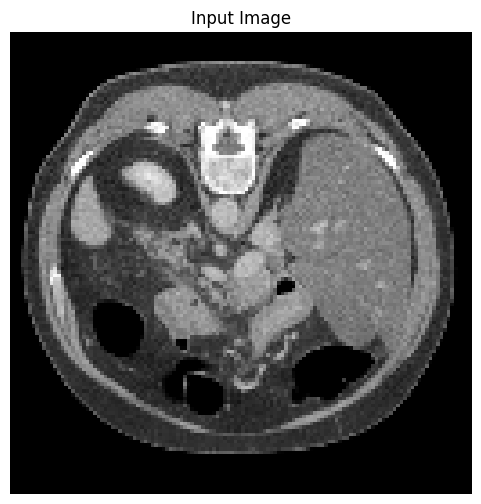

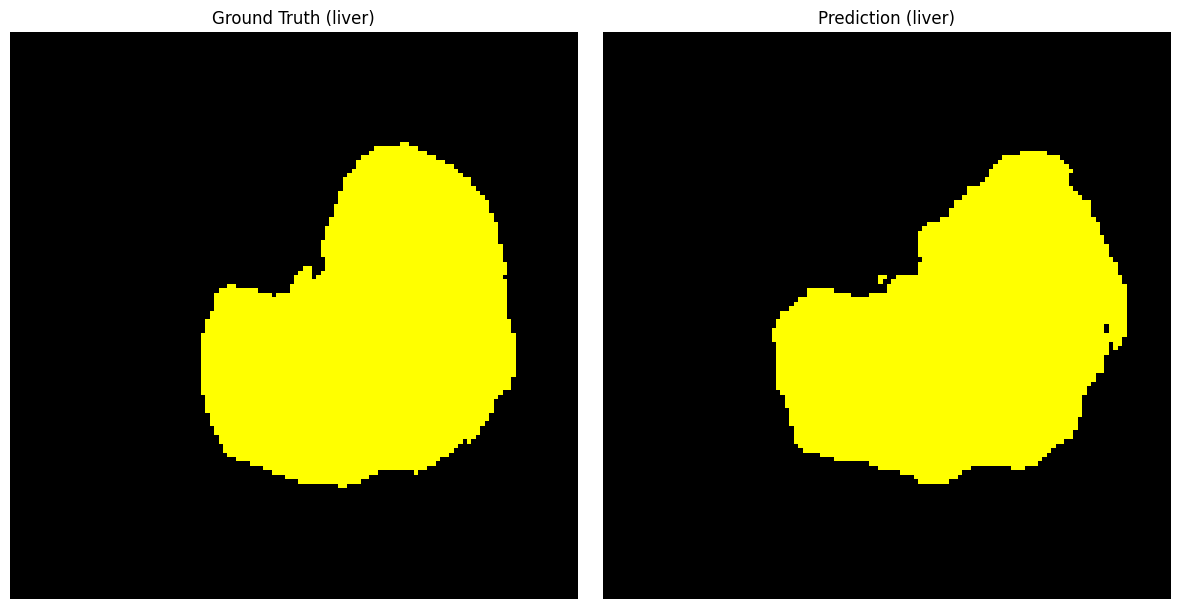

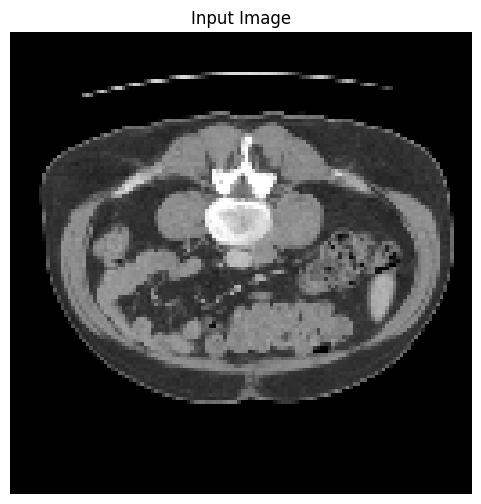

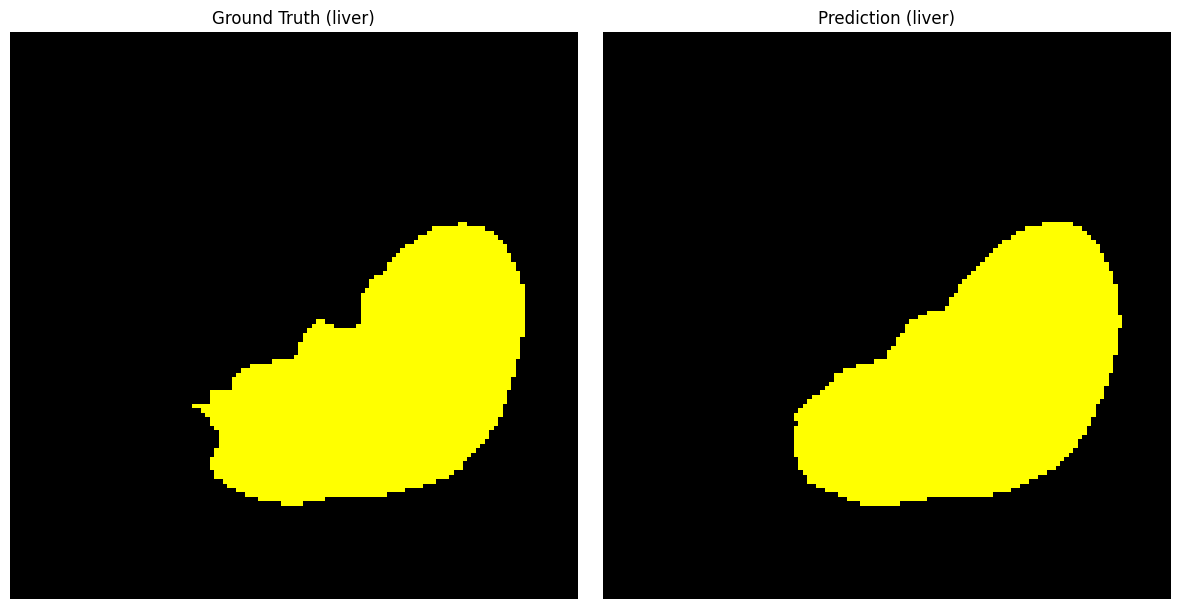

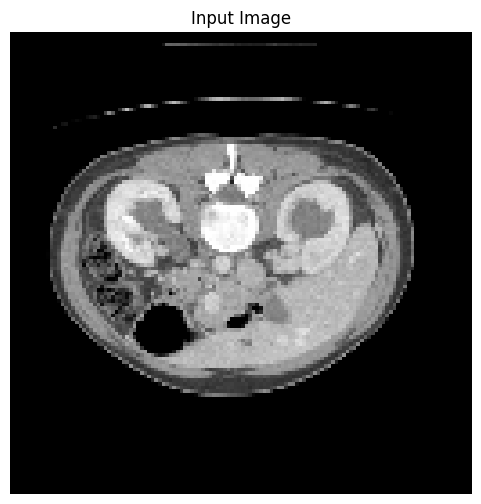

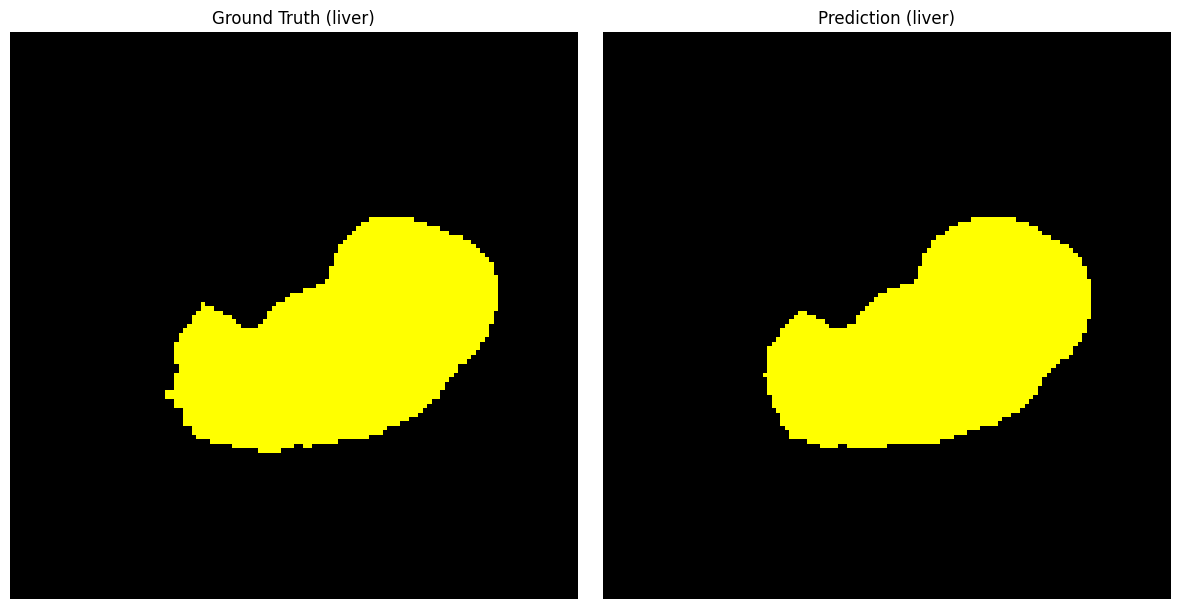

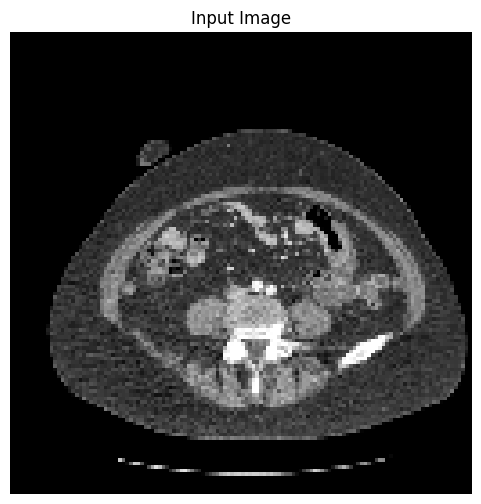

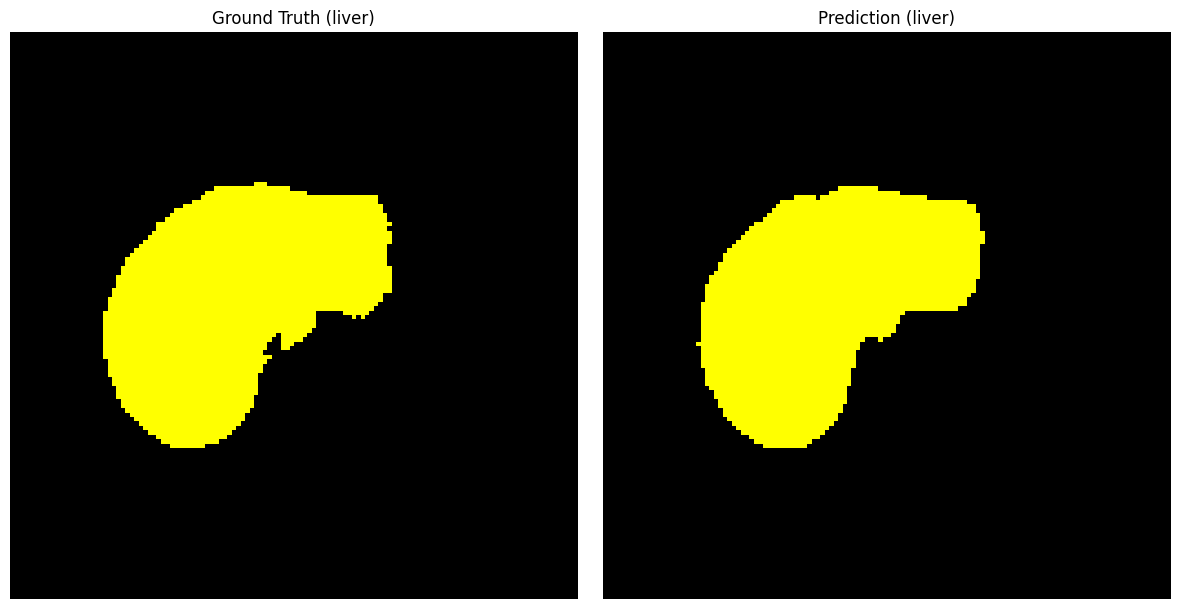

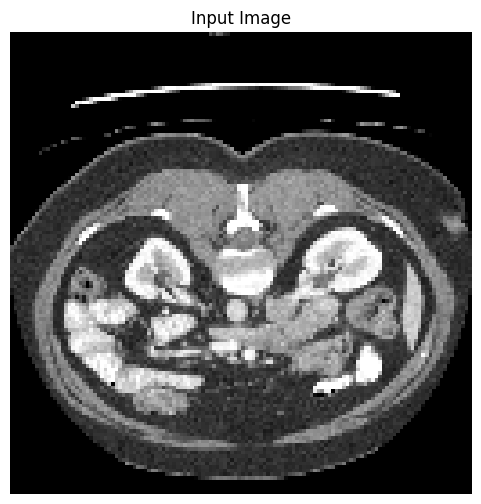

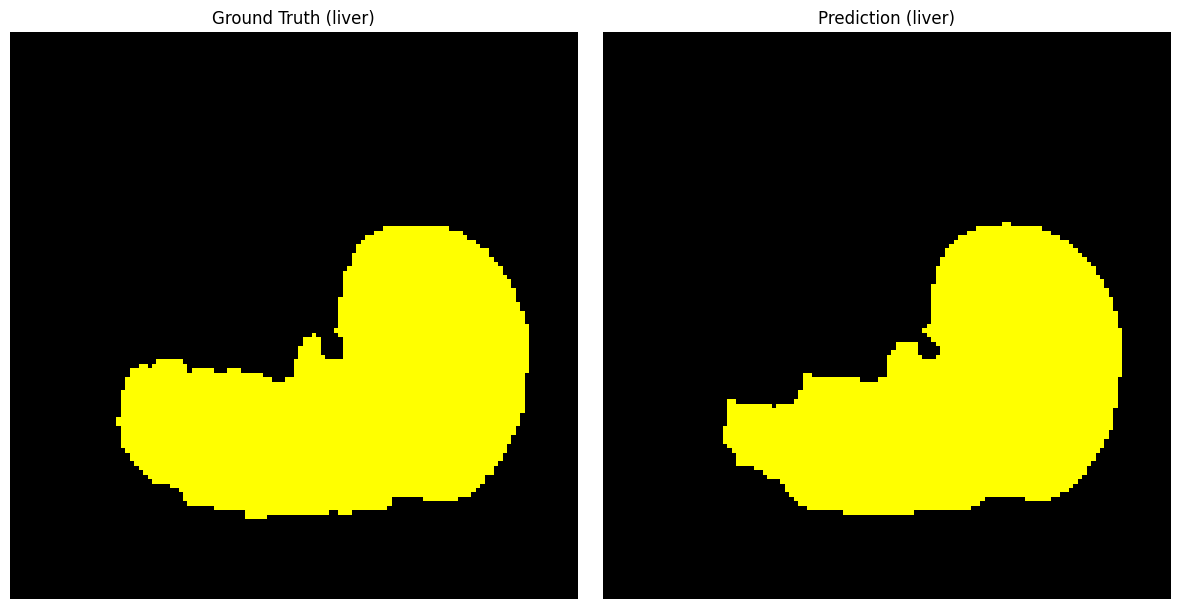

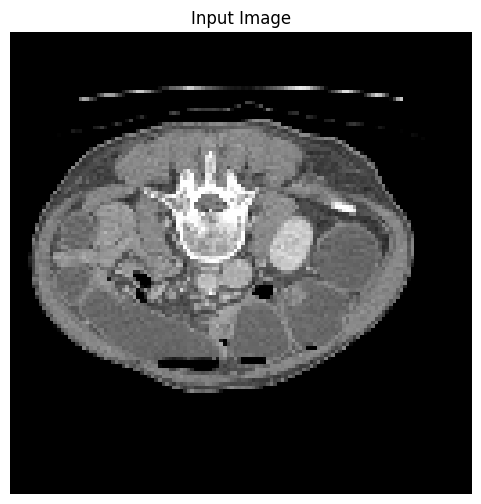

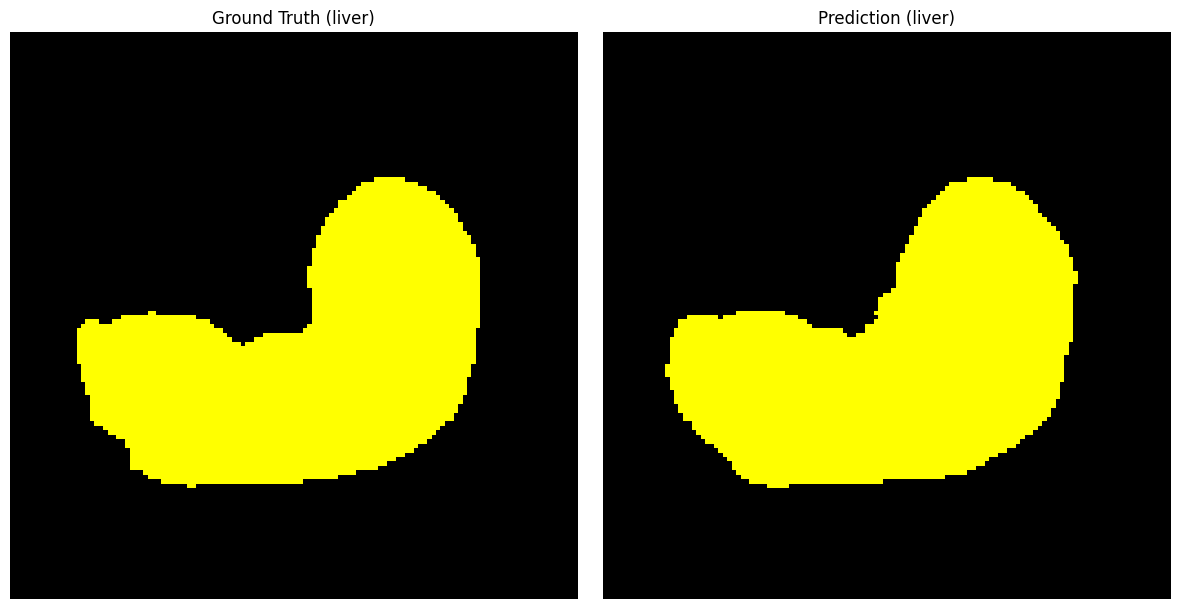

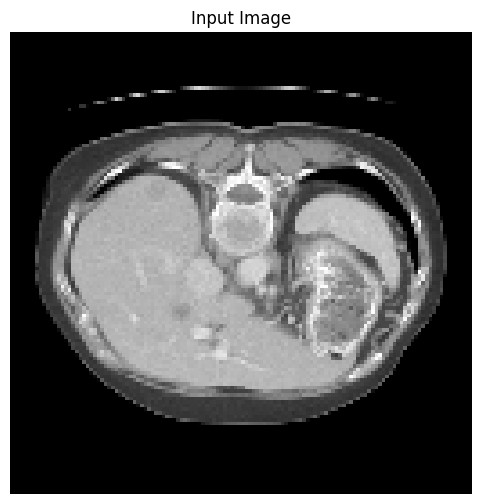

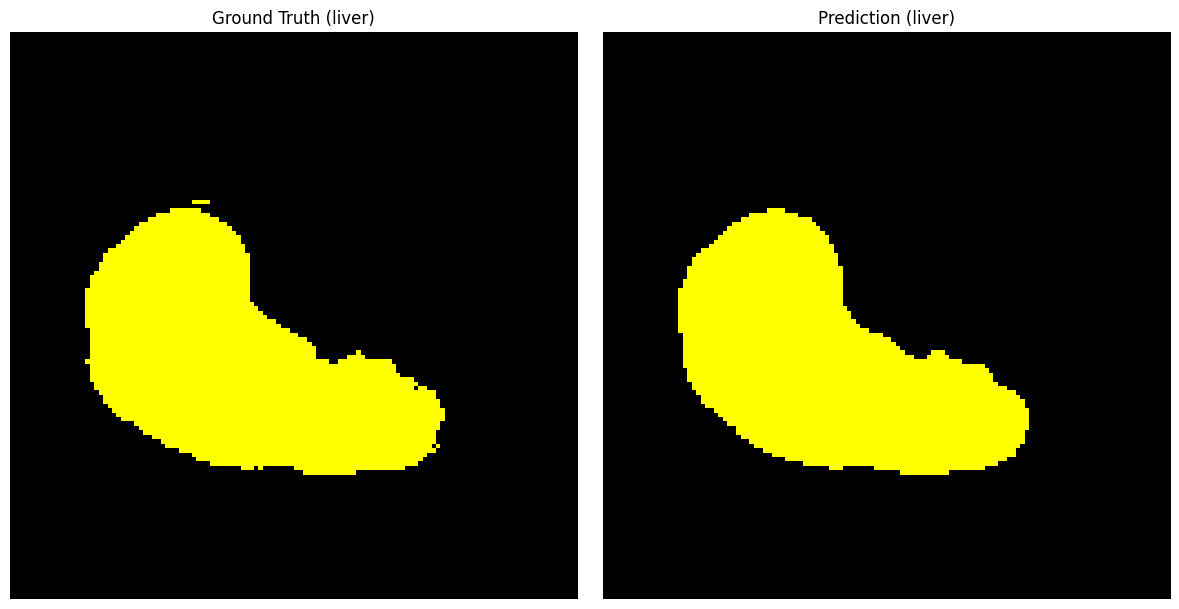

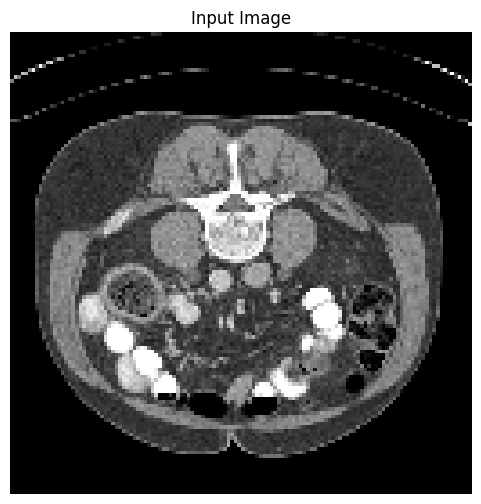

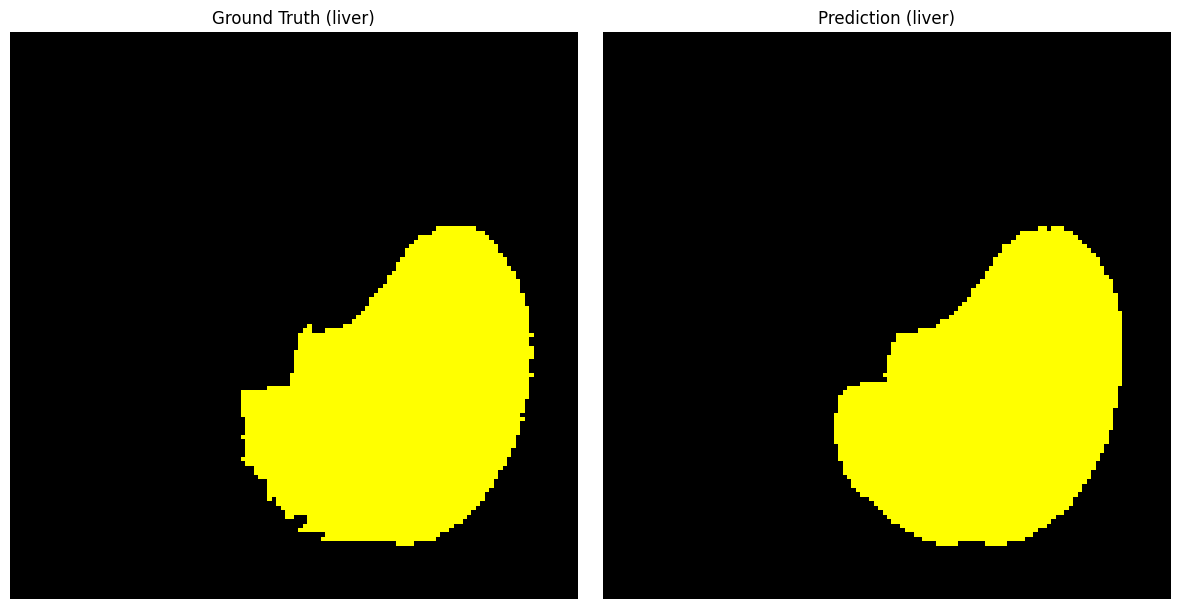

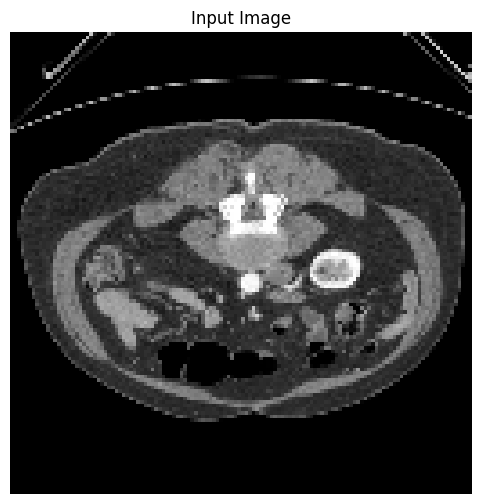

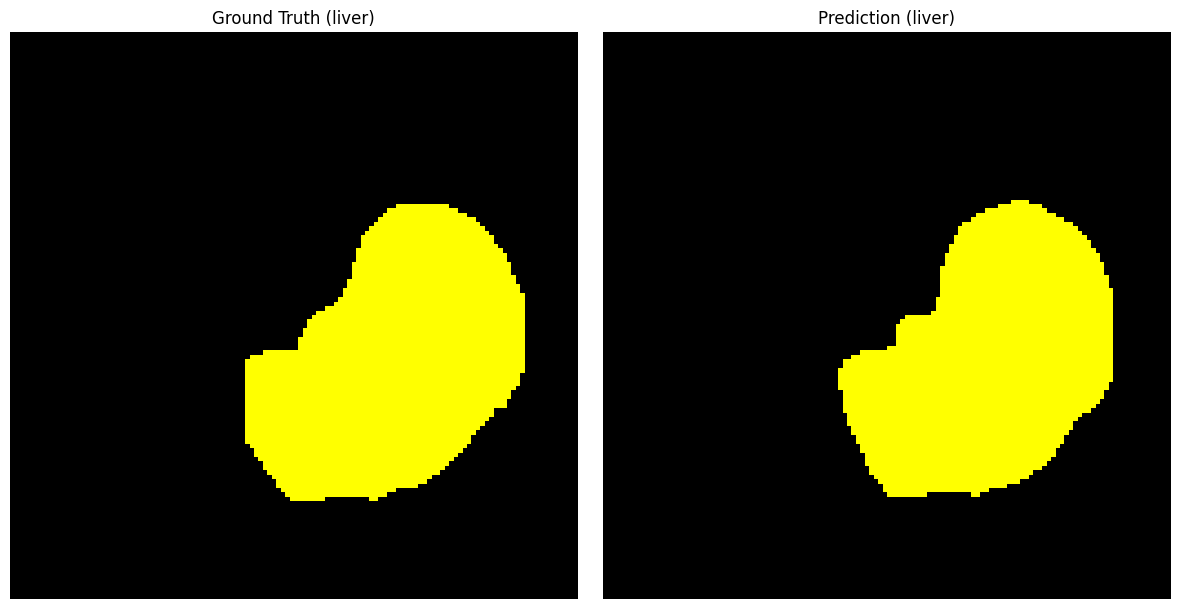

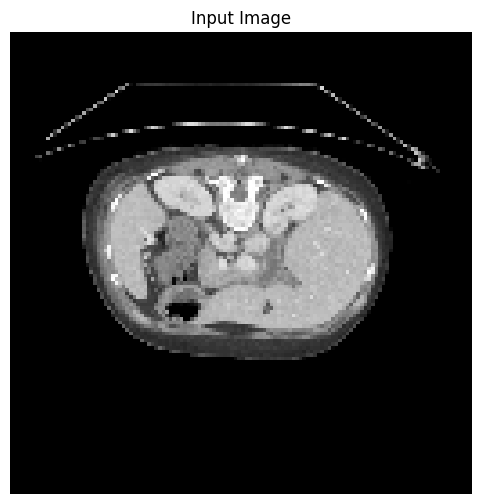

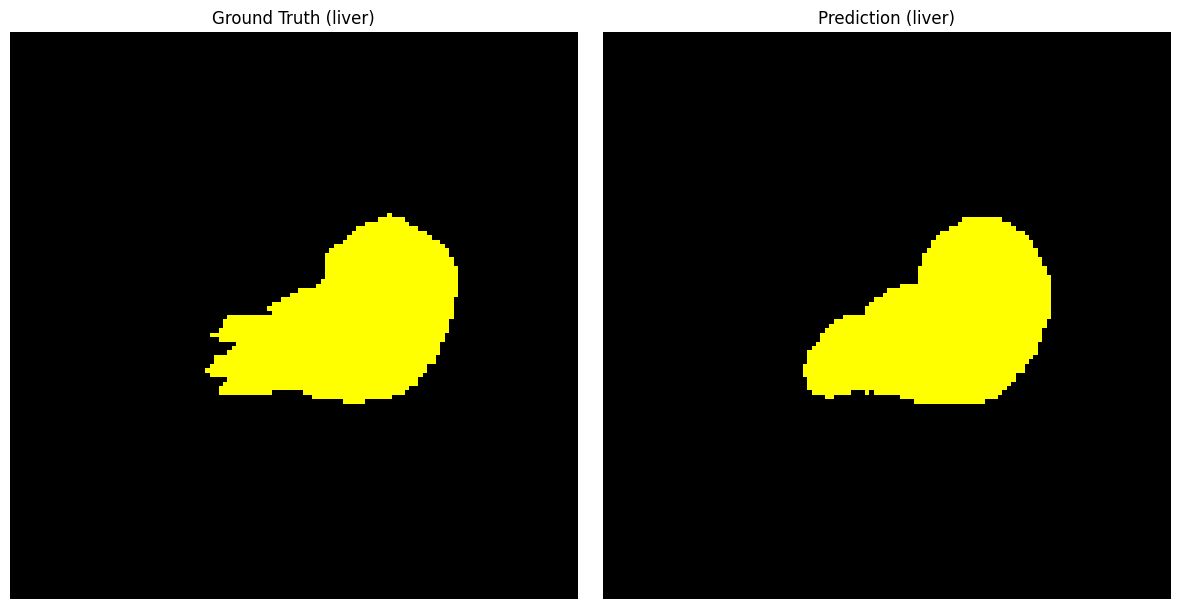

In [17]:
num_images = 10
weight_path = "/content/gdrive/MyDrive/KLTN/code/weight/best_metric_model_UNet3DWResNeXtCoT_liver_1.pth"
visualize_results_stage_1(model, val_loader, weight_path, num_images, device)

## Result Metrics

In [18]:
def load_metrics(json_path):
    with open(json_path, 'r') as f:
        return json.load(f)

In [19]:
import glob
print(glob.glob("/content/gdrive/MyDrive/KLTN/code/result_model_*.json"))

['/content/gdrive/MyDrive/KLTN/code/result_model_UNet3D.json', '/content/gdrive/MyDrive/KLTN/code/result_model_UNet3DWCoT.json', '/content/gdrive/MyDrive/KLTN/code/result_model_UNet3DWCoTDA.json', '/content/gdrive/MyDrive/KLTN/code/result_model_UNet3DWResNeXtCoT.json', '/content/gdrive/MyDrive/KLTN/code/result_model_UNet3DPretrained_pretrained.json', '/content/gdrive/MyDrive/KLTN/code/result_model_UNet3DWConvNeXtV2CoT.json', '/content/gdrive/MyDrive/KLTN/code/result_model_UNet3DWResNeXtCoT_liver.json', '/content/gdrive/MyDrive/KLTN/code/result_model_UNet3DWResNeXtCoT_tumor.json', '/content/gdrive/MyDrive/KLTN/code/result_model_UNet3DWResNeXtCoT_tumor_1.json', '/content/gdrive/MyDrive/KLTN/code/result_model_UNet3DWResNeXtCoT_tumor_2.json', '/content/gdrive/MyDrive/KLTN/code/result_model_UNet3DWResNeXtCoT_tumor_2d.json', '/content/gdrive/MyDrive/KLTN/code/result_model_UNet3DWResNeXtCoT_liver_1.json']


In [20]:
model_results = load_metrics('/content/gdrive/MyDrive/KLTN/code/result_model_UNet3DWResNeXtCoT_liver_1.json')

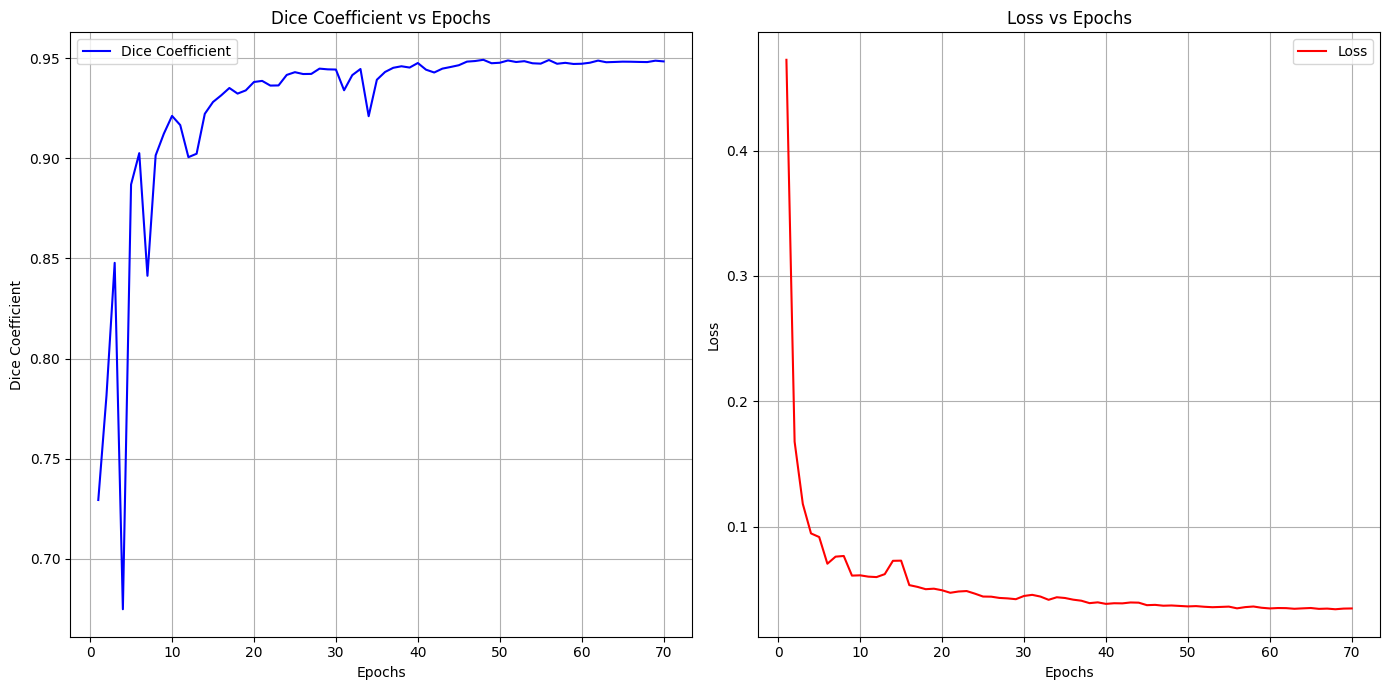

In [21]:
epochs = list(range(1, len(model_results["dice_liver"]) + 1))
plt.figure(figsize=(14, 7))

# dice
plt.subplot(1, 2, 1)
plt.plot(epochs, model_results["dice_liver"], label='Dice Coefficient', color='blue')
plt.title('Dice Coefficient vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.grid()

#loss
plt.subplot(1, 2, 2)
plt.plot(epochs, model_results["loss"], label='Loss', color='red')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()